In [1]:
import dask
dask.config.set({"dataframe.query-planning": False})

import anndata
import itertools
import scanpy as sc
import gseapy
import liana
import scipy
import numpy as np
import pandas as pd
import sys
import gc
import argparse
import json
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from typing import Dict, Optional, List

sys.path.append("../../../workflow/scripts/")
import _utils
import readwrite
cfg = readwrite.config()
sns.set_style('ticks')


def process_count_correction_samples_out_of_core(xenium_paths,correction_methods,func):
    """
    Reads corrected count samples in parallel using ThreadPoolExecutor.

    Args:
        xenium_paths (dict): A dictionary where keys are correction methods and values are dictionaries
                            mapping sample names to corrected counts file paths.  Assumes `xenium_paths[correction_method]`
                            is a dictionary with keys as sample name and values as path to the .h5 file.
        correction_methods (list): A list of correction methods.
        func: A function to apply to each sample
    Returns:
        dict: A dictionary where keys are correction methods, and values are dictionaries mapping sample names
              to AnnData objects (or None if reading failed).
    """

    xenium_corrected_counts = {}

    for correction_method in correction_methods:  # Skip the first correction method
        xenium_corrected_counts[correction_method] = {}

        with ThreadPoolExecutor() as executor:
            futures = {
                executor.submit(readwrite._read_count_correction_sample, k, xenium_corr_path): (correction_method, k)
                for k, xenium_corr_path in xenium_paths[correction_method].items()
            }

            # Progress bar with total number of samples
            for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {correction_method}"):
                try:
                    k, adata = future.result()
                    if adata is not None:
                        # fix raw obs names for proseg
                        if correction_method == 'raw' and k[0] == "proseg_expected": 
                            adata.obs_names = "proseg-" + adata.obs_names.astype(str)

                        # compute func
                        xenium_corrected_counts[correction_method][k] = func(adata)

                        # free memory
                        del adata
                        gc.collect()
                    else:
                         xenium_corrected_counts[correction_method][k] = None
                except Exception as e:
                    correction_method, k = futures[future]
                    xenium_corrected_counts[correction_method][k] = None  # Store None in case of error

    return xenium_corrected_counts



def get_mean_n_genes(
    ads: Dict[str, Dict[str, anndata.AnnData]],
    correction_methods: List[str],
    labels_key: str,
    columns=None
) -> pd.DataFrame:
    """
    Calculates the mean number of genes (`n_genes`) for all unique cell types (`cti`) found
    in the `labels_key` column across different AnnData objects and correction methods.

    Args:
        ads (Dict[str, Dict[str, anndata.AnnData]]): A nested dictionary structure containing
            AnnData objects. The outer dictionary's keys are correction methods, and the
            inner dictionary's keys are sample identifiers. Each inner dictionary value
            is an AnnData object. Assumes `ads[correction_method][k]` is an AnnData object.
        correction_methods (List[str]): A list of correction methods to iterate through.
        labels_key (str): The key in `ad.obs` that contains cell type labels.
        columns (list): optional column names for the returned DataFrame
    Returns:
        pd.DataFrame: A DataFrame where each row represents a unique combination of sample
            identifier, correction method, and cell type. The columns include sample identifiers,
            correction method, cell type (`cti`), and the calculated mean number of genes
            ('n_genes').
    """

    data = []
    for correction_method in correction_methods:
        for k, ad in ads[correction_method].items():
            if ad is not None:
                # Get unique cell types for the current AnnData object
                ad.obs['n_genes'] = (ad.X>0).sum(1).A1
                unique_ctis = ad.obs[labels_key].unique()

                for cti in unique_ctis:
                    mean_n_genes = np.mean(ad[ad.obs[labels_key] == cti].obs['n_genes'])
                    data.append((*k, correction_method, cti, mean_n_genes))  # Append cell type to the data

    # Create the DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

    if columns is not None:
        df.columns = columns
    return df

def get_mean_cell_identity_score_markers(
    ads: Dict[str, Dict[str, anndata.AnnData]],
    df_markers: pd.DataFrame,
    correction_methods: List[str],
    labels_key: str,
    columns=None
) -> pd.DataFrame:
    """
    Calculates the mean number of genes (`n_genes`) for all unique cell types (`cti`) found
    in the `labels_key` column across different AnnData objects and correction methods.

    Args:
        ads (Dict[str, Dict[str, anndata.AnnData]]): A nested dictionary structure containing
            AnnData objects. The outer dictionary's keys are correction methods, and the
            inner dictionary's keys are sample identifiers. Each inner dictionary value
            is an AnnData object. Assumes `ads[correction_method][k]` is an AnnData object.
        df_markers (pd.DataFrame): A DataFrame containing cell type markers.
        correction_methods (List[str]): A list of correction methods to iterate through.
        labels_key (str): The key in `ad.obs` that contains cell type labels.
        columns (list): optional column names for the returned DataFrame
    Returns:
        pd.DataFrame: A DataFrame where each row represents a unique combination of sample
            identifier, correction method, and cell type. The columns include sample identifiers,
            correction method, cell type (`cti`), and the calculated mean number of genes
            ('n_genes').
    """

    data = []
    for correction_method in correction_methods:
        for k, ad in ads[correction_method].items():
            if ad is not None:
                unique_ctis = ad.obs[labels_key].unique()

                for cti in unique_ctis:
                    cti_markers = df_markers.query("cell_type == @cti")['gene_name'].tolist()
                    cti_markers = [g for g in cti_markers if g in ad.var_names]
                    if len(cti_markers):
                        n_genes_cti_markers = (ad[ad.obs[labels_key] == cti,cti_markers].X>0).sum(1).A1
                        mean_n_genes = np.mean(n_genes_cti_markers)
                        data.append((*k, correction_method, cti, mean_n_genes))  # Append cell type to the data

    # Create the DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

    if columns is not None:
        df.columns = columns
    return df


def get_mean_cell_identity_score_scrna(
    ads: Dict[str, Dict[str, anndata.AnnData]],
    ads_scrnaseq: Dict[str, anndata.AnnData],
    genes: Dict[str, List[str]],
    correction_methods: List[str],
    labels_key: str,
    columns=None
) -> pd.DataFrame:
    """
    Calculates the mean number of genes (`n_genes`) for all unique cell types (`cti`) found
    in the `labels_key` column across different AnnData objects and correction methods.

    Args:
        ads (Dict[str, Dict[str, anndata.AnnData]]): A nested dictionary structure containing
            AnnData objects. The outer dictionary's keys are correction methods, and the
            inner dictionary's keys are sample identifiers. Each inner dictionary value
            is an AnnData object. Assumes `ads[correction_method][k]` is an AnnData object.
        ads_scrnaseq Dict[str, anndata.AnnData]: A dictionary structure containing
            AnnData objects. The dictionary's keys are tissue identifiers corresponding to keys in `ads`.
        correction_methods (List[str]): A list of correction methods to iterate through.
        labels_key (str): The key in `ad.obs` that contains cell type labels.
        columns (list): optional column names for the returned DataFrame
    Returns:
        pd.DataFrame: A DataFrame where each row represents a unique combination of sample
            identifier, correction method, and cell type. The columns include sample identifiers,
            correction method, cell type (`cti`), and the calculated mean number of genes
            ('n_genes').
    """

    data = []
    for correction_method in correction_methods:
        for k, ad in ads[correction_method].items():
            if ad is not None:
                unique_ctis = ad.obs[labels_key].unique()

                for cti in unique_ctis:
                    cti_markers = df_markers.query("cell_type == @cti")['gene_name'].tolist()
                    cti_markers = [g for g in cti_markers if g in ad.var_names]
                    if len(cti_markers):
                        n_genes_cti_markers = (ad[ad.obs[labels_key] == cti,cti_markers].X>0).sum(1).A1
                        mean_n_genes = np.mean(n_genes_cti_markers)
                        data.append((*k, correction_method, cti, mean_n_genes))  # Append cell type to the data

    # Create the DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

    if columns is not None:
        df.columns = columns
    return df

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you a

score p values for malignant markers before / after

# Params

In [2]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
scrnaseq_processed_data_dir = Path(cfg['scrnaseq_processed_data_dir'])
seurat_to_h5_dir = results_dir / 'seurat_to_h5'

# Params
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'
count_correction_palette = palette_dir / 'col_palette_correction_method.csv'

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
scoring = 'f1'
markers = 'diffexpr'

xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
order = ['breast','chuvio','lung','5k']


hue_segmentation = "segmentation"
hue_segmentation_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]

hue_correction = 'correction_method'
hue_correction_order = [
'raw',
'resolvi',
'resolvi_supervised',
'ovrlpy_0.5',
'ovrlpy_0.7'
'split',
]

rank_metrics = ["logfoldchanges", "-log10pvals_x_logfoldchanges", "-log10pvals_x_sign_logfoldchanges"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}"]

labels_key = level

# Load results diffexpr

In [4]:
df_markers_rank_significance_diffexpr, df_ctj_markers, df_diffexpr = readwrite.read_diffexpr_results_samples(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer,
    load_diffexpr=True
)

raw ('proseg_expected', 'breast', 'breast', '1FYB', '1FYB')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_3')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_1')
raw ('proseg_expected', 'breast', 'breast', 'OPHI', 'OPHI_2')
raw ('proseg_expected', 'breast', 'breast', '1BCA', '1BCA')
raw ('proseg_expected', 'breast', 'breast', '0PD6', '0PD6')
raw ('proseg_expected', 'breast', 'breast', '1256', '1256')
raw ('proseg_expected', 'breast', 'breast', '1GV1', '1GV1')
raw ('proseg_expected', 'breast', 'breast', '1GVR', '1GVR')
raw ('proseg_expected', 'breast', 'breast', '1FHZ', '1FHZ')
raw ('proseg_expected', 'breast', 'breast', '0U9A', '0U9A')
raw ('proseg_expected', 'breast', 'breast', '1ESQ', '1ESQ')
raw ('proseg_expected', 'breast', 'breast', '0VRA', '0VRA')
raw ('proseg_expected', 'breast', 'breast', '14LZ', '14LZ')
raw ('proseg_expected', 'breast', 'breast', '1GUC', '1GUC')
raw ('proseg_expected', 'breast', 'breast', '1H27', '1H27')
raw ('proseg_expected', 'breast', 

In [6]:
correction_method = 'raw'
k = 'proseg_expected', 'NSCLC', 'lung', '1G73', '1G73'
u_cell_types = df_ctj_markers['raw'][k].columns

In [28]:
correction_method = 'raw'
k = 'proseg_expected', 'NSCLC', 'lung', '1G73', '1G73'
u_cell_types = df_ctj_markers['raw'][k].columns

df_markers_rank_significance_diffexpr_ctj_markers_from_raw = {}
for ctj in u_cell_types:

    # get markers
    ctj_marker_genes = df_ctj_markers['raw'][k][ctj]

    for cti in u_cell_types:
        if cti == ctj:
            continue

        df_diffexpr_cti_ctj = df_diffexpr[correction_method][k].loc[cti, ctj]

        # add ranking scores
        df_diffexpr_cti_ctj["-log10pvals_x_logfoldchanges"] = (
            -np.log10(df_diffexpr_cti_ctj["pvals"]) * df_diffexpr_cti_ctj["logfoldchanges"]
        )
        df_diffexpr_cti_ctj["-log10pvals_x_signFC"] = -np.log10(df_diffexpr_cti_ctj["pvals"]) * np.sign(
            df_diffexpr_cti_ctj["logfoldchanges"]
        )

        # get significance from gsea and hypergeometric test
        df_markers_rank_significance_diffexpr = pd.DataFrame()
        for rank_metric in rank_metrics:
            df_markers_rank_significance_diffexpr[rank_metric] = _utils.get_marker_rank_significance(
                rnk=df_diffexpr_cti_ctj.set_index("names")[rank_metric].sort_values(ascending=False),
                gene_set=ctj_marker_genes,
                top_n=top_n,
            ).iloc[0]

/tmp/ipykernel_1907165/1627245452.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_1907165/1627245452.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1907165/1627245452.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2025-03-20 14:40:01,343 [WARNING] Input gene ra

KeyError: 'granulocyte'

# Load corrected counts

In [5]:
xenium_paths = {}
xenium_annot_paths = {}

for correction_method in correction_methods:
    xenium_paths[correction_method] = {}
    xenium_annot_paths[correction_method] = {}
    
    for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
        if segmentation.stem == 'proseg_mode':
            continue
        for condition in (conditions := segmentation.iterdir()): 
            for panel in (panels := condition.iterdir()):
                for donor in (donors := panel.iterdir()):
                    for sample in (samples := donor.iterdir()):

                        k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                        name = '/'.join(k)

                        # raw samples
                        if 'proseg' in segmentation.stem:
                            k_proseg = ('proseg',condition.stem,panel.stem,donor.stem,sample.stem)
                            name_proseg = '/'.join(k_proseg)
                            sample_dir = xenium_dir / f'{name_proseg}/raw_results'
                        else:
                            sample_dir = xenium_dir / f'{name}/normalised_results/outs'

                        sample_annotation = xenium_cell_type_annotation_dir / f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet'
                        
                        if correction_method == 'raw':
                            xenium_paths[correction_method][k] = sample_dir
                            xenium_annot_paths[correction_method][k] = sample_annotation
                        
                        # corrected samples
                        else:
                            if correction_method == "resolvi":
                                name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
                            elif correction_method == "resolvi_supervised":
                                name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
                            elif "ovrlpy" in correction_method:
                                name_corrected = f'{name}'

                            sample_corrected_counts_path = results_dir / f"{correction_method}/{name_corrected}/corrected_counts.h5"
                            sample_normalised_counts = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/{layer}.parquet'
                            sample_idx = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/cells.parquet'

                            xenium_paths[correction_method][k] = sample_corrected_counts_path


ads = readwrite.read_count_correction_samples(xenium_paths,correction_methods[1:])
ads['raw'] = readwrite.read_xenium_samples(xenium_paths['raw'],anndata=True,transcripts=False,max_workers=6)

# fix obs names for proseg expected, load cell types
# filter out cells without labels (this will apply QC thresholds as well since annotation is done after QC)
for correction_method in correction_methods:
    for k, ad in ads[correction_method].items():
        if ad is not None and k in ads['raw']:

            if correction_method == 'raw':
                if k[0] == "proseg_expected": 
                    ad.obs_names = ad.obs_names.astype(str)
                    ad.obs_names = "proseg-" + ad.obs_names

                # filter cells and read labels for raw
                ad.obs[labels_key] = (
                    pd.read_parquet(xenium_annot_paths['raw'][k]).set_index("cell_id").iloc[:, 0].astype("category")
                )
                ads['raw'][k] = ad[ad.obs[labels_key].notna()]

            # filter cells and add labels from raw
            if correction_method != 'raw':
                ad.obs[labels_key] = ads['raw'][k].obs[labels_key]
                ad = ad[[c for c in ads['raw'][k].obs_names if c in ad.obs_names]]
                ads[correction_method][k] = ad


Processing resolvi_supervised: 100%|██████████| 251/251 [00:29<00:00,  8.65it/s]


Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/breast/breast/1FYB/1FYB/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/breast/breast/1FYB/1FYB/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/breast/breast/OPHI/OPHI_3/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/breast/breast/OPHI/OPHI_3/corrected_counts.h5', errno = 2, error message = 'No such file or di

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  13%|█▎        | 32/251 [00:00<00:00, 278.66it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/chuvio/0PSV/0PSV_1/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/chuvio/0PSV/0PSV_1/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/chuvio/0PSV/0PSV_2/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/chuvio/0PSV/0PSV_2/corrected_counts.h5', errno = 2, error message = 'No such file or di

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  36%|███▌      | 90/251 [00:04<00:10, 15.07it/s] 

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1G73/1G73/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1G73/1G73/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.5:  39%|███▊      | 97/251 [00:05<00:10, 14.25it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PR

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  44%|████▍     | 110/251 [00:06<00:09, 15.22it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.5:  53%|█████▎    | 133/251 [00:08<00:07, 15.93it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1G73/1G73/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1G73/1G73/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /wor

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  54%|█████▍    | 136/251 [00:08<00:07, 15.42it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /wor

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  57%|█████▋    | 142/251 [00:09<00:06, 16.64it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_mm_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_mm_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_mm_5um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_mm_5um/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error read

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  69%|██████▉   | 174/251 [00:12<00:09,  8.03it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GAC/1GAC/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GVD/1GVD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  76%|███████▌  | 190/251 [00:13<00:04, 13.72it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.5:  88%|████████▊ | 220/251 [00:16<00:02, 13.13it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1G73/1G73/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1G73/1G73/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PR

Processing ovrlpy_correction_signal_integrity_threshold=0.5:  92%|█████████▏| 232/251 [00:16<00:00, 26.54it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.5: 100%|██████████| 251/251 [00:16<00:00, 15.00it/s]


Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/breast/breast/1FYB/1FYB/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/breast/breast/1FYB/1FYB/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/breast/breast/OPHI/OPHI_3/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/breast/breast/OPHI/OPHI_3/corrected_counts.h5', errno = 2, error message = 'No such file or di

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  15%|█▌        | 38/251 [00:00<00:00, 265.64it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/lung/1GVD/1GVD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/lung/1GVD/1GVD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/lung/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/lung/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags 

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  35%|███▌      | 89/251 [00:04<00:11, 14.30it/s] 

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1G73/1G73/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1G73/1G73/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PR

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  39%|███▉      | 98/251 [00:04<00:08, 17.44it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.7:  52%|█████▏    | 130/251 [00:07<00:10, 12.07it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Processing ovrlpy_correction_signal_integrity_threshold=0.7:  54%|█████▍    | 135/251 [00:07<00:07, 16.44it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GQ9/1GQ9/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading 

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  59%|█████▊    | 147/251 [00:07<00:03, 29.22it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GAC/1GAC/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error read

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  74%|███████▍  | 186/251 [00:10<00:02, 25.61it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/1GDD/1GDD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/

Processing ovrlpy_correction_signal_integrity_threshold=0.7:  92%|█████████▏| 231/251 [00:12<00:00, 41.66it/s]

Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GDD/1GDD/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/corrected_counts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error reading /work/PR

Processing ovrlpy_correction_signal_integrity_threshold=0.7: 100%|██████████| 251/251 [00:13<00:00, 19.24it/s]


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which 

metrics_summary.csv not found at:INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                             
 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GQ9/1GQ9/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/r

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating

metrics_summary.csv not found at: metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/0PD6/0PD6/raw_results/metrics_summary.csv 
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/0U9A/0U9A/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-package

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/breast/br
         east/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5     

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/0WMU/0WMU_1/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                                
metrics_summary.csv not found at:/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GAC/1GAC/raw_results/metrics_summary.csv 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


metrics_summary.csv not found at:/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/0WMU/0WMU_2/raw_results/metrics_summary.csv 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/14LZ/14LZ/raw_results/metrics_summary.csv
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/0S8R/0S8R/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


metrics_summary.csv not found at: 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GVD/1GVD/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                

metrics_summary.csv not found at: 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1GUC/1GUC/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/0WMU/0WMU_1/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GFF/1GFF/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1FHZ/1FHZ/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/0WMU/0WMU_2/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                
metrics_summary.csv not found at:INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chu
         vio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                              
 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/0OE1/0OE1/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chu
         vio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1ESQ/1ESQ/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chu
         vio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5                                            



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


 INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chu
         vio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1FYB/1FYB/raw_results/metrics_summary.csv
metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/chuvio/0WMU/0WMU/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at:metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/chuvio/0PSV/0PSV_2/raw_results/metrics_summary.csv
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/chuvio/0PSV/0PSV_1/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chu
         vio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                  
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                  
metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1FO7/1FO7/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                  


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1GV1/1GV1/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                  


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/0VRA/0VRA/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                  
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/5k/
         1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                  


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GDD/1GDD/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1256/1256/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                            

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/0PSV/0PSV/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer




metrics_summary.csv not found at: 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1BCA/1BCA/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


metrics_summary.csv not found at:

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/OPHI/OPHI_3/raw_results/metrics_summary.csv
metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1GVR/1GVR/raw_results/metrics_summary.csv

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-package

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/OPHI/OPHI_1/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/OPHI/OPHI_2/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                               

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1G73/1G73/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/19TB/19TB/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0WMU/0WMU_1/normalised_results/outs/cell_feature_matrix.h5                                             

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0WMU/0WMU_2/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/breast/1H27/1H27/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/chuvio/1G73/1G73/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                         


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/5k/1GQ9/1GQ9/raw_results/metrics_summary.csvINFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                         

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0WMU/0WMU_1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0WMU/0WMU_2/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GA2/1GA2/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5     

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/5k/0PSV/0PSV/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0WMU/0WMU_1/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0WMU/0WMU_2/normalised_results/outs/cell_feature_matrix.h5   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/5k/1GAC/1GAC/raw_results/metrics_summary.csv


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


metrics_summary.csv not found at:INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                  
 /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/5k/1GDD/1GDD/raw_results/metrics_summary.csv
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                  
INFO     reading                                                                                                   
      

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0WMU/0WMU_1/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0WMU/0WMU_2/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/m

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5      

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.


Error processing A process in the process pool was terminated abruptly while the future was running or pending.
Error processing A process in the process pool was terminated abruptly while the future was running or pending.
Error processing A process in the process pool was terminated abruptly while the future was running or pending.


In [6]:
# def get_n_genes(adata):
#     return (ad.X>0).sum(1).A1

# process_count_correction_samples_out_of_core(xenium_paths, correction_methods, get_n_genes)

# Load scRNA

In [7]:
layer = 'RNA_counts'
genes = {}
genes['NSCLC'] = pd.read_csv('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
genes['breast'] = pd.read_csv('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv')['Gene'].tolist()

ads_scrna = {}
for ref in (refs := scrnaseq_processed_data_dir.iterdir()):
    ref_name = ref.stem
    ref_dir = seurat_to_h5_dir / ref_name

    if 'matched_combo_standard' not in ref_name:
        continue

    print(ref_name)

    ad = sc.read_10x_h5(ref_dir / f"{layer}.h5")
    ad.obs[level] = pd.read_parquet(ref_dir / "metadata.parquet").set_index("cell_id")[level]
    ad.obs.loc[ad.obs[level].str.contains("malignant"),level] = "malignant cell"
    ads_scrna[ref_name] = ad[ad.obs[level].notna()]

ads_scrna['NSCLC'] = ads_scrna.pop('matched_combo_standard_breast_specific')
ads_scrna['breast'] = ads_scrna.pop('matched_combo_standard_lung_specific')

matched_combo_standard_breast_specific
matched_combo_standard_lung_specific


# Plot decontamination results diffexpr

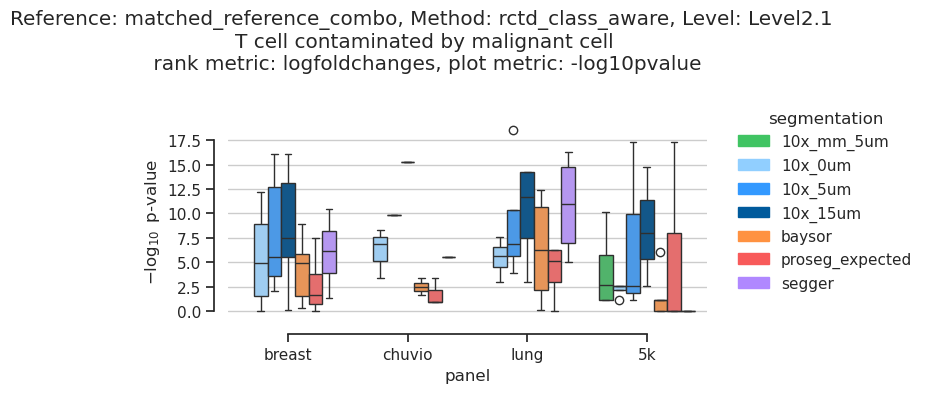

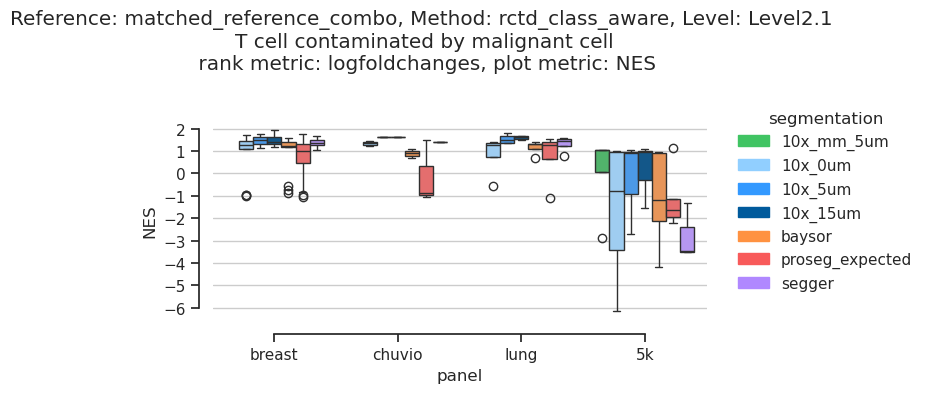

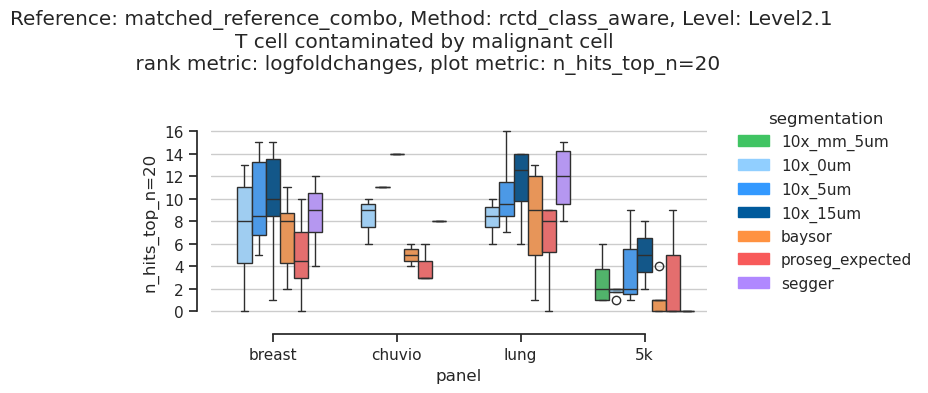

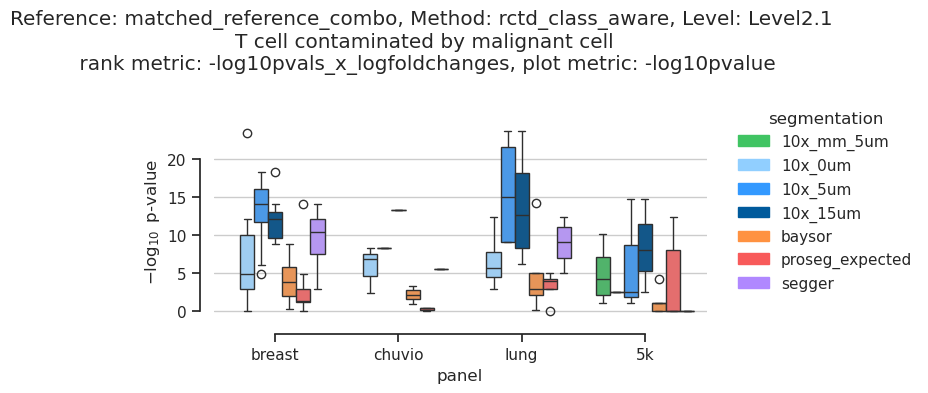

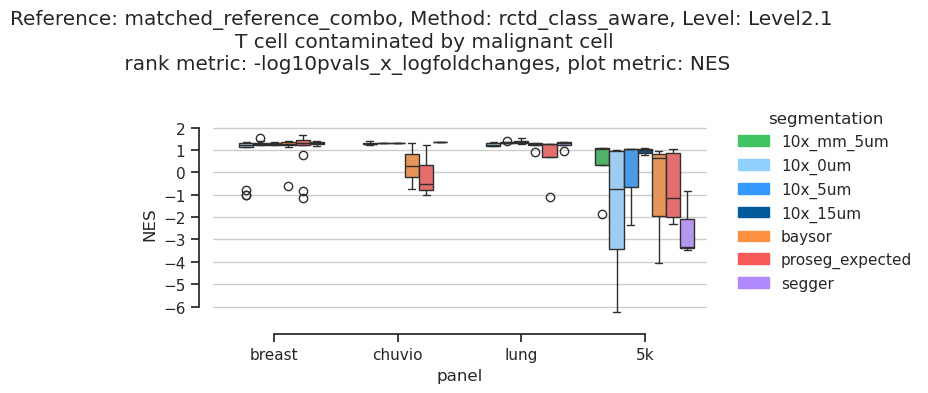

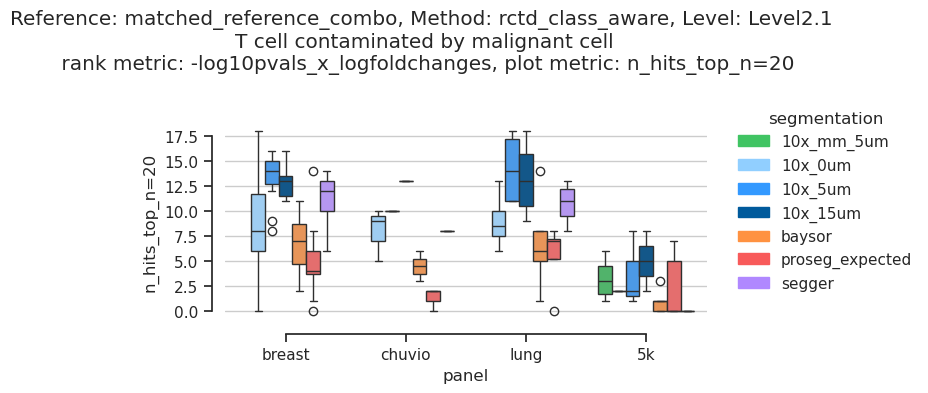

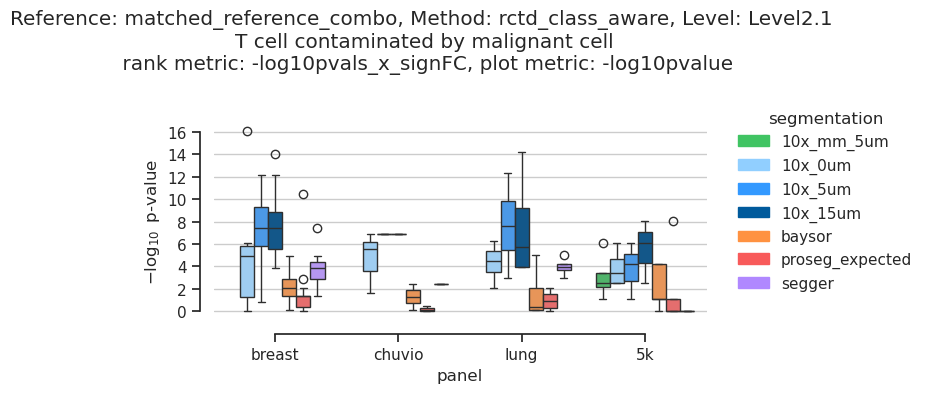

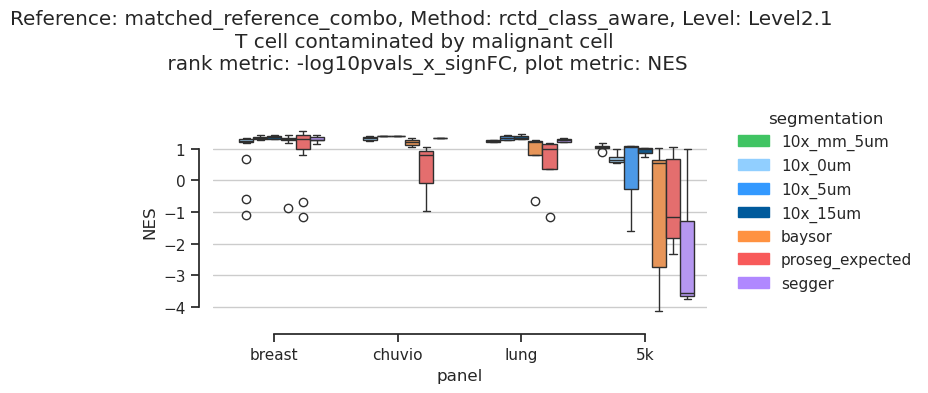

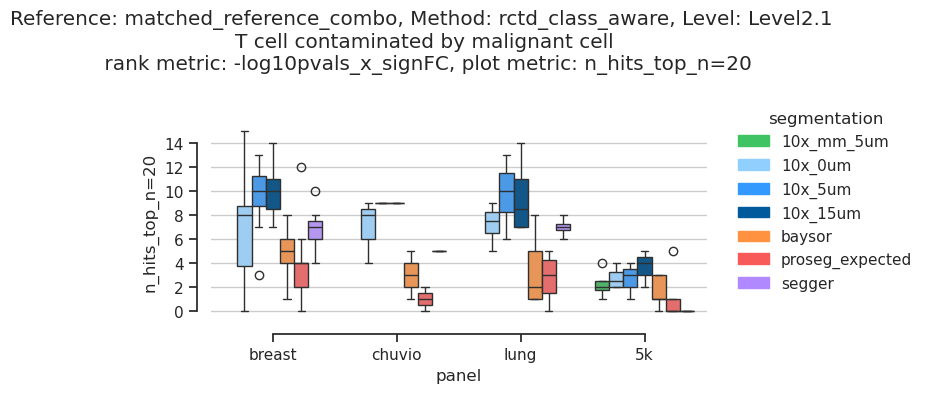

In [15]:
count_correction_method = correction_methods[1]

cti = 'T cell'
ctj = 'malignant cell'

palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:

        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+2 :-1].tolist() + [plot_metric]
        df = df.query("cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_segmentation_order if c in np.unique(df[hue_segmentation].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_segmentation].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        sns.set(style="ticks")

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_segmentation, hue_order=unique_labels, order = order,
                        legend = False, palette=palette,ax=ax
                        )
        if plot_metric == '-log10pvalue':
            plt.ylabel(r'$-\log_{10} \text{ p-value}$')
        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_segmentation,
            frameon=False,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()


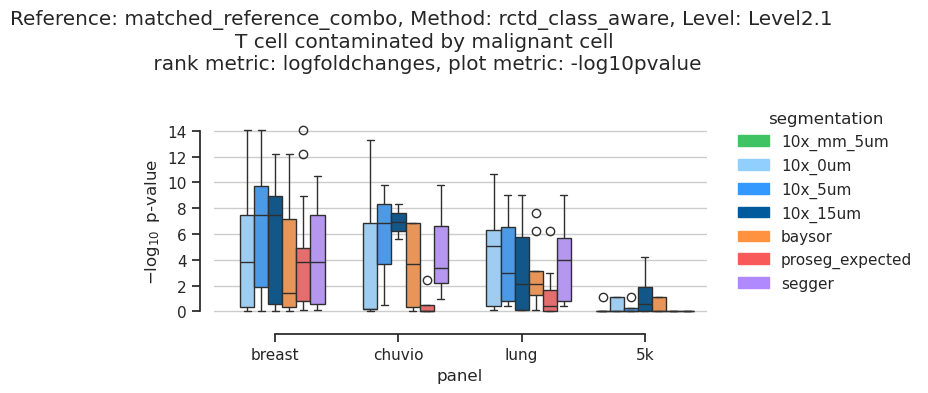

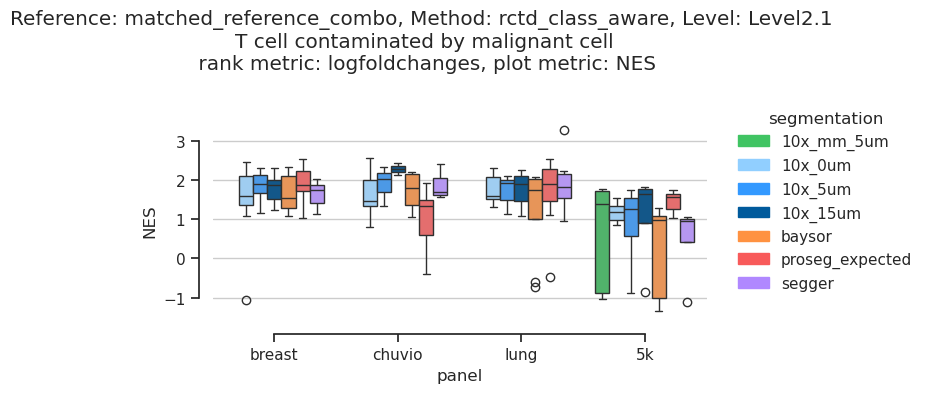

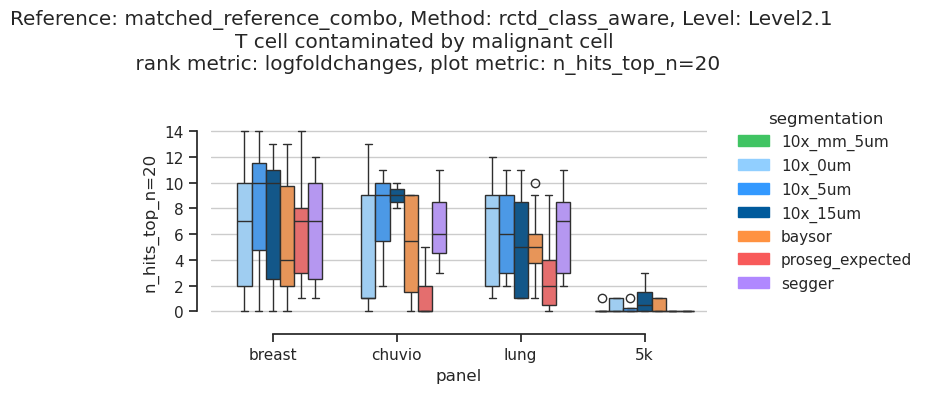

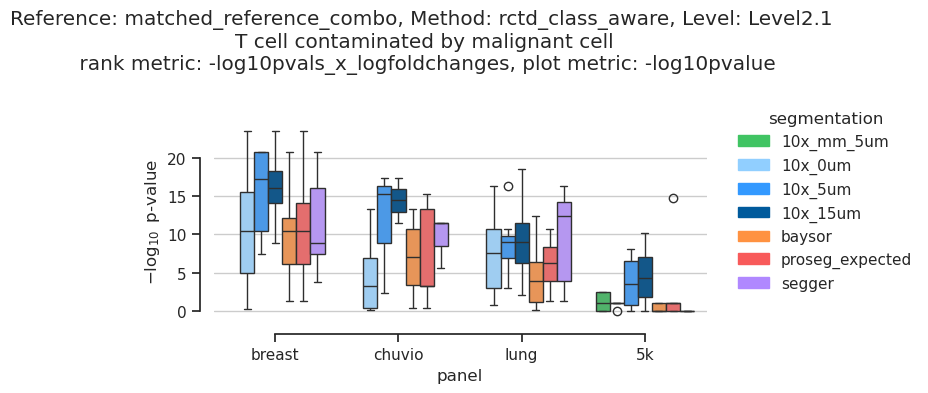

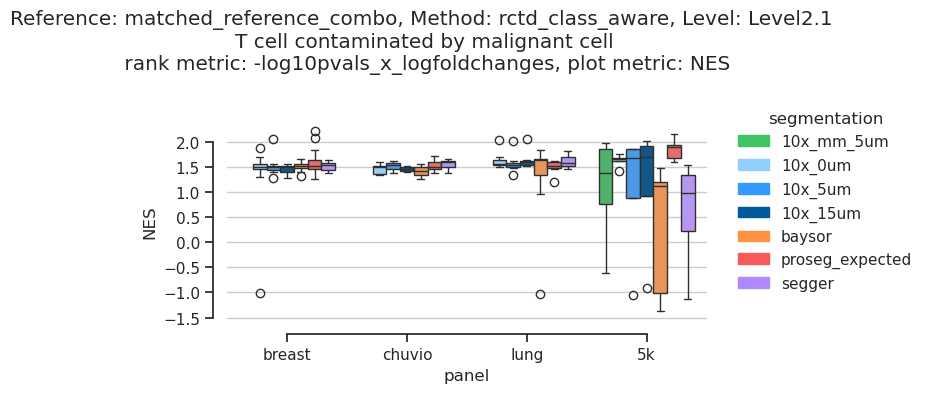

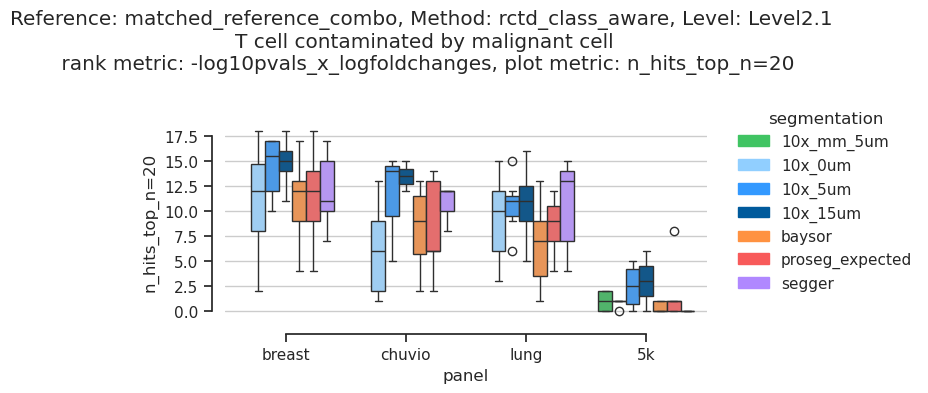

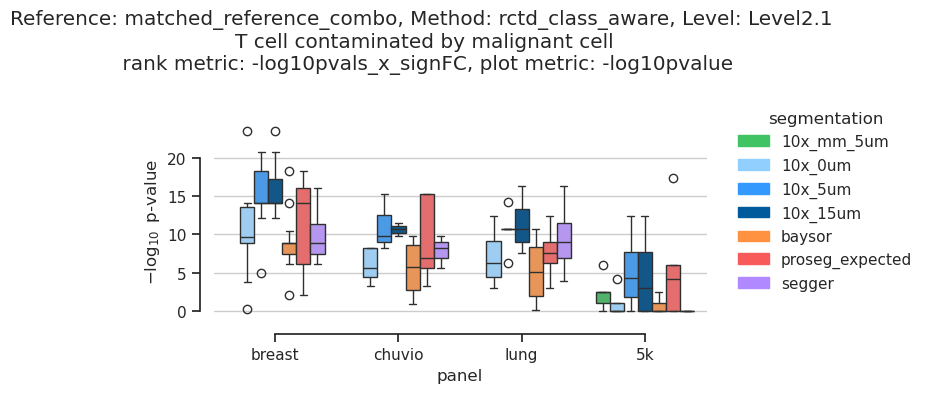

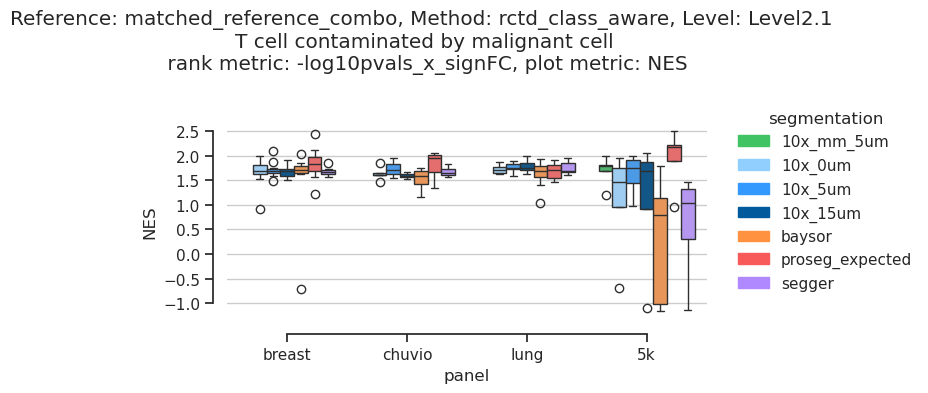

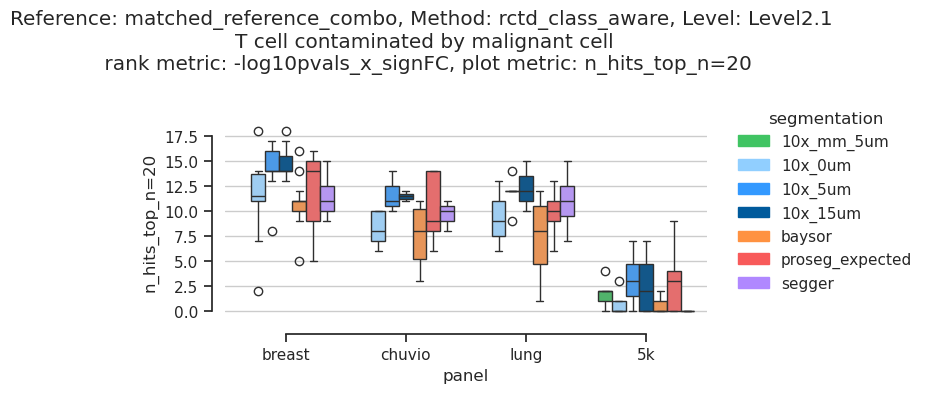

In [16]:
count_correction_method = correction_methods[0]

cti = 'T cell'
ctj = 'malignant cell'

palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:

        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+2 :-1].tolist() + [plot_metric]
        df = df.query("cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_segmentation_order if c in np.unique(df[hue_segmentation].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_segmentation].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        sns.set(style="ticks")

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_segmentation, hue_order=unique_labels, order = order,
                        legend = False, palette=palette,ax=ax
                        )
        if plot_metric == '-log10pvalue':
            plt.ylabel(r'$-\log_{10} \text{ p-value}$')
        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_segmentation,
            frameon=False,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()


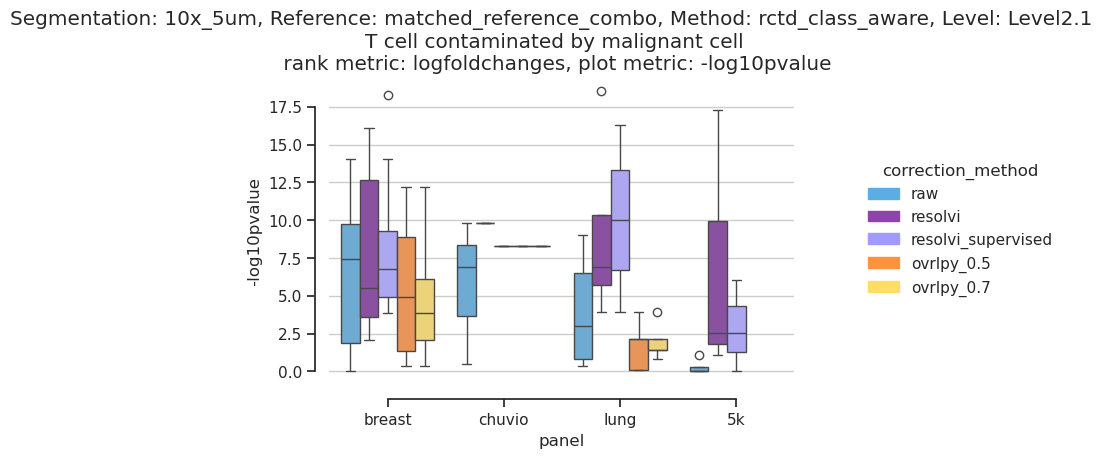

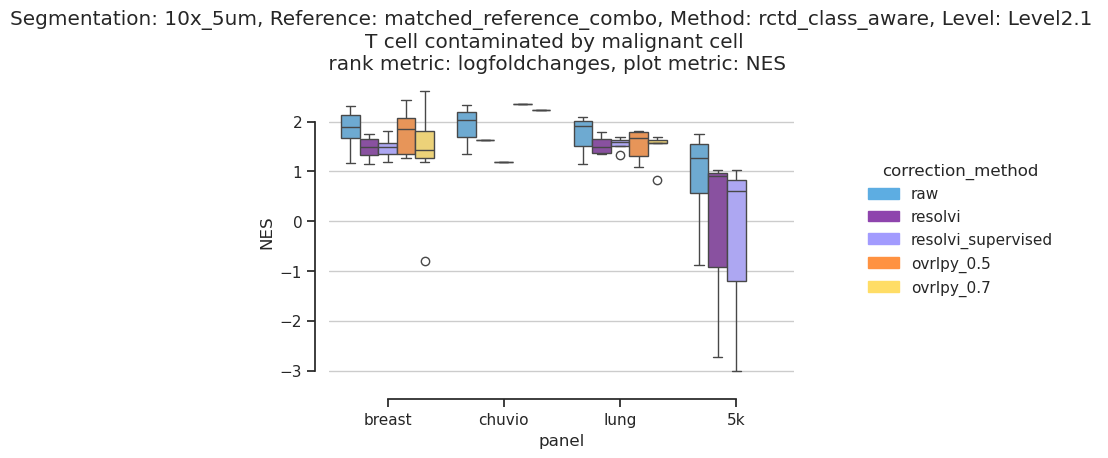

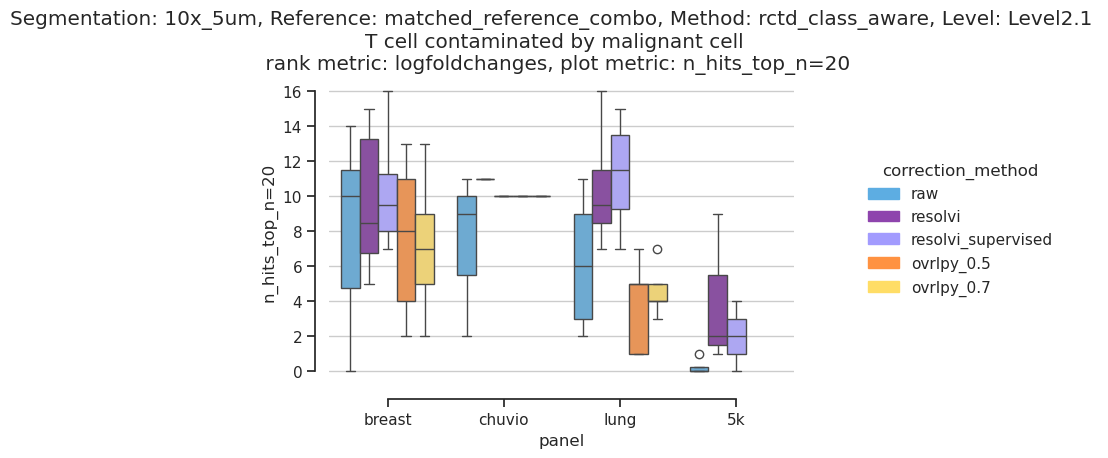

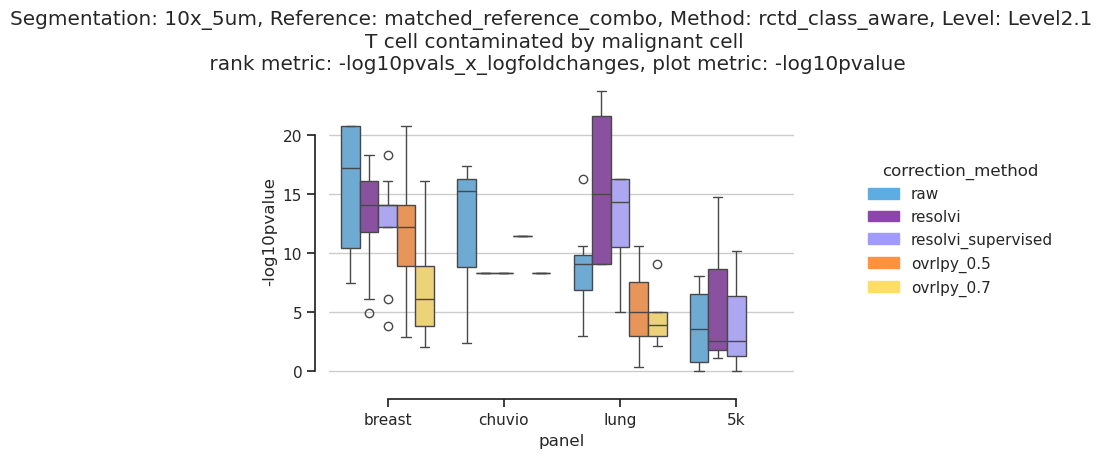

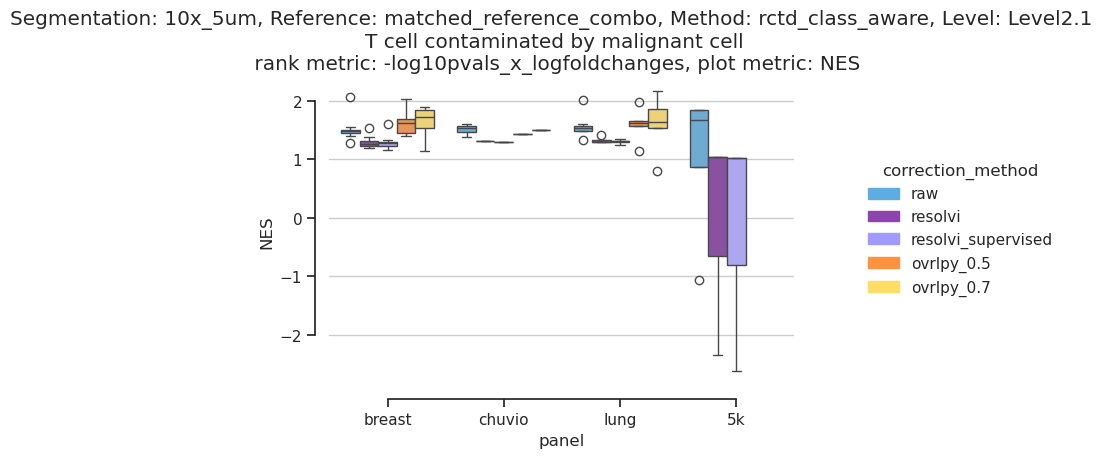

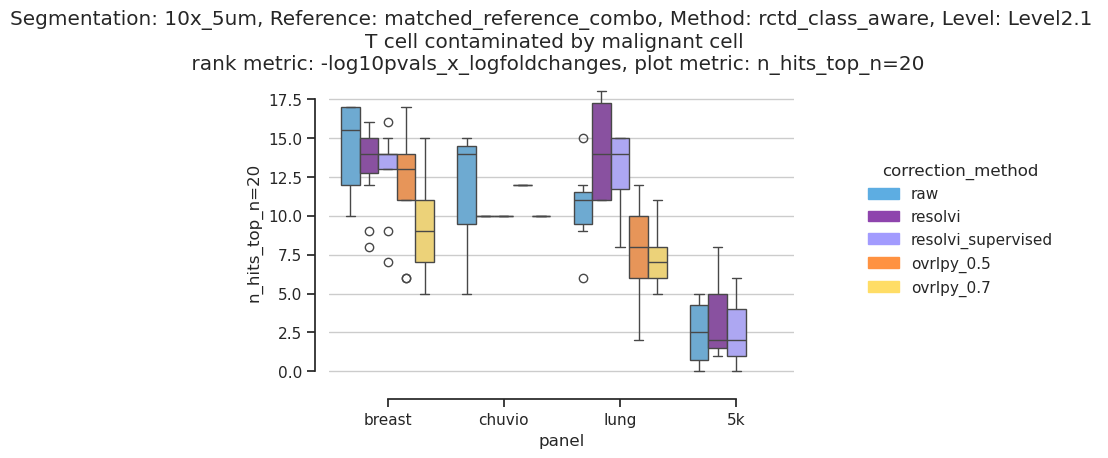

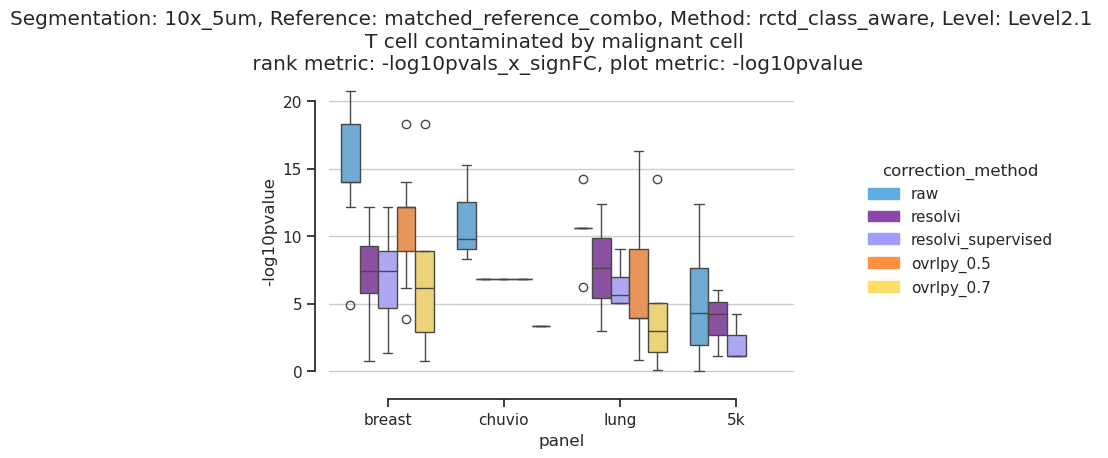

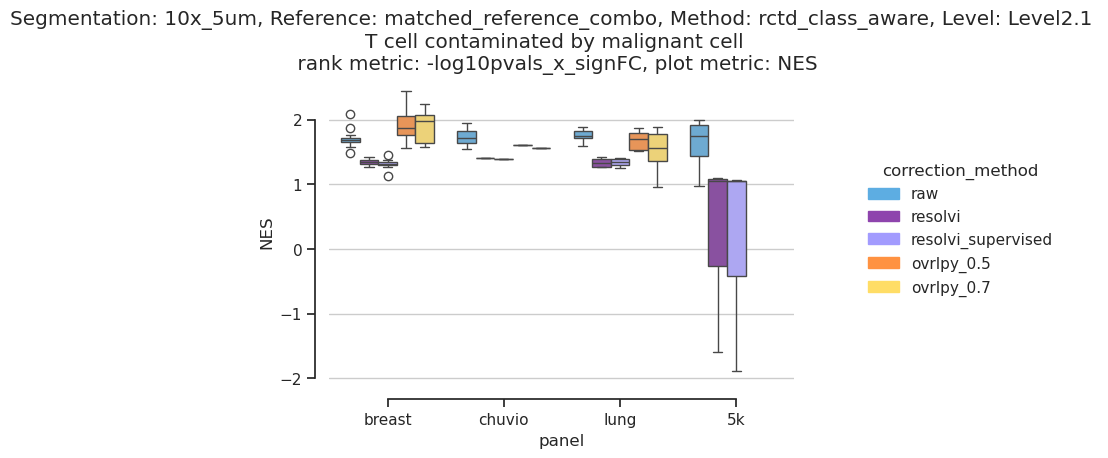

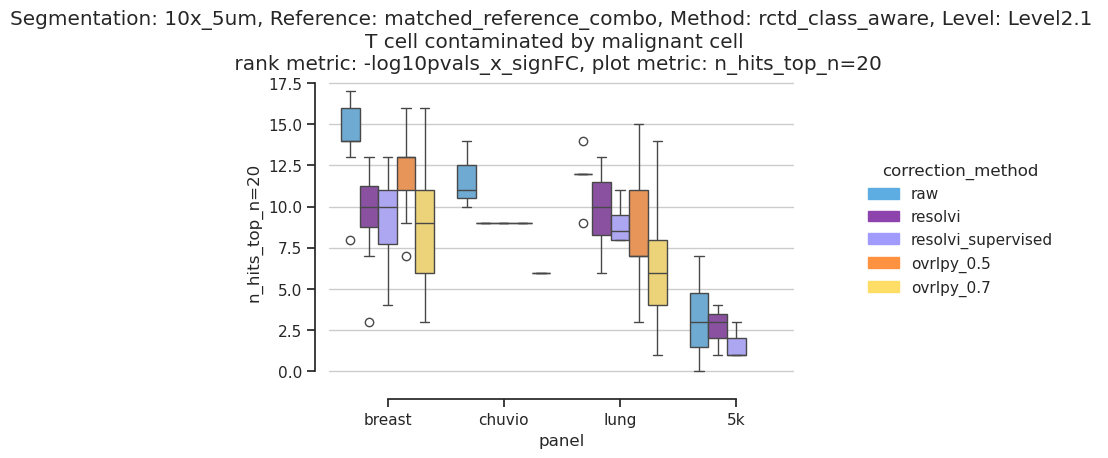

In [17]:
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        df['correction_method'] = df['correction_method'].replace({
            'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
            'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

        df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=order
                        )

        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title,y=1.05)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_correction,
            frameon=False,
        )
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()

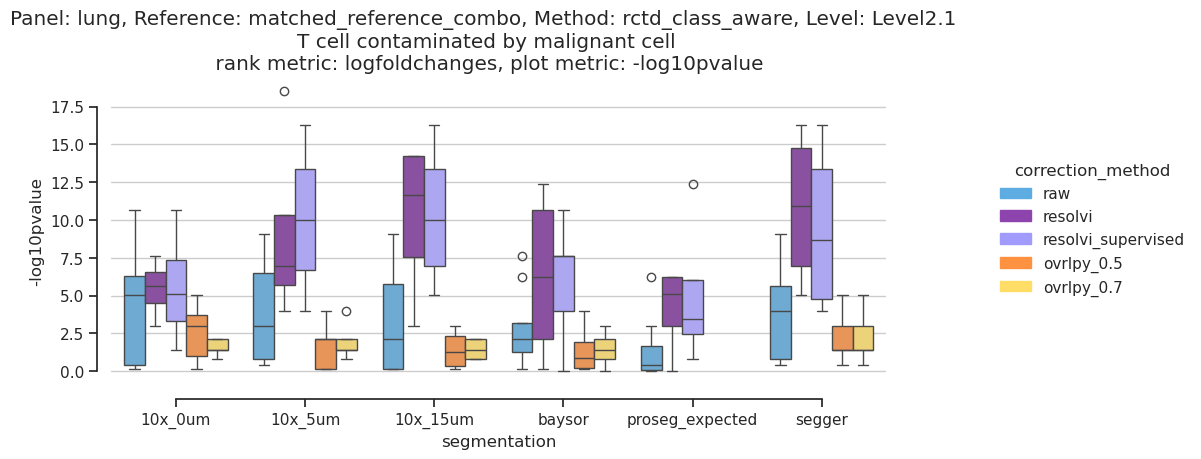

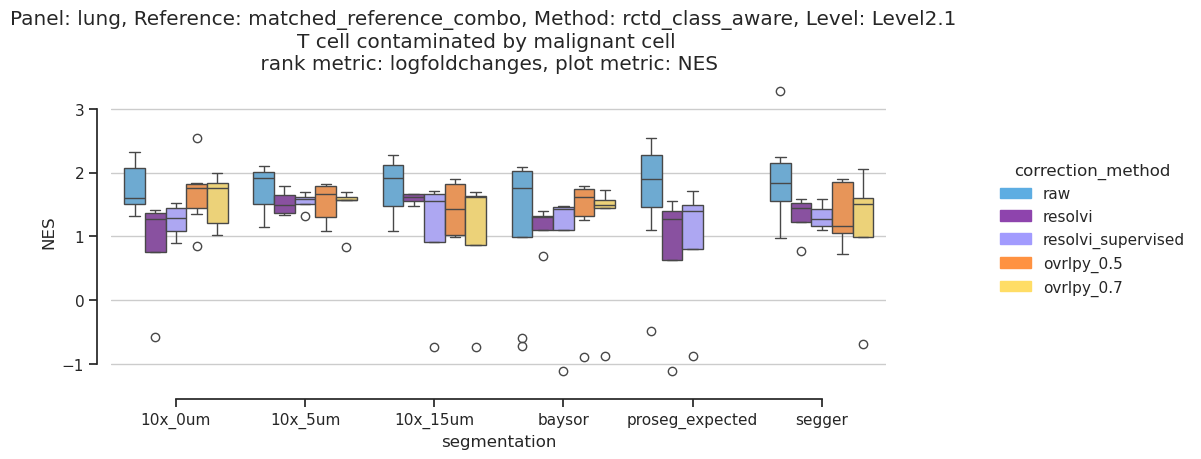

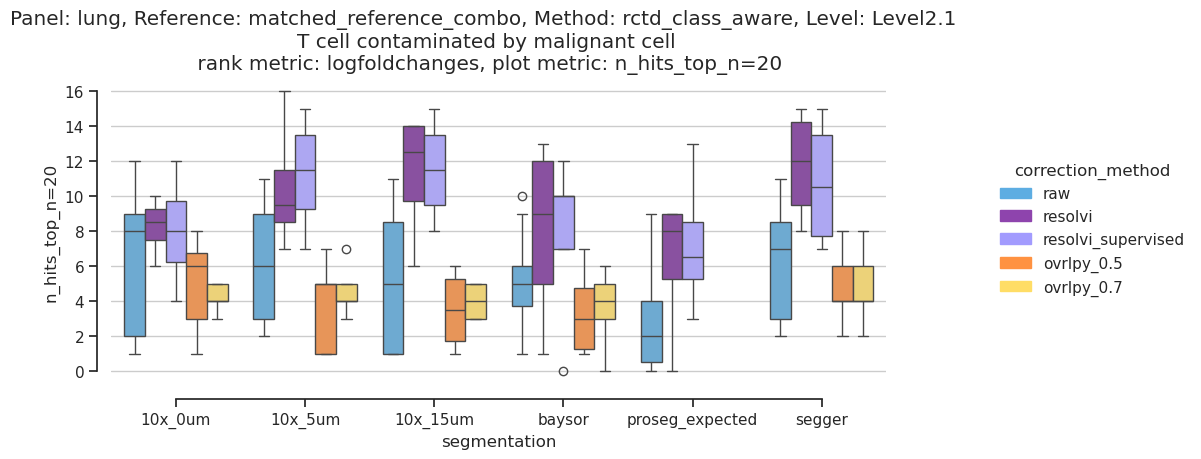

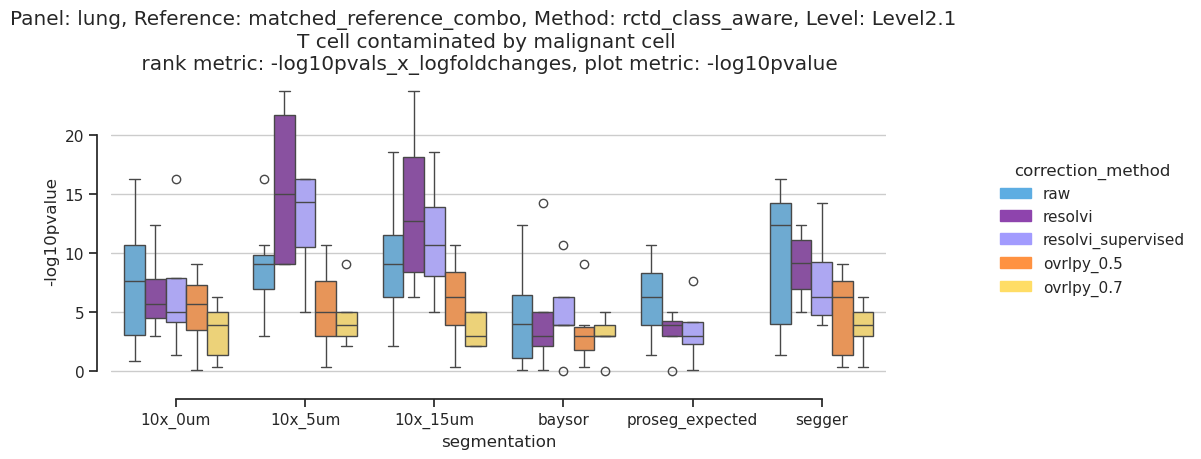

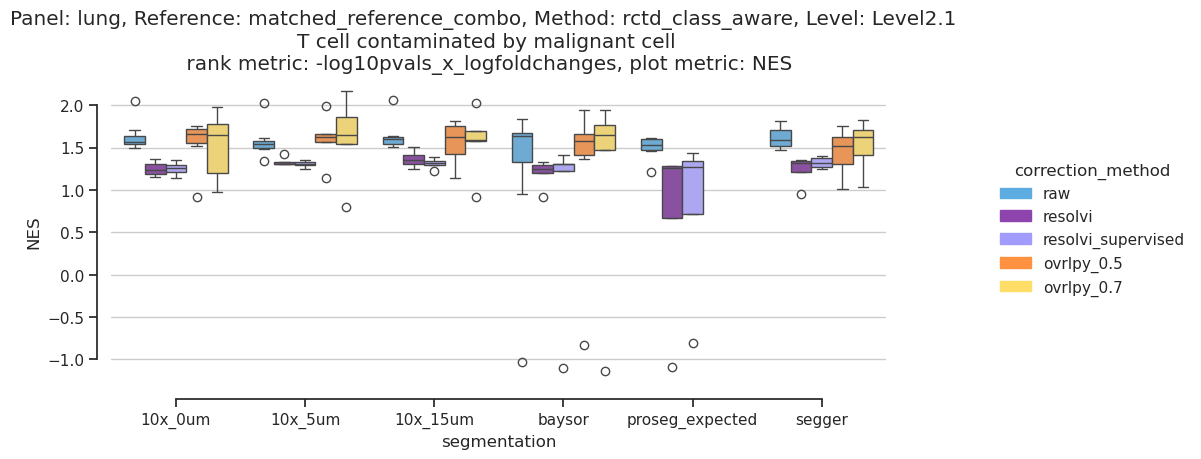

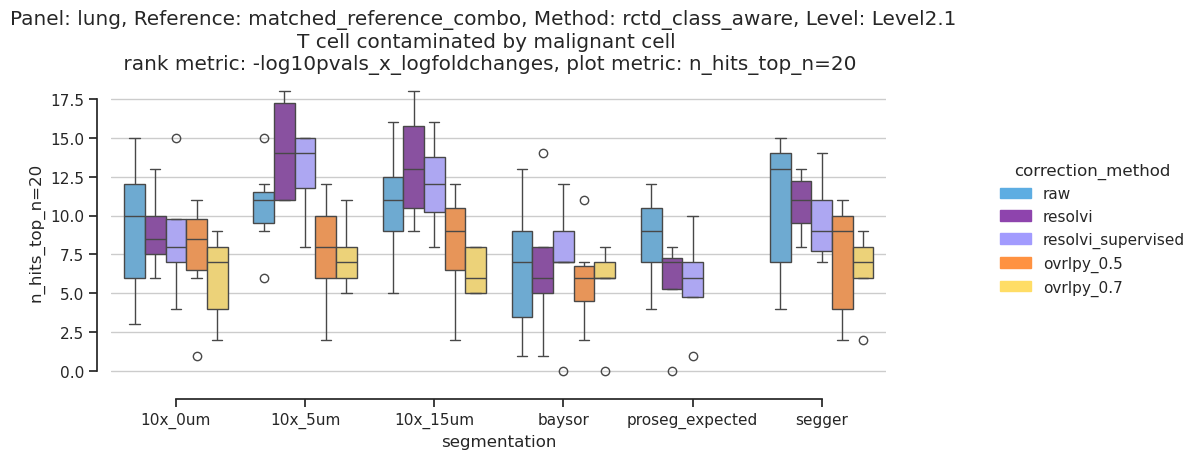

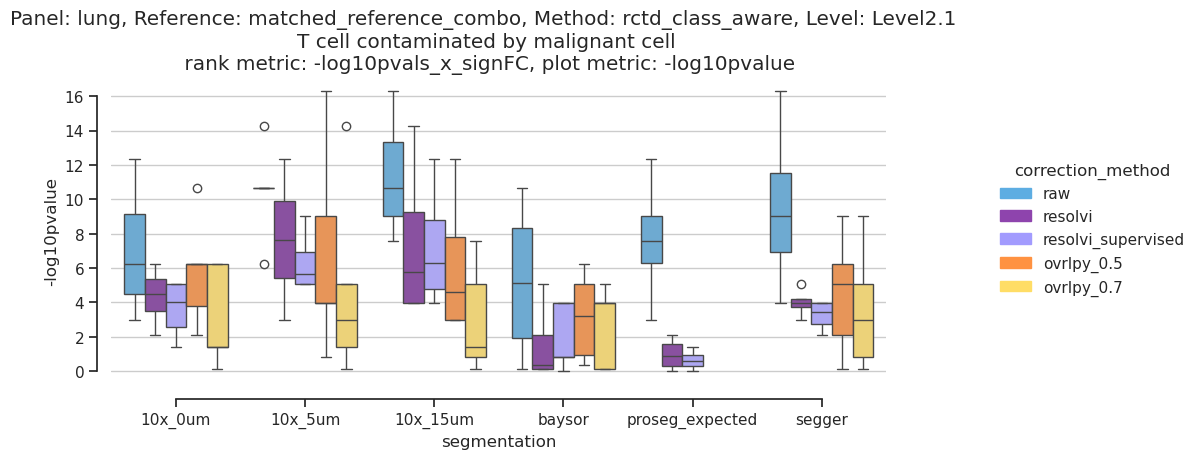

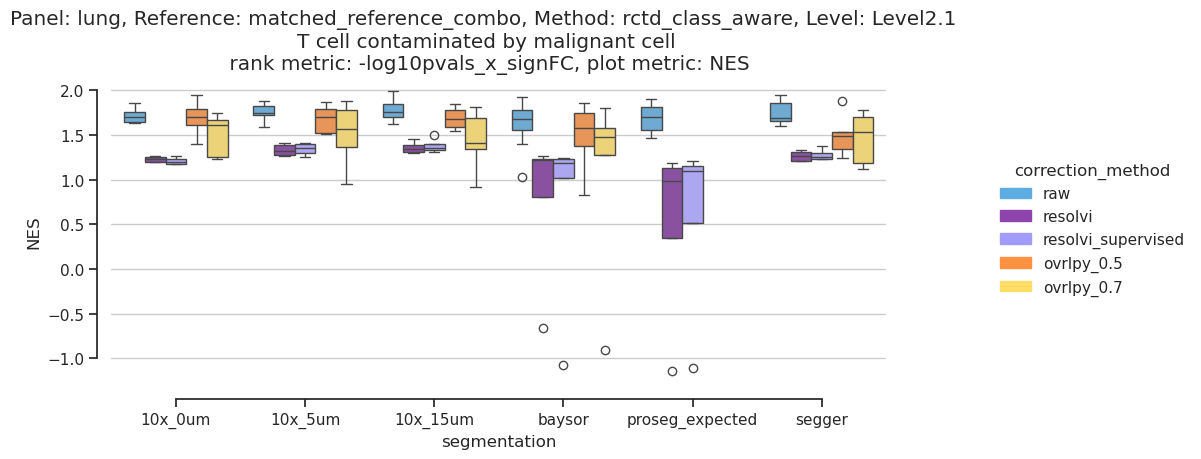

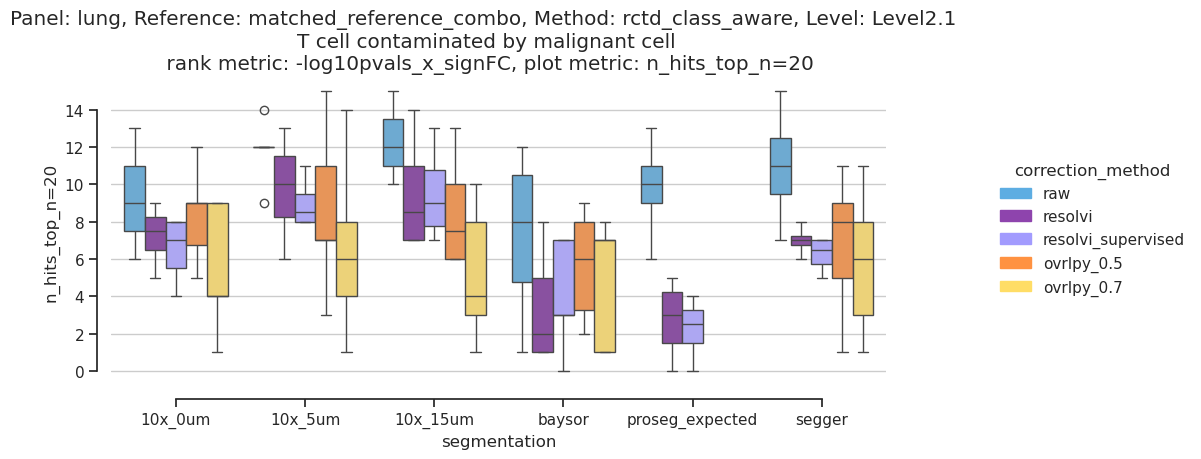

In [18]:
ref_panel = 'lung'
cti = 'T cell'
ctj = 'malignant cell'

palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        df['correction_method'] = df['correction_method'].replace({
            'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
            'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

        df = df.query(f"panel == '{ref_panel}' and cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Panel: {ref_panel}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(10, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                        )

        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title,y=1.05)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_correction,
            frameon=False,
        )
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()

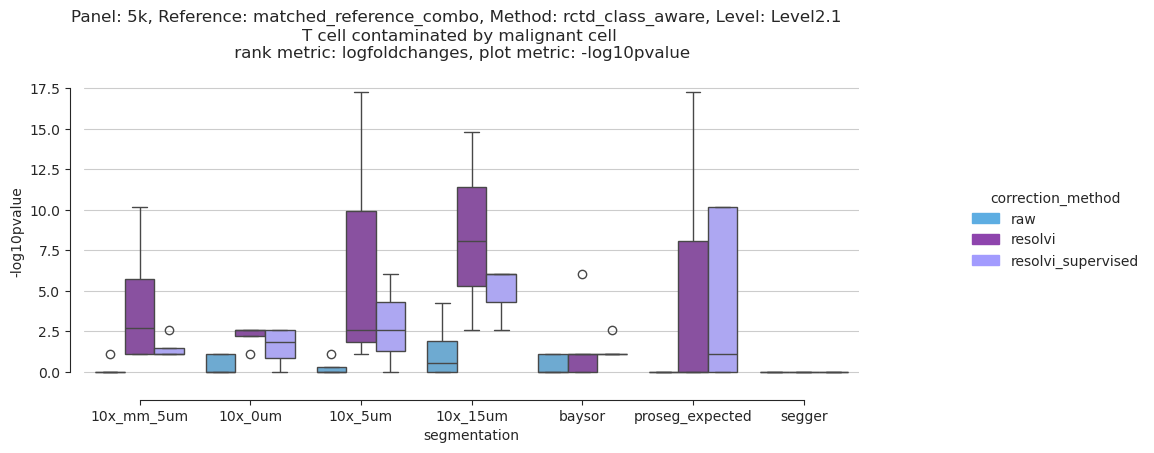

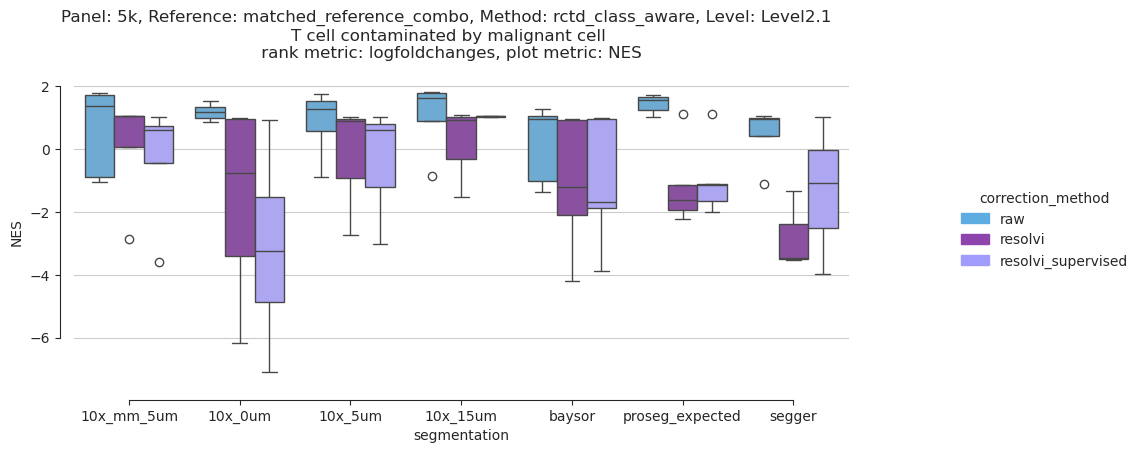

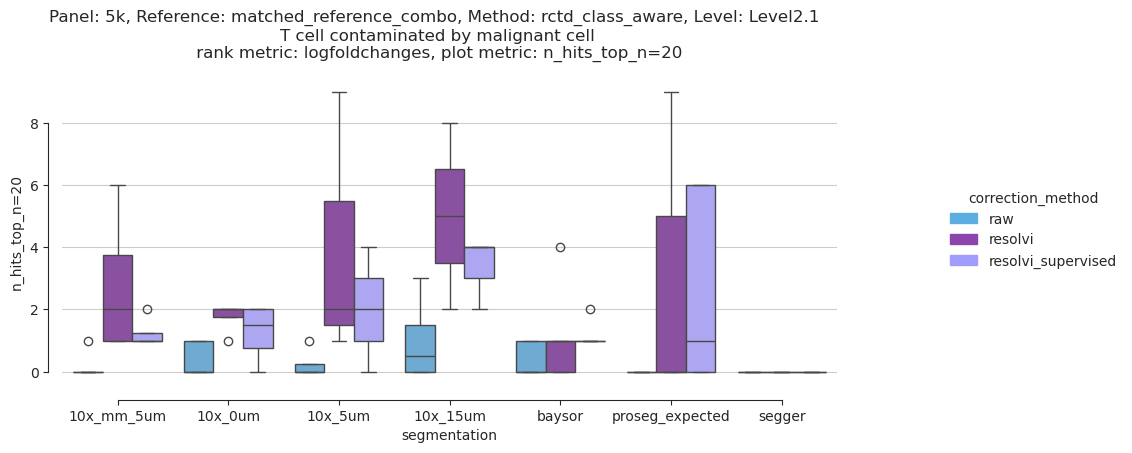

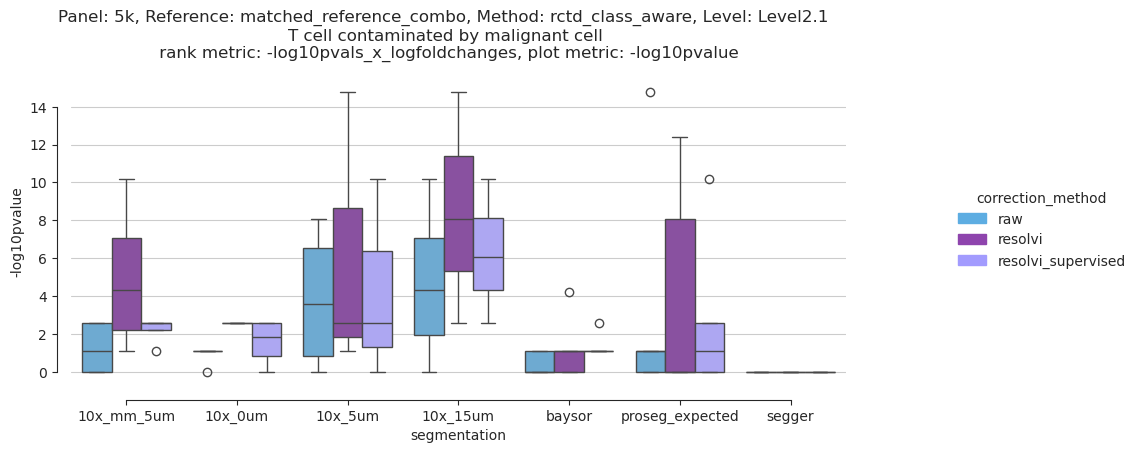

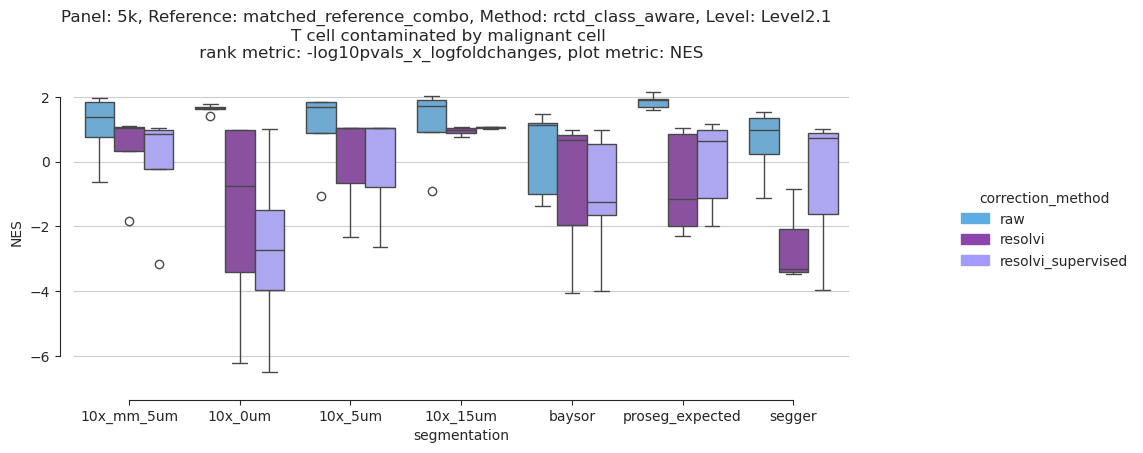

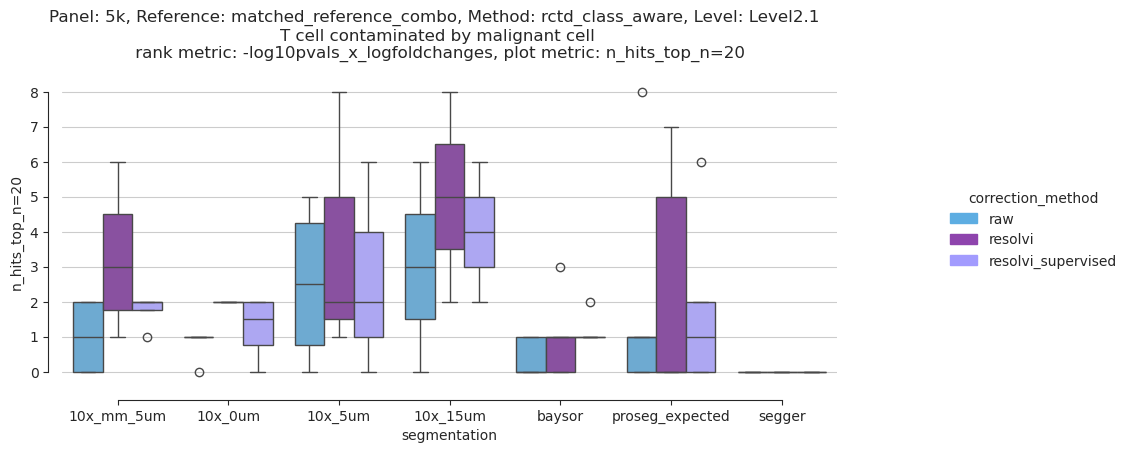

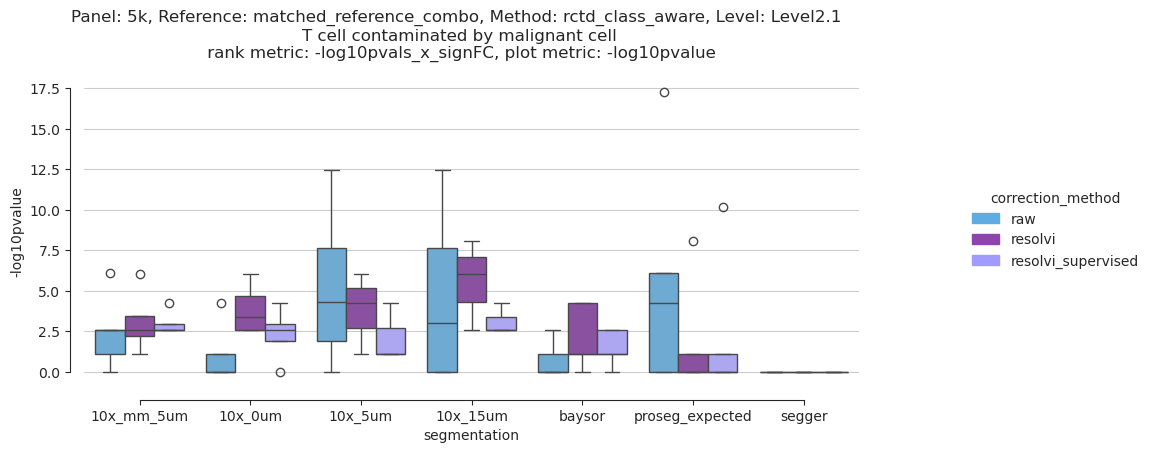

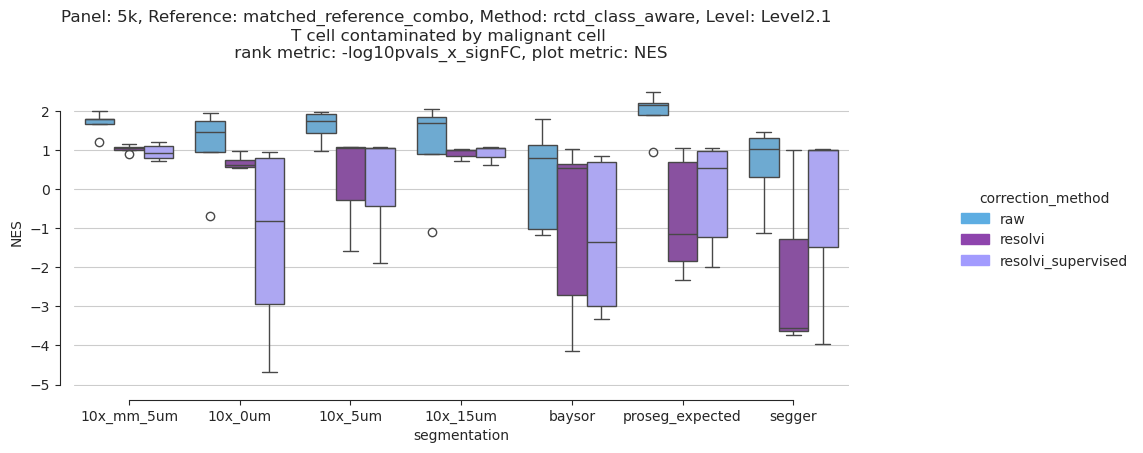

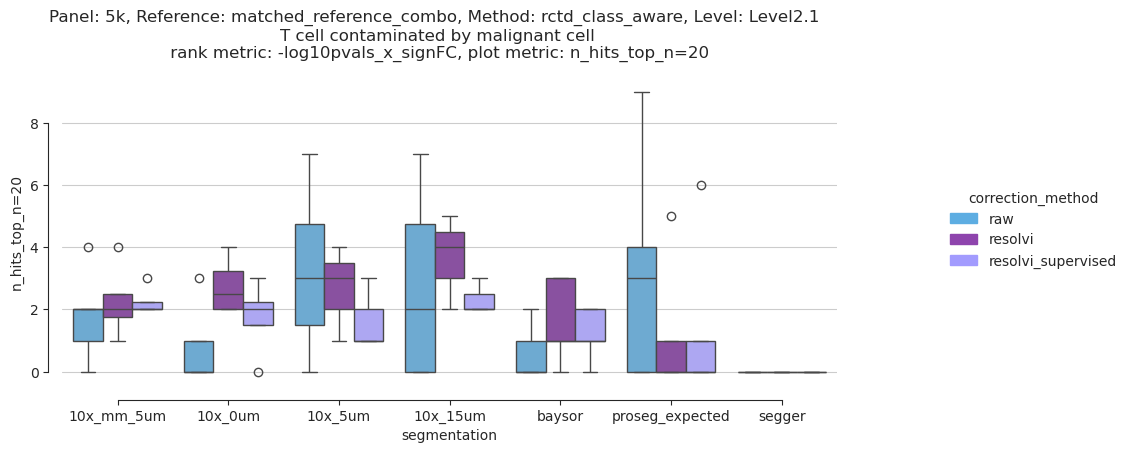

In [8]:
ref_panel = '5k'
cti = 'T cell'
ctj = 'malignant cell'

palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        df['correction_method'] = df['correction_method'].replace({
            'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
            'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

        df = df.query(f"panel == '{ref_panel}' and cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Panel: {ref_panel}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(10, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                        )

        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title,y=1.05)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_correction,
            frameon=False,
        )
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()

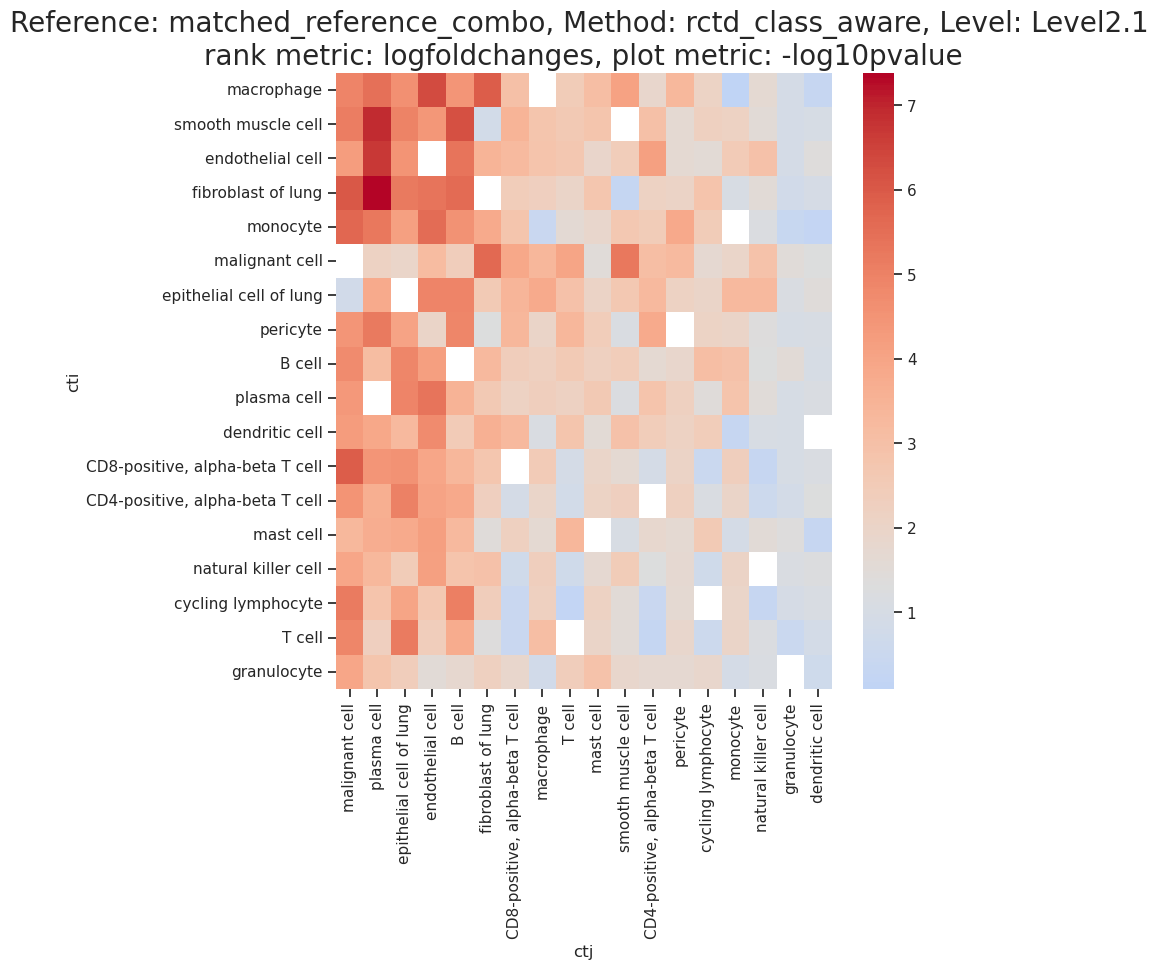

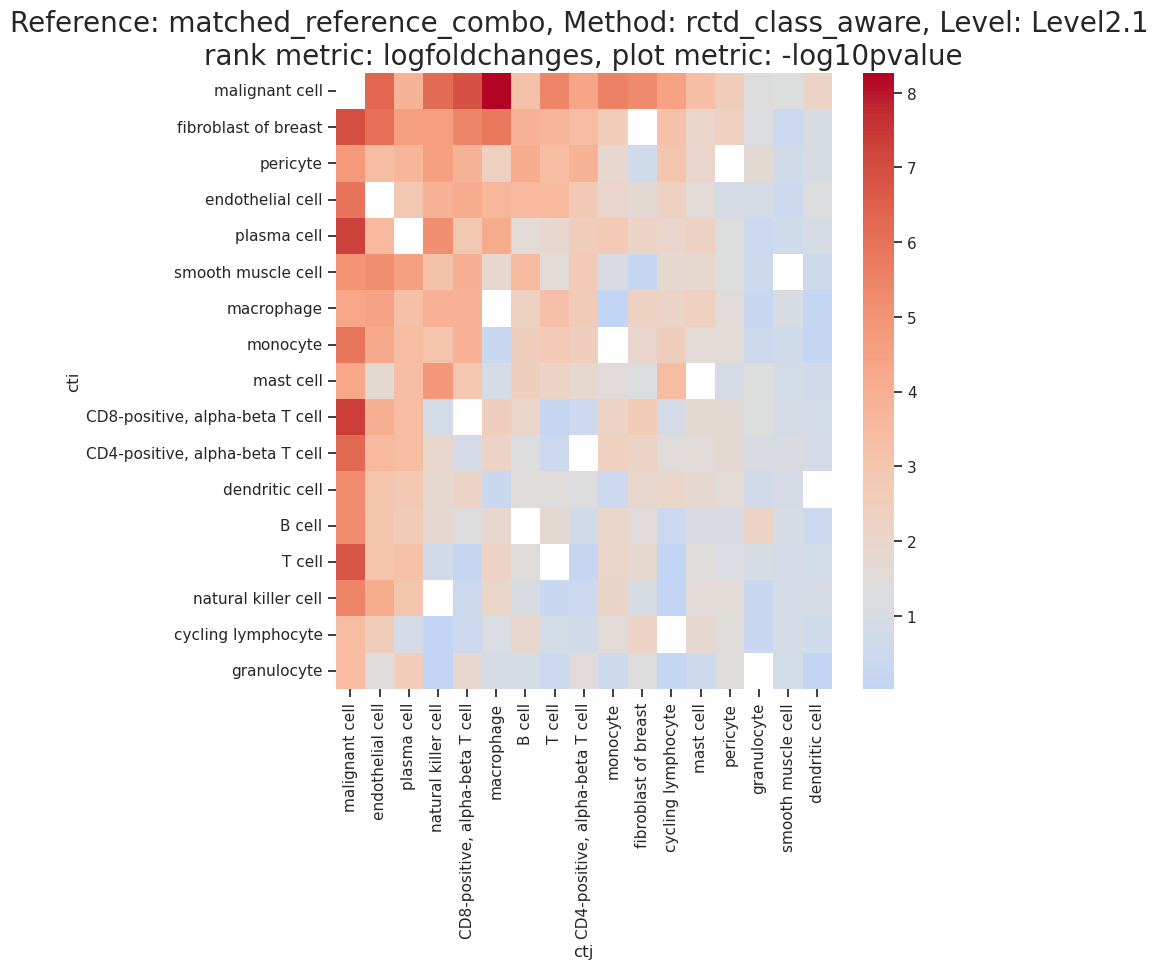

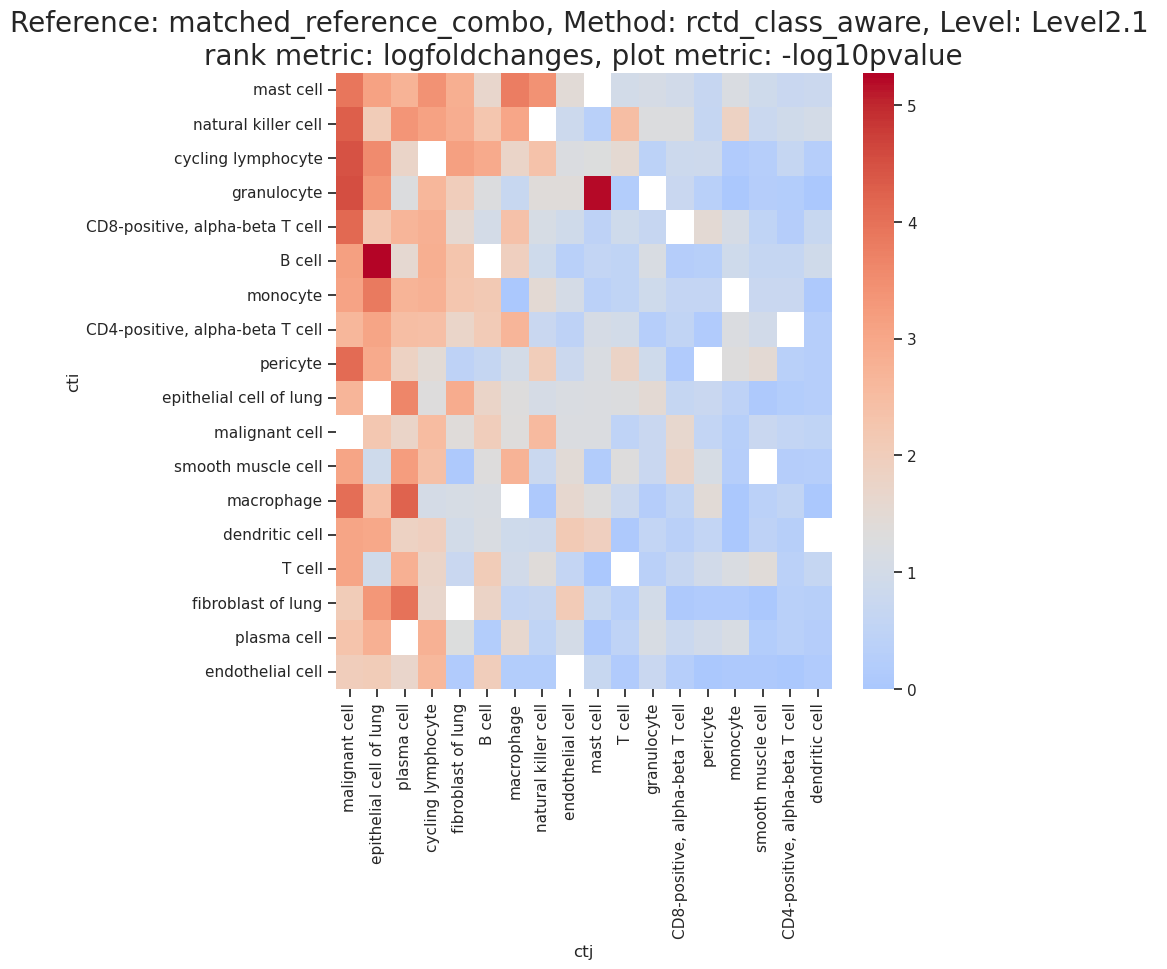

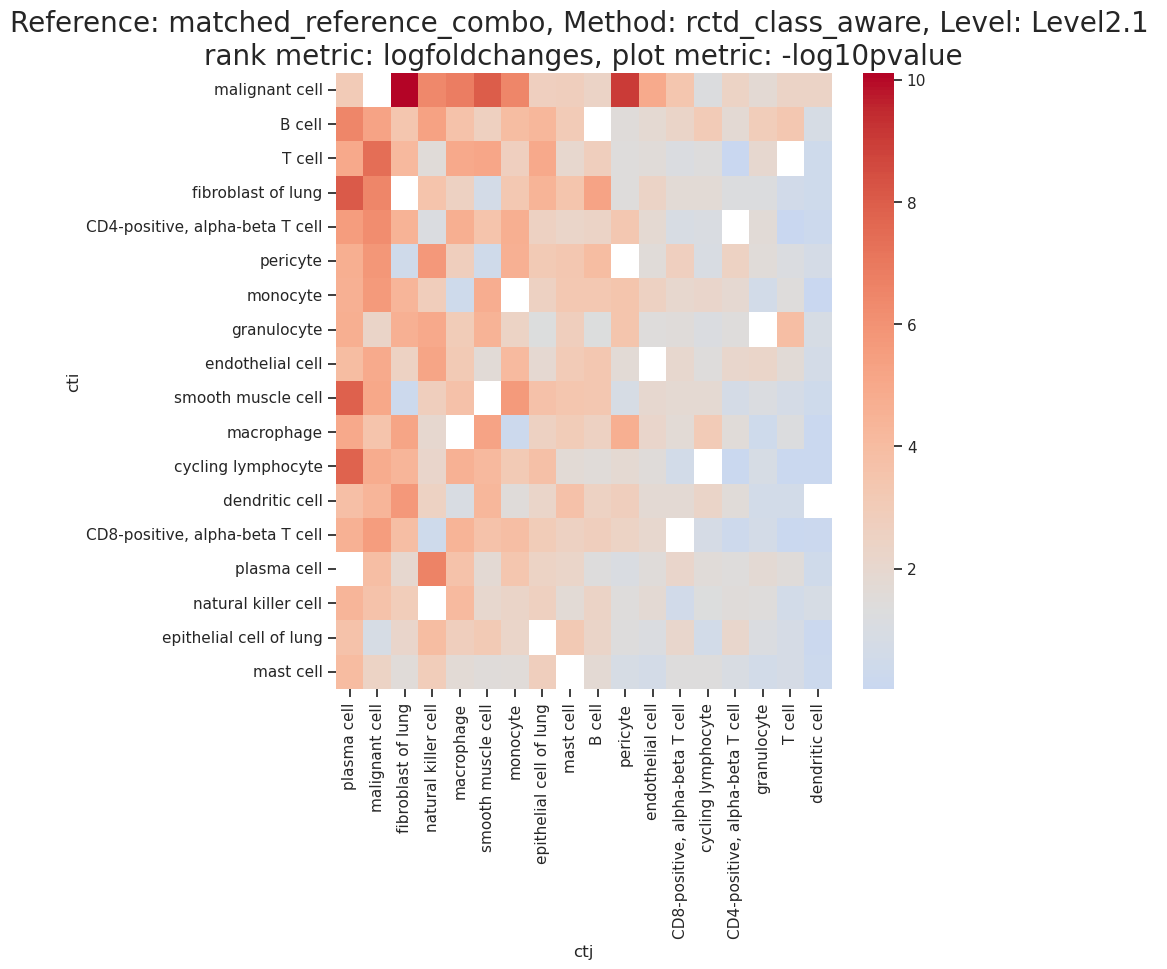

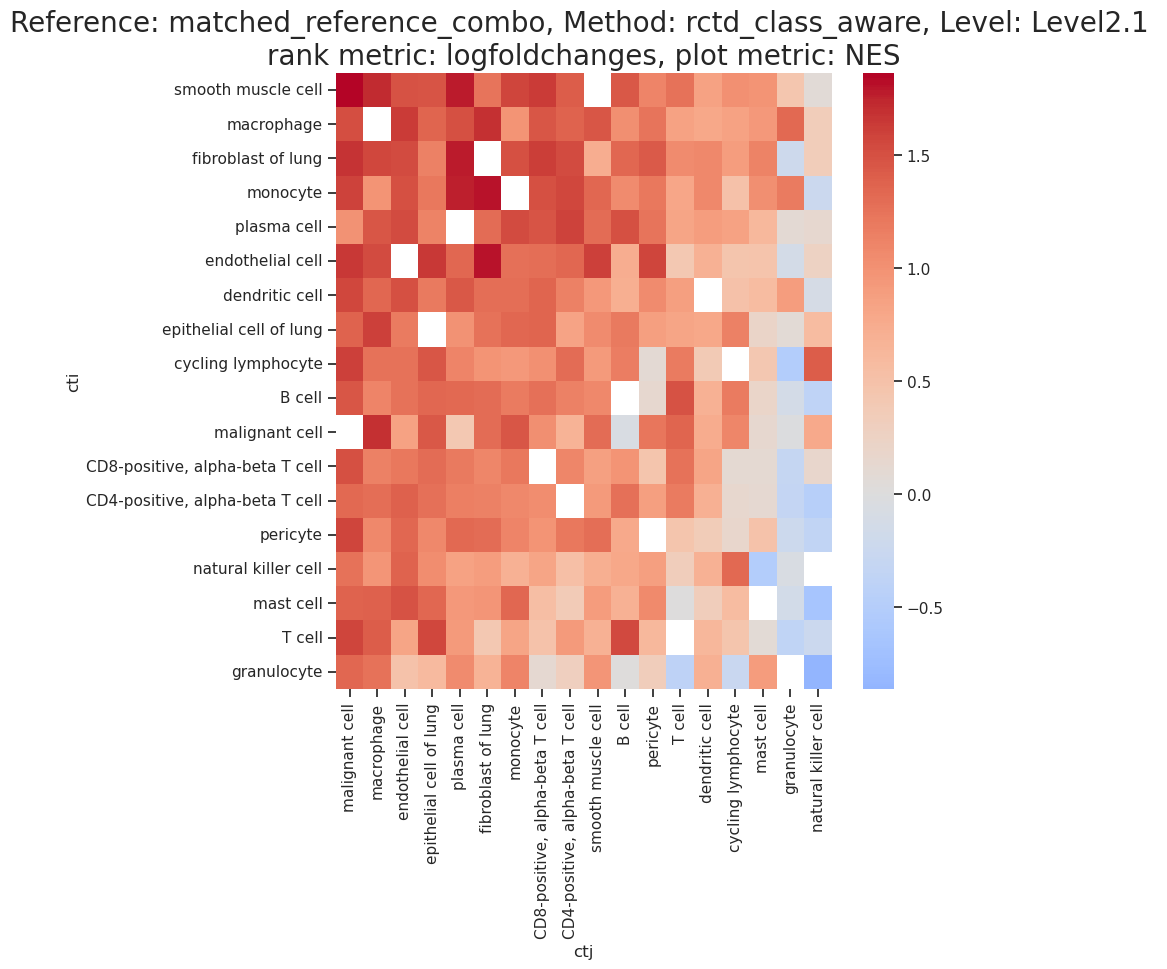

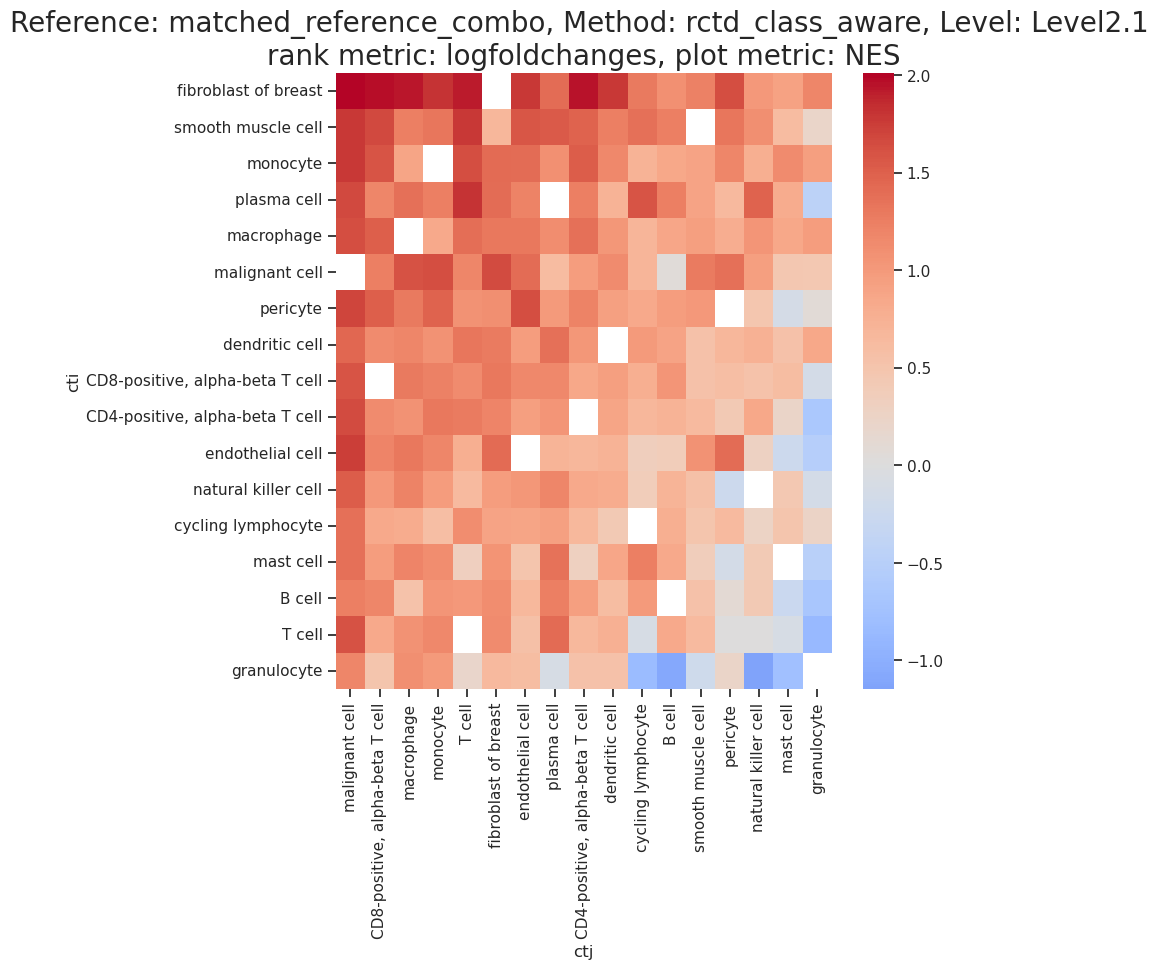

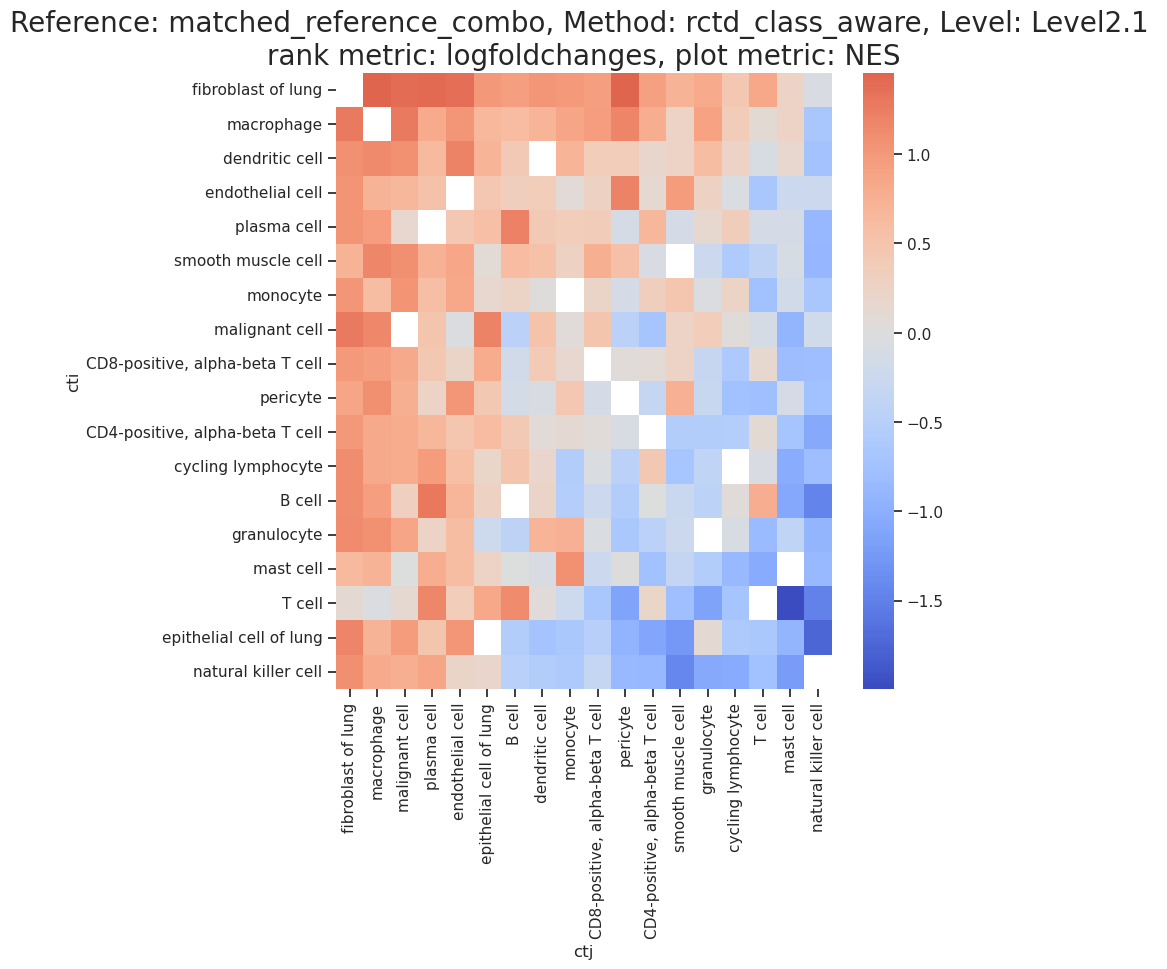

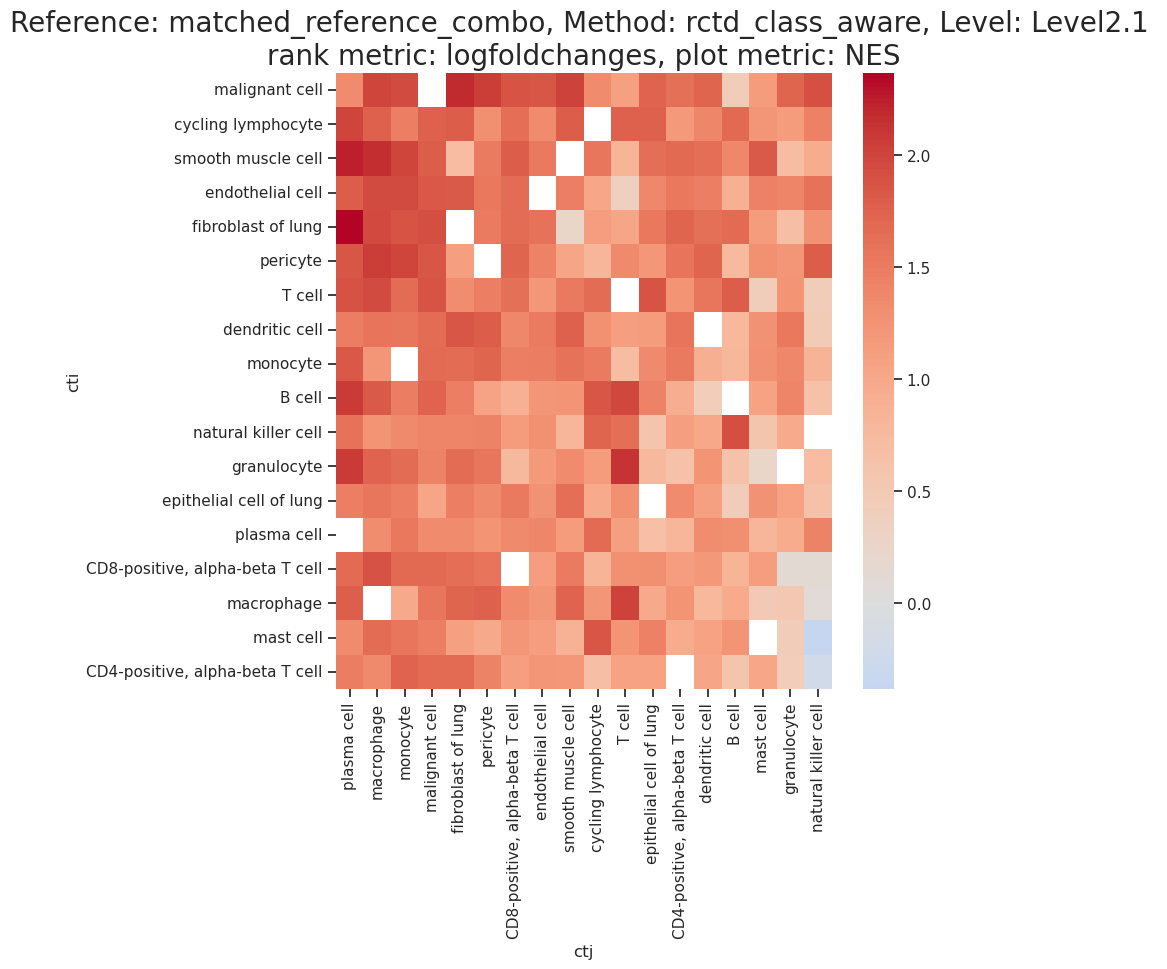

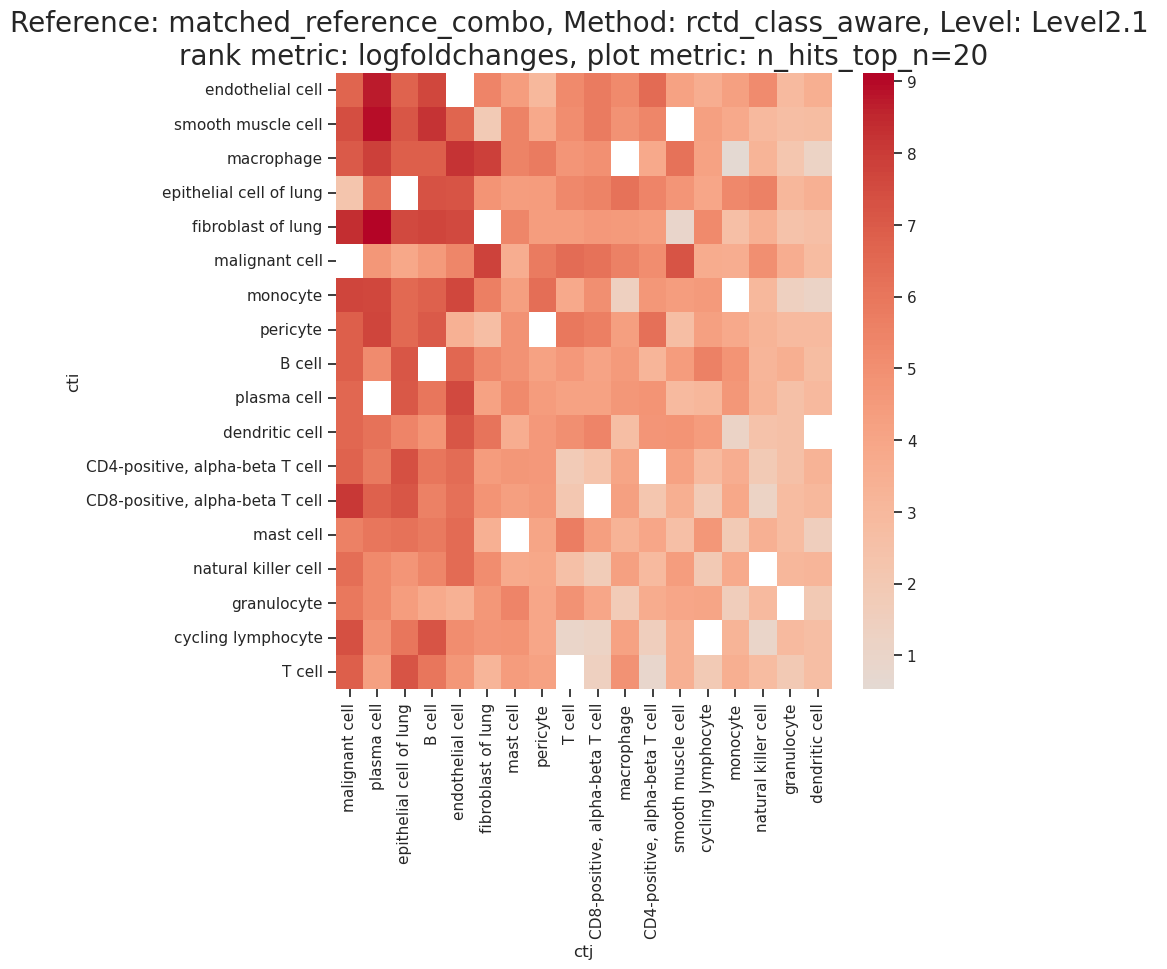

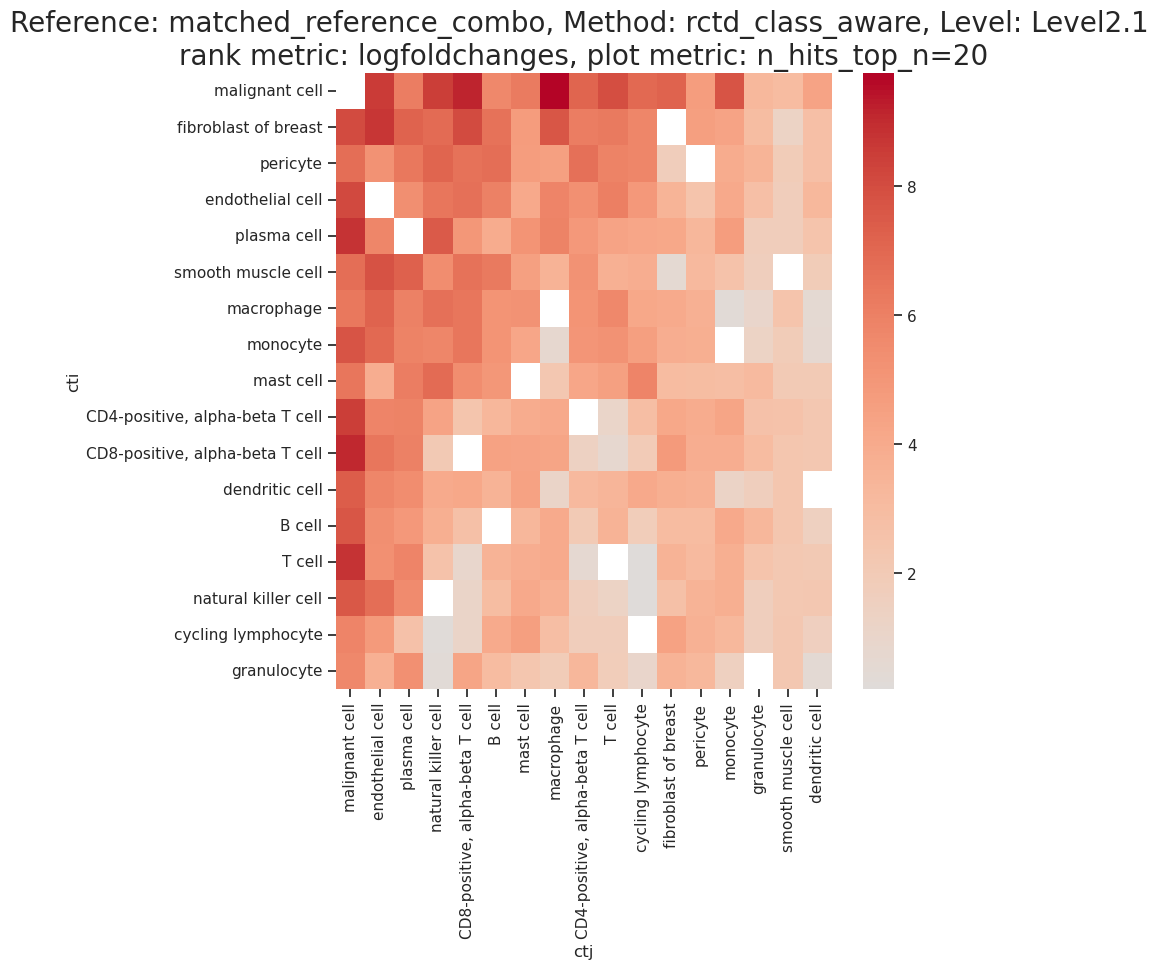

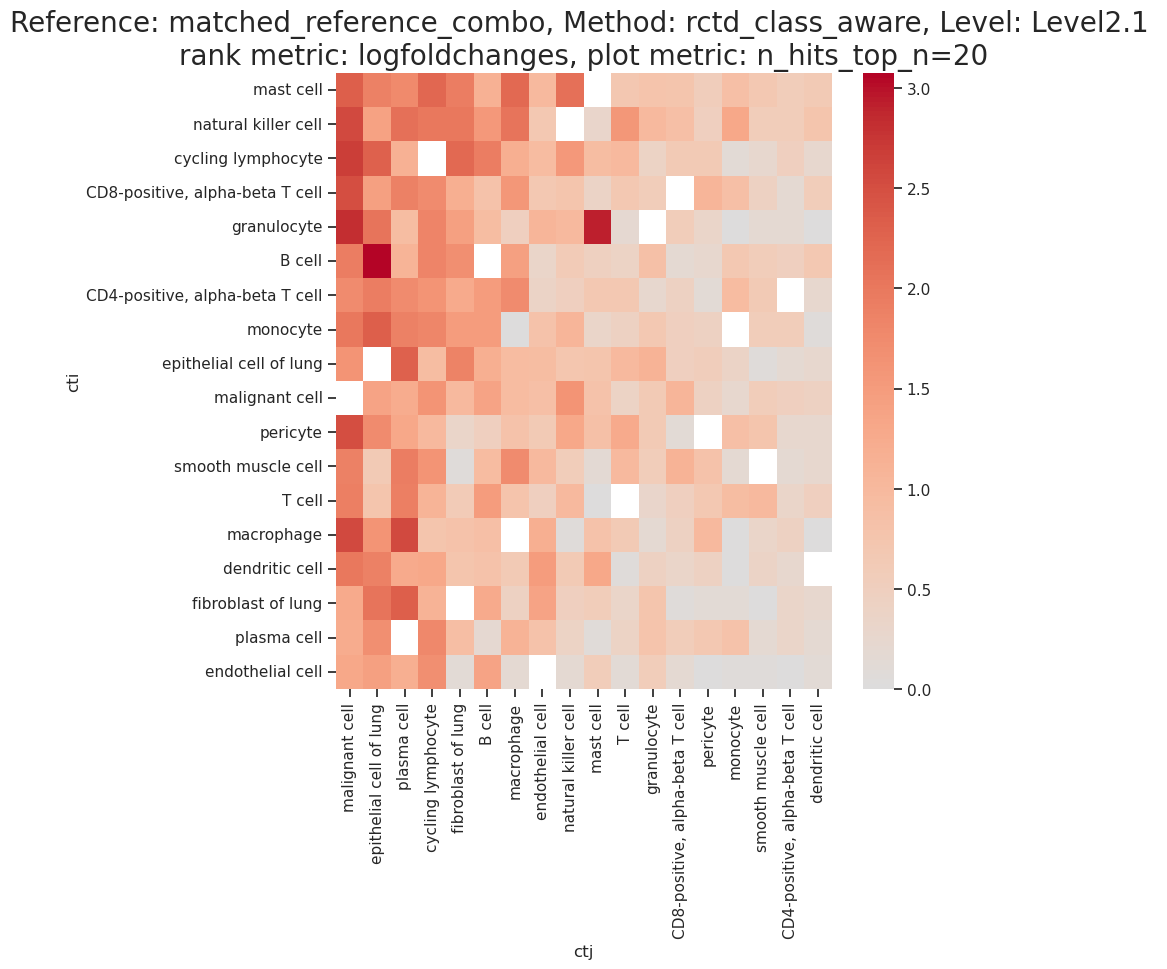

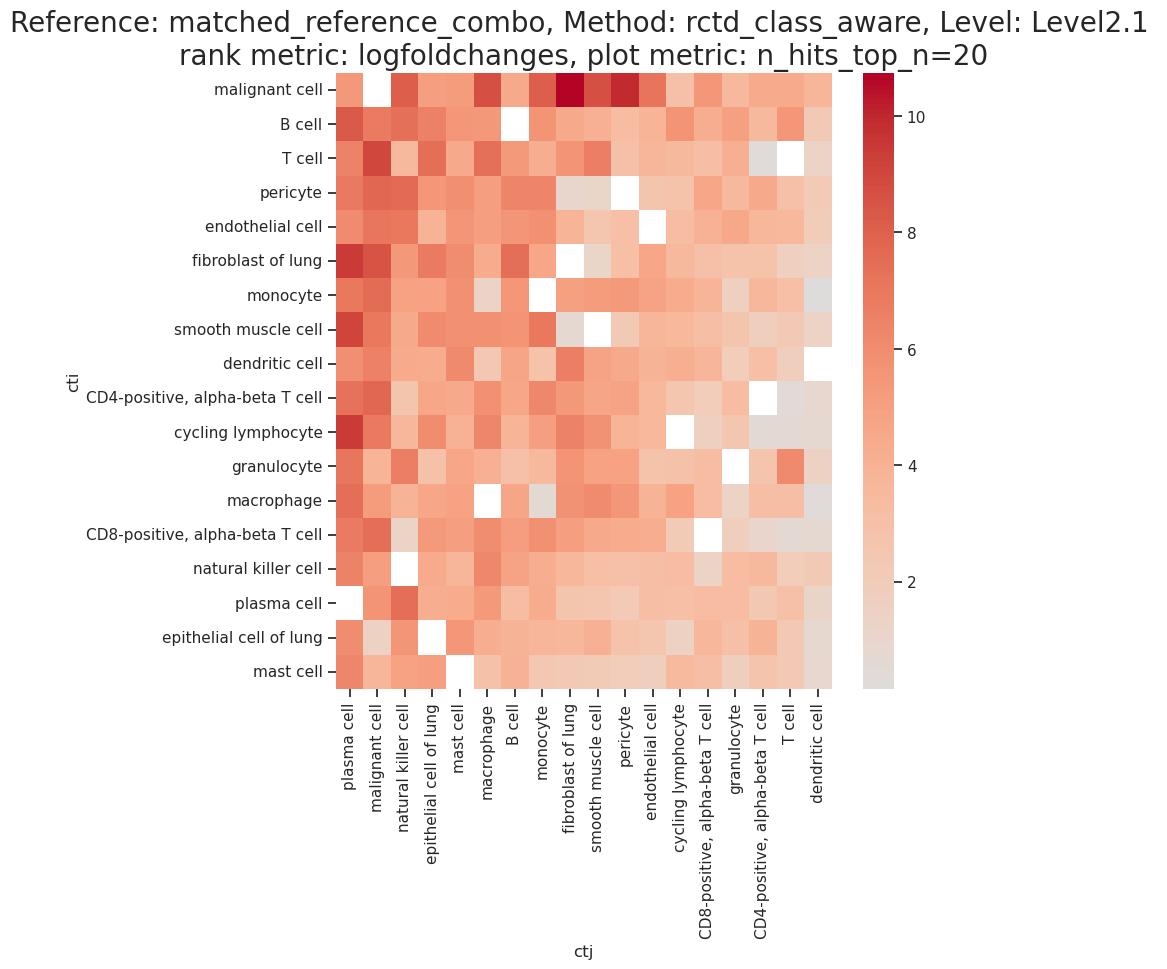

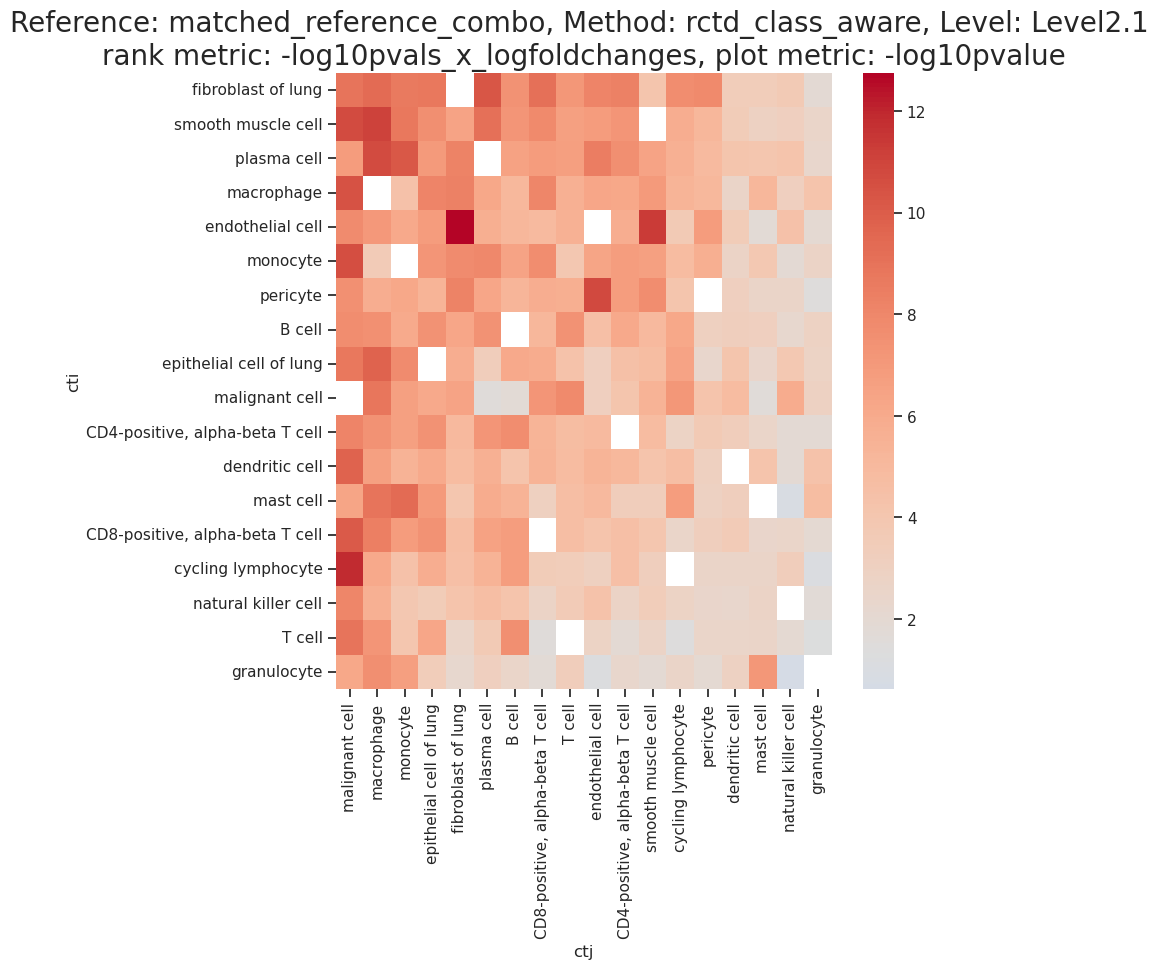

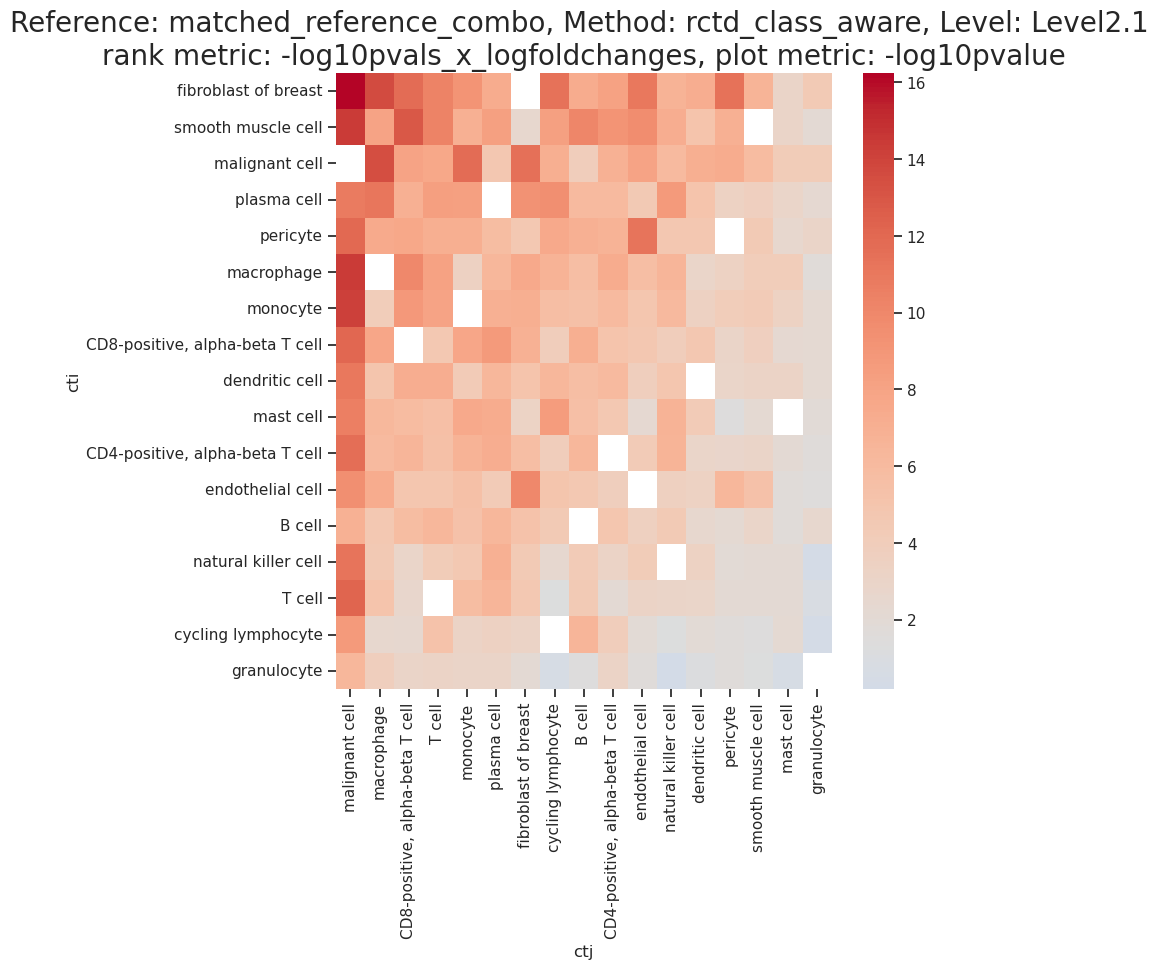

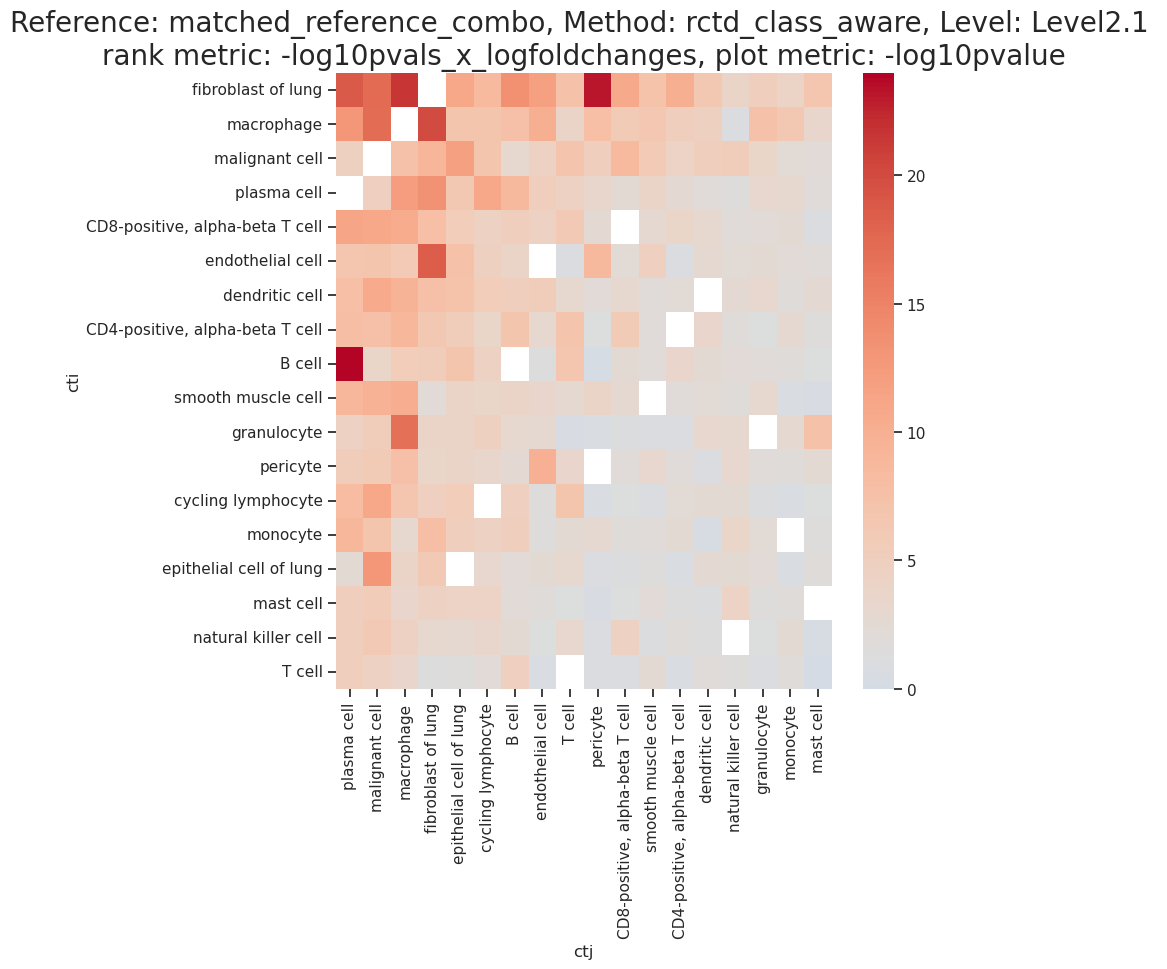

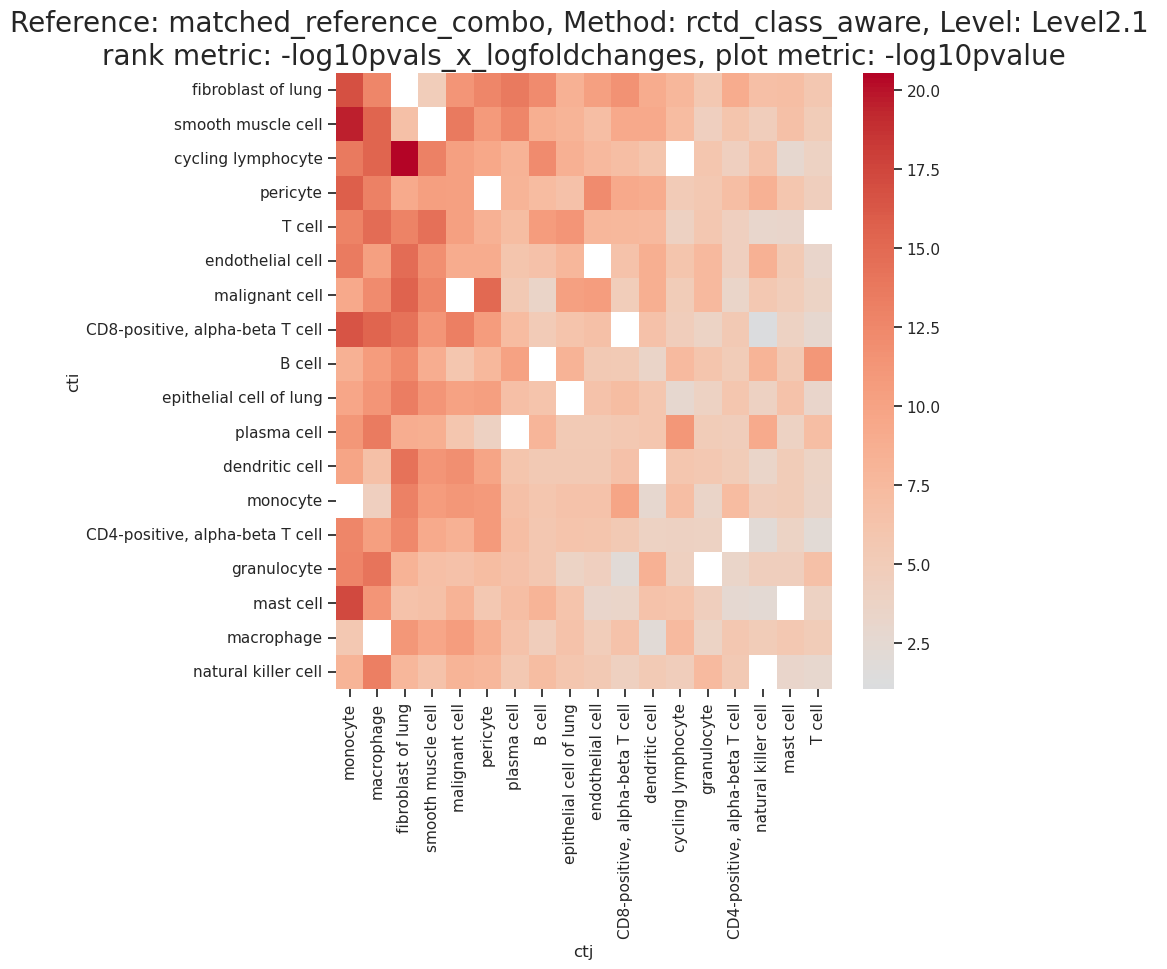

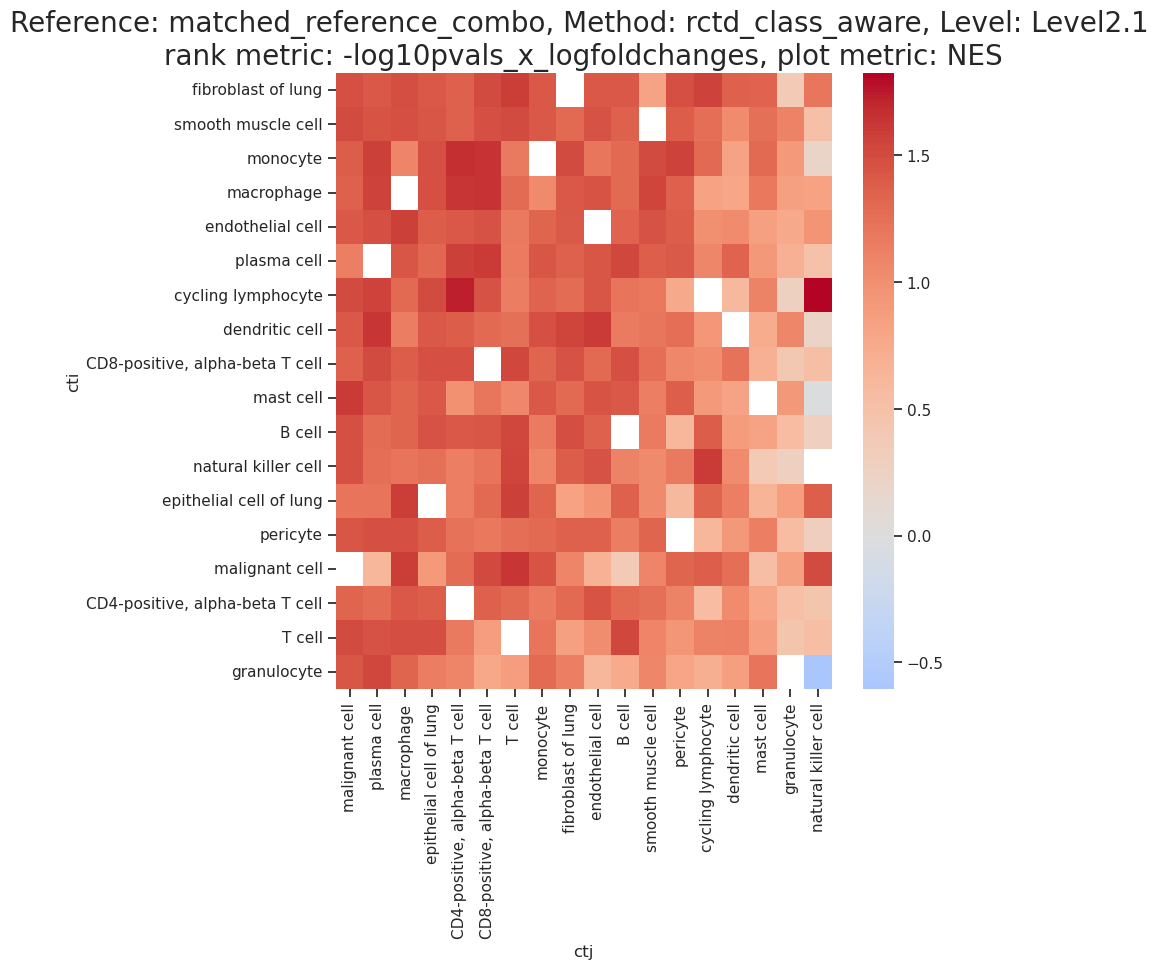

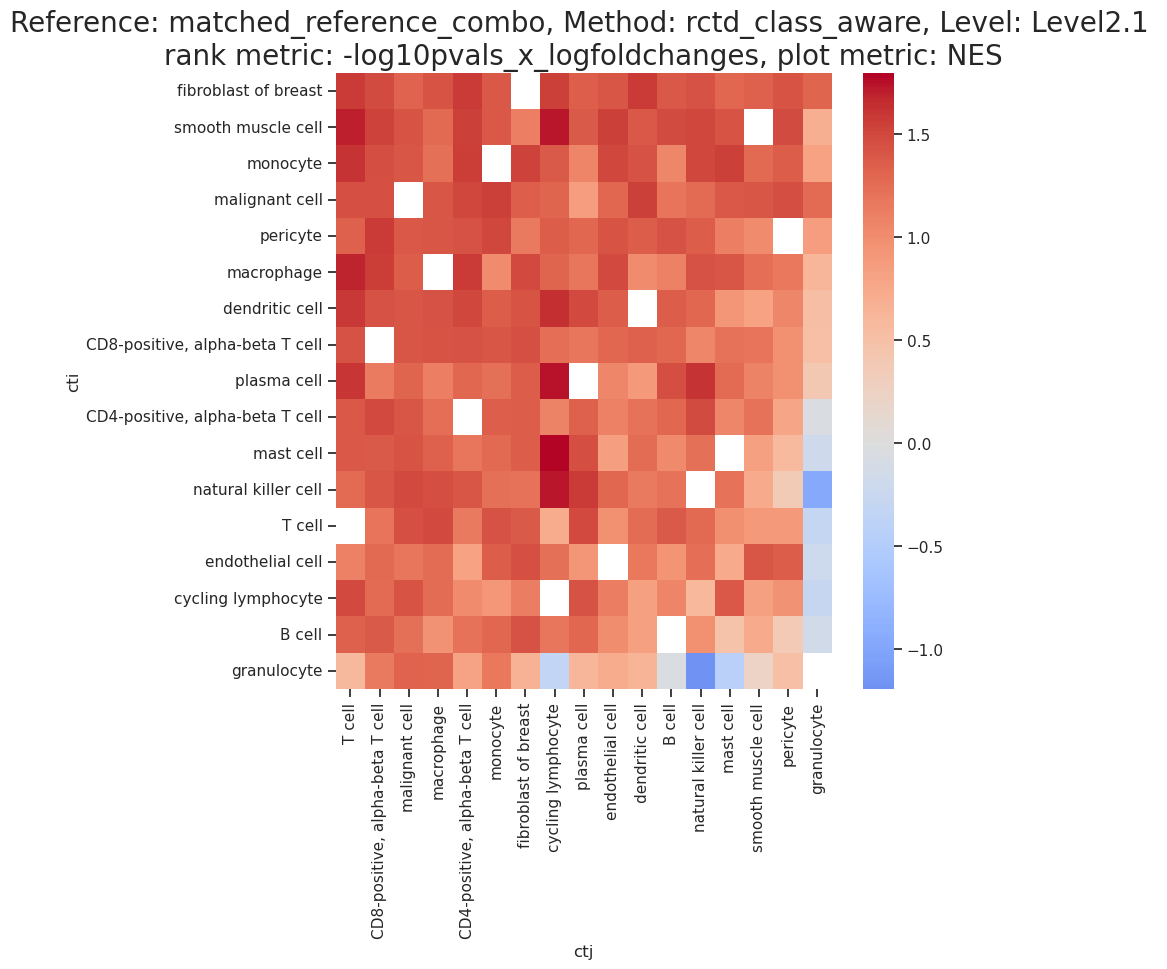

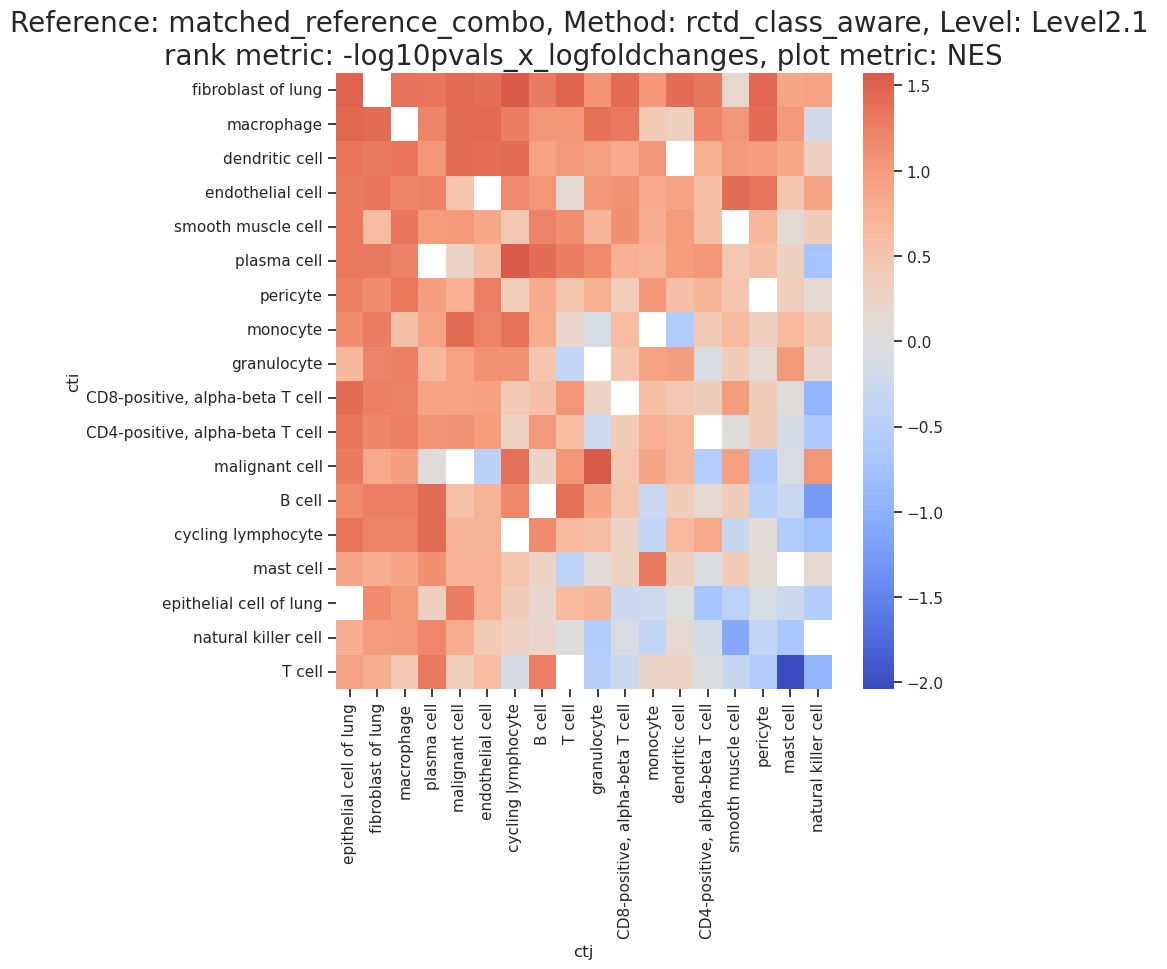

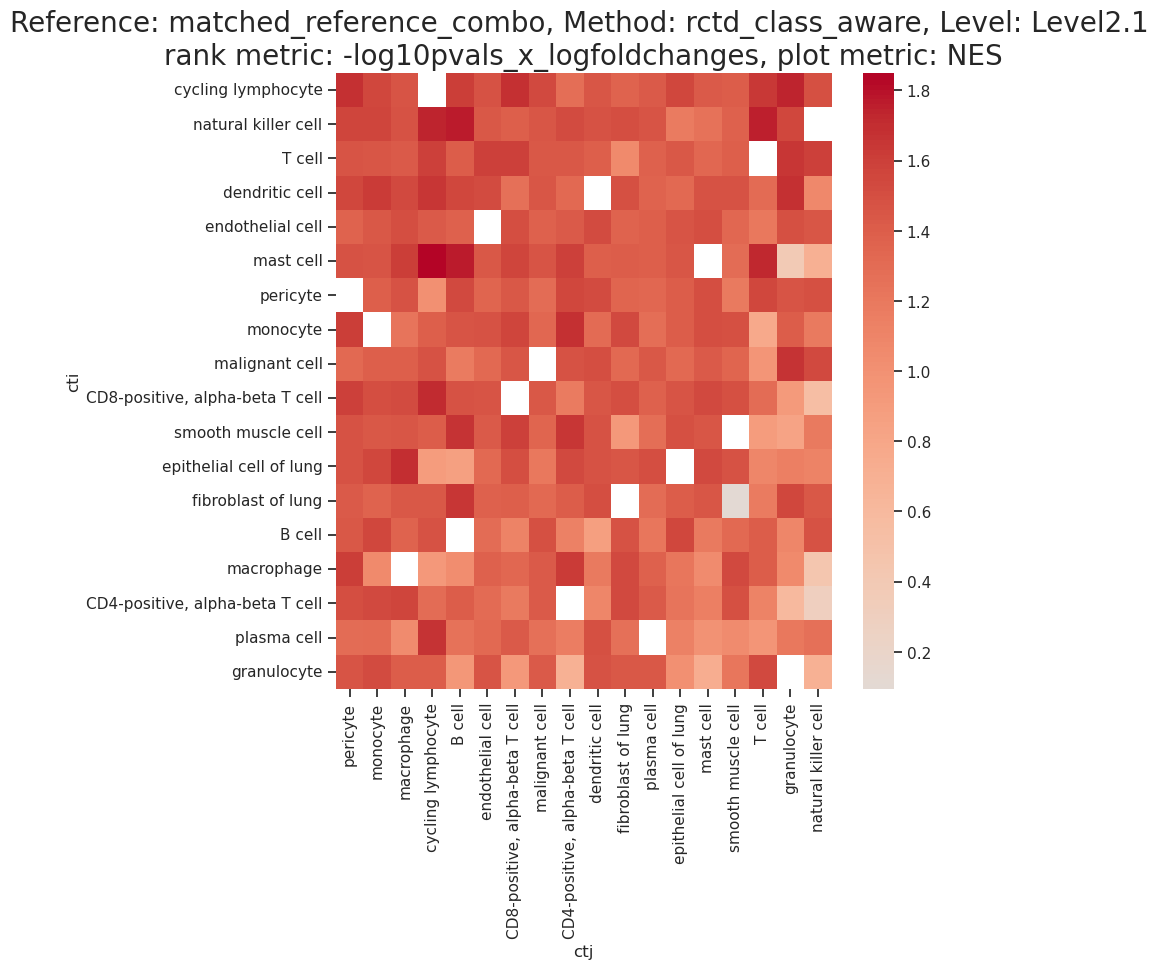

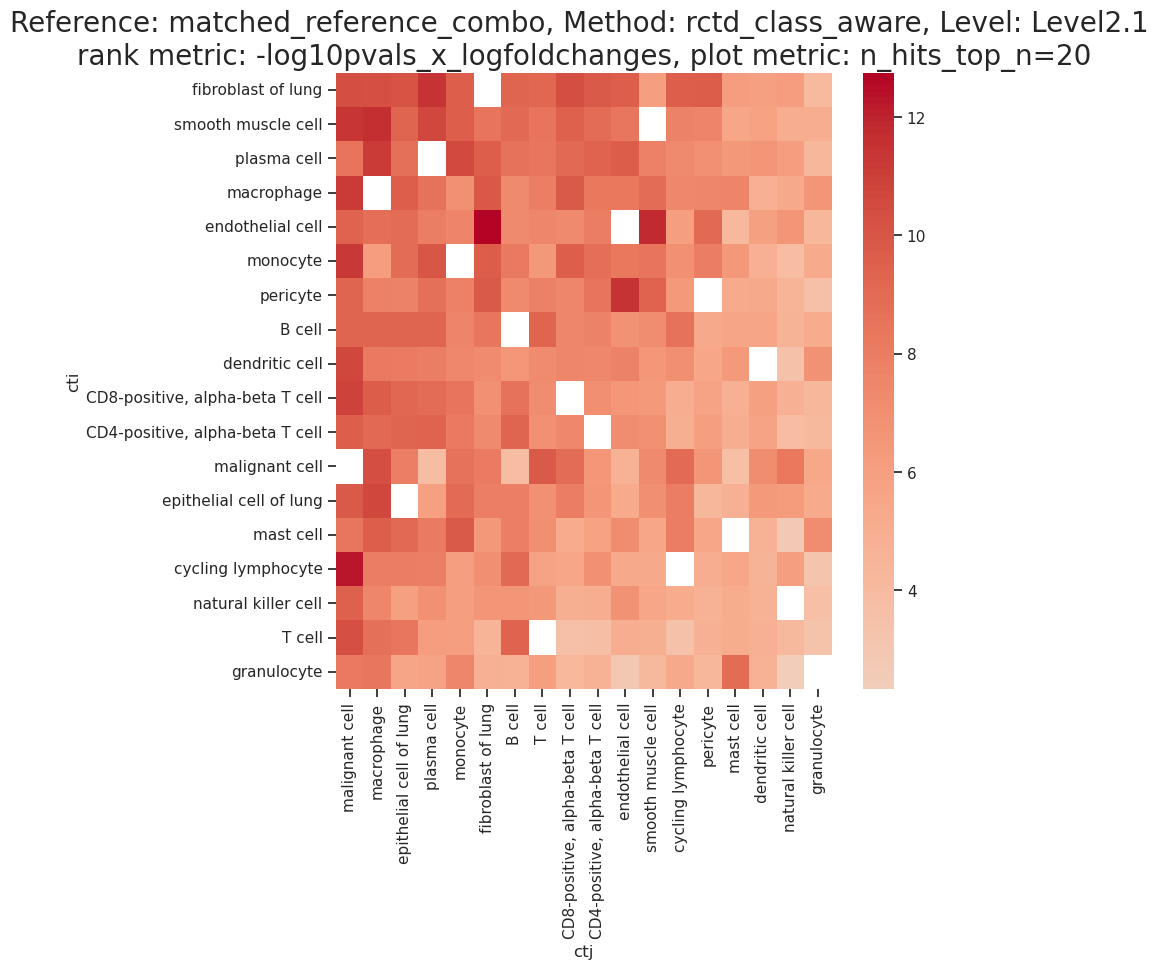

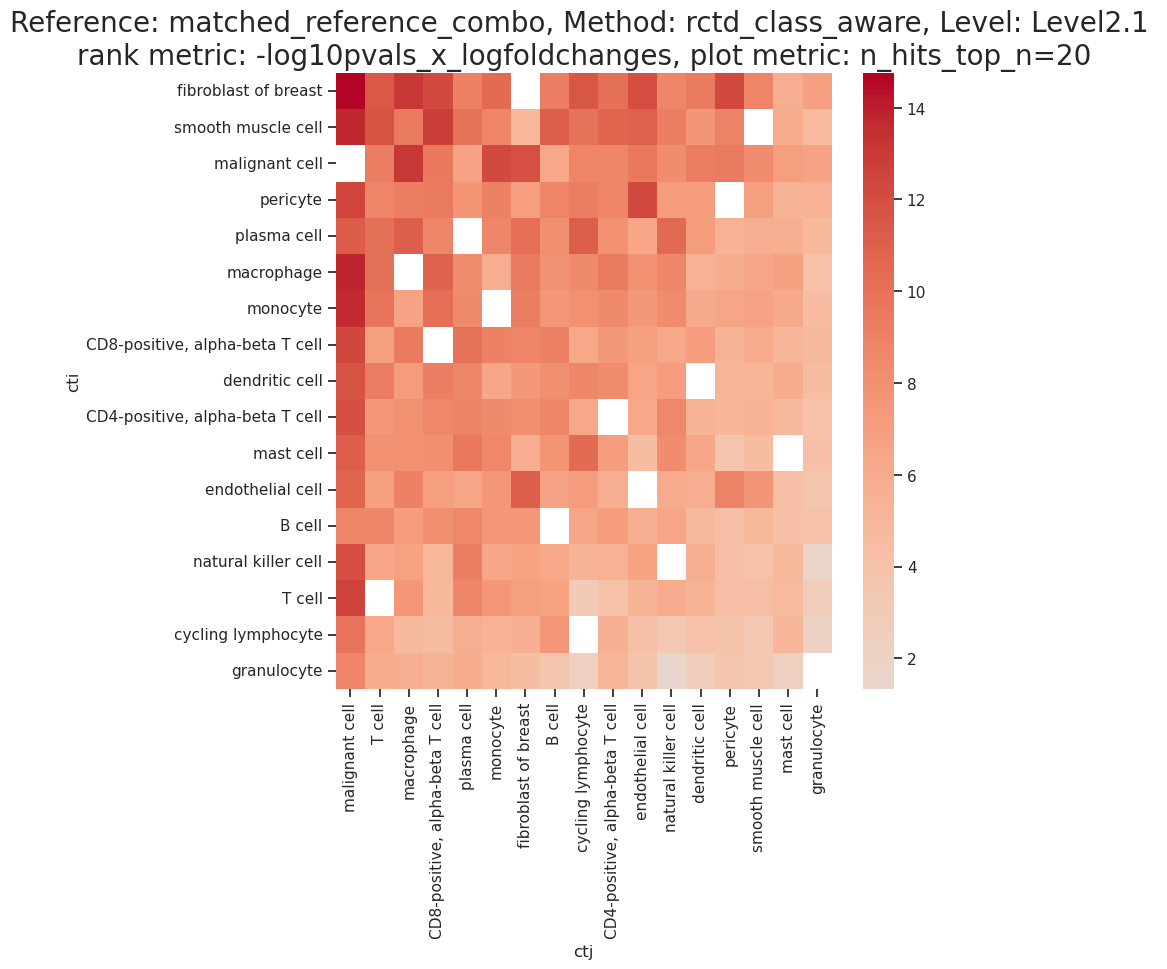

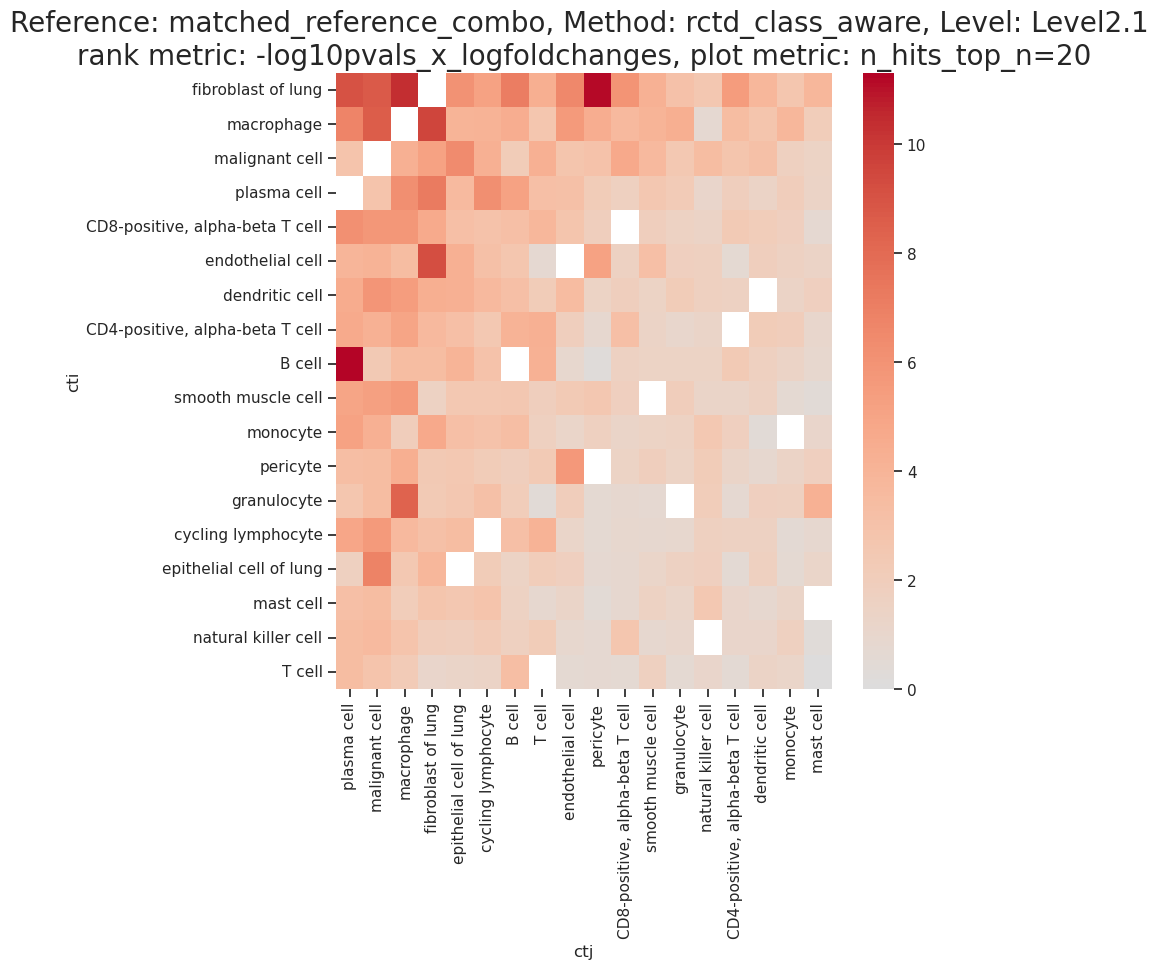

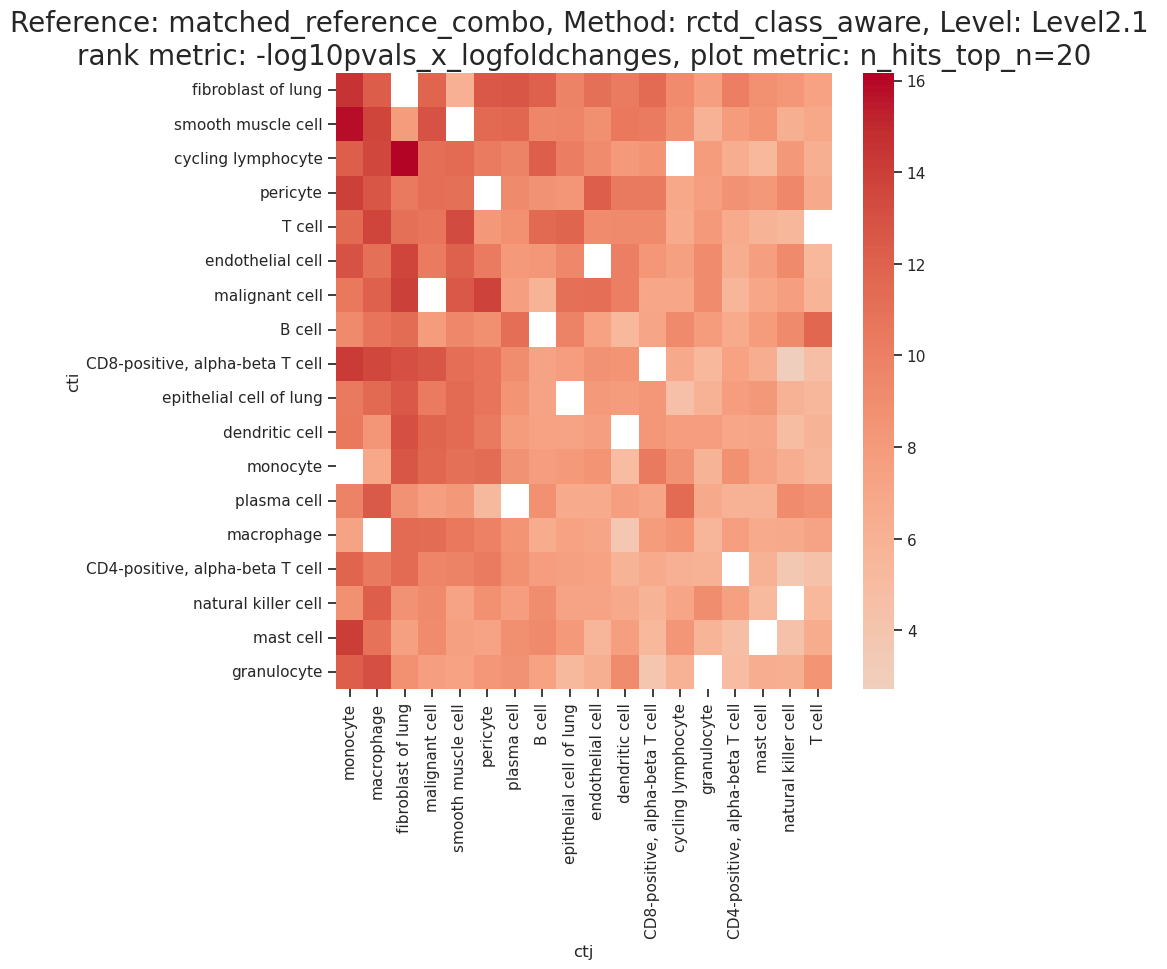

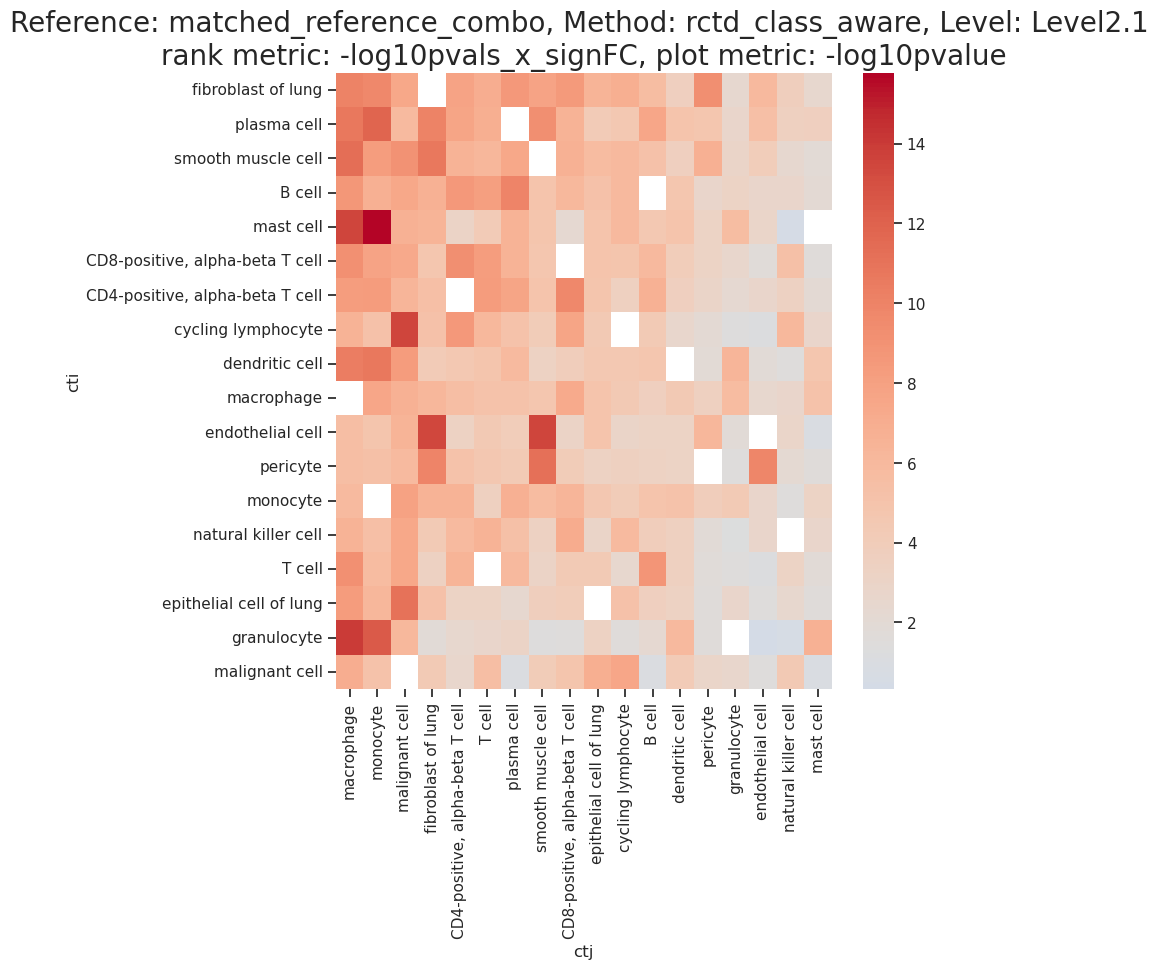

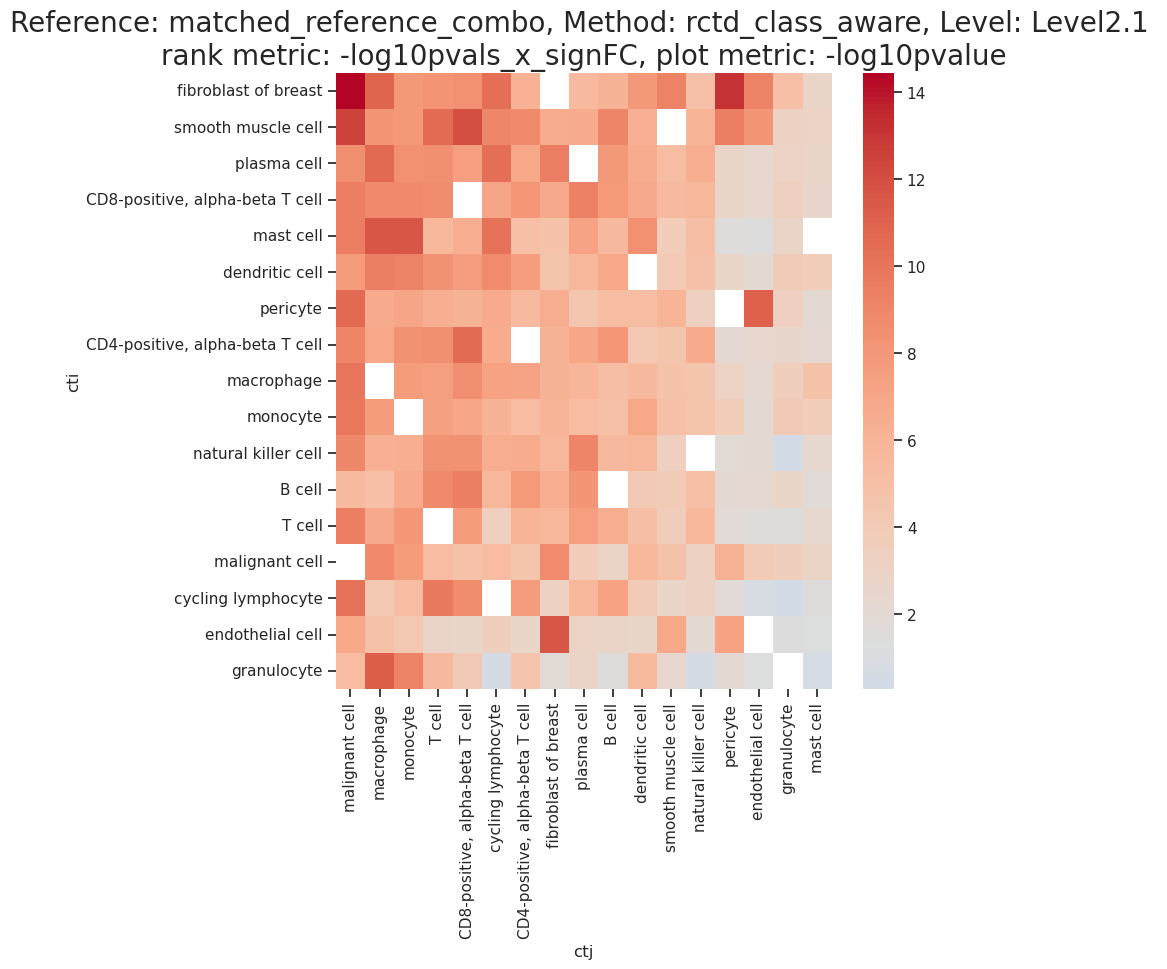

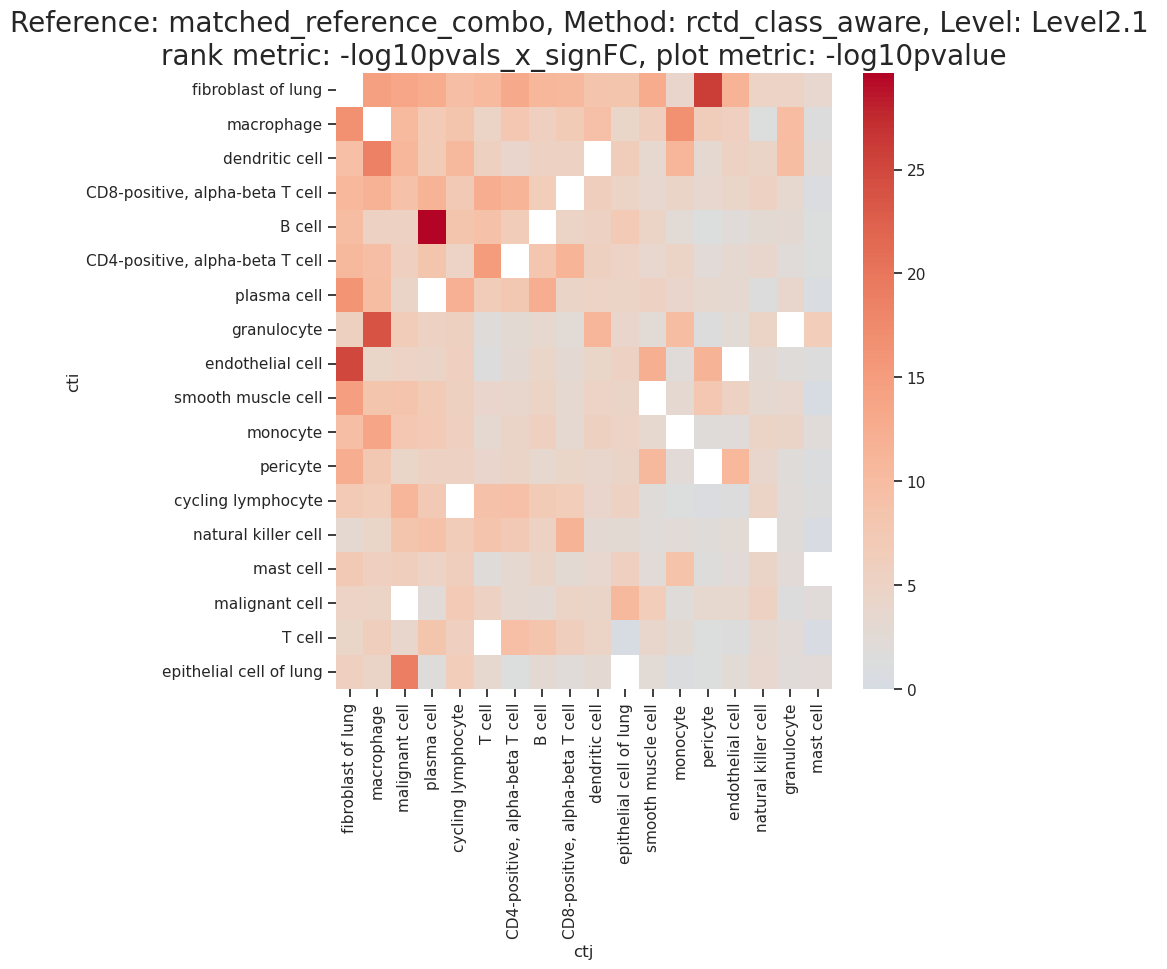

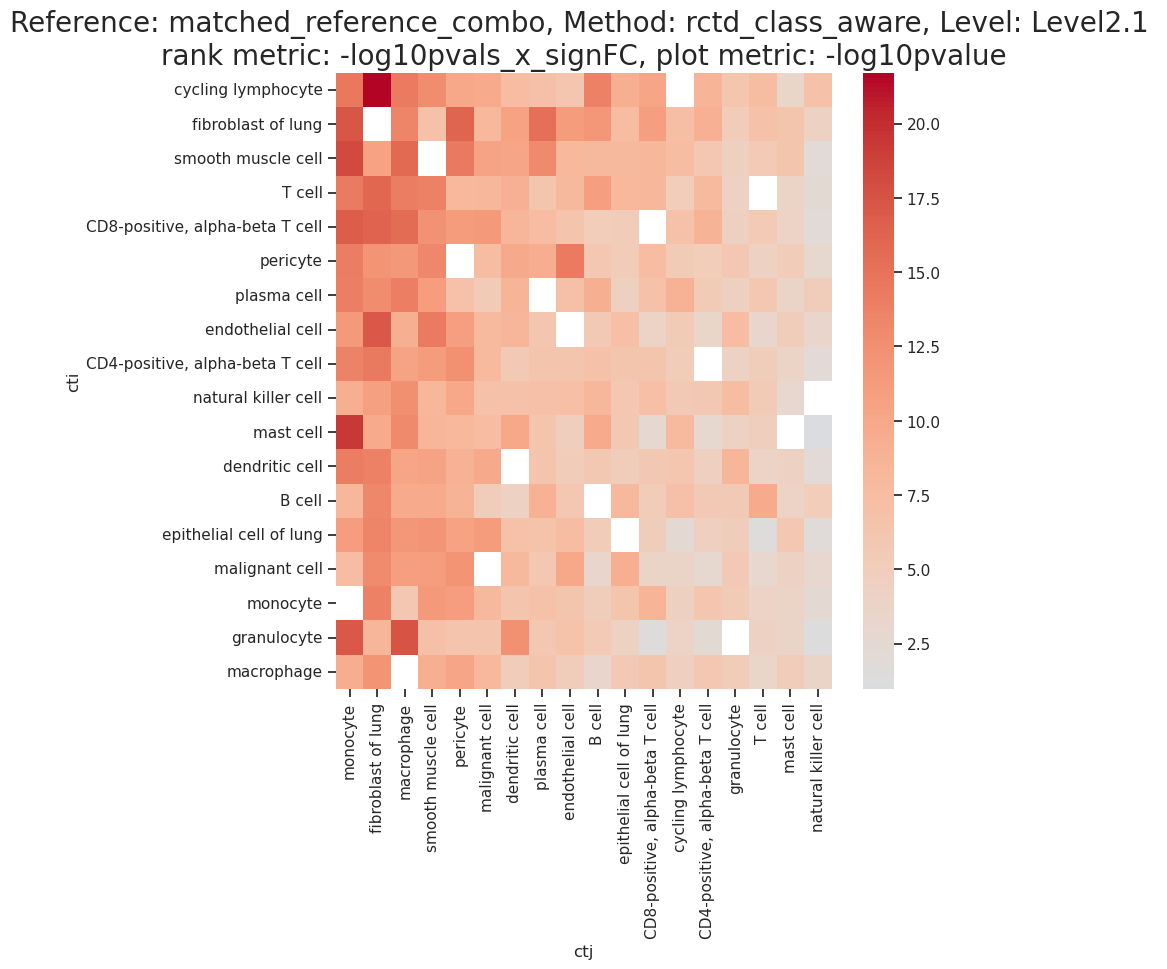

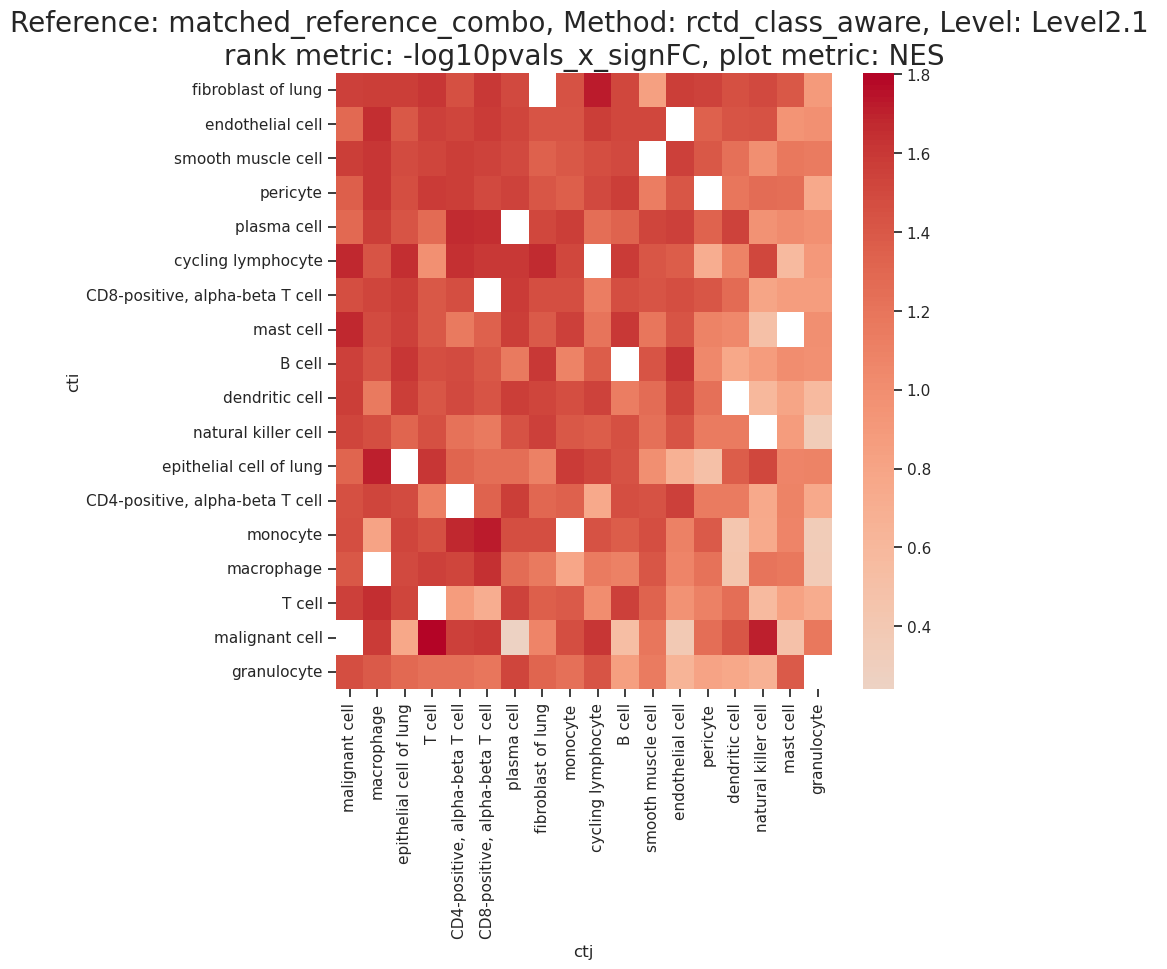

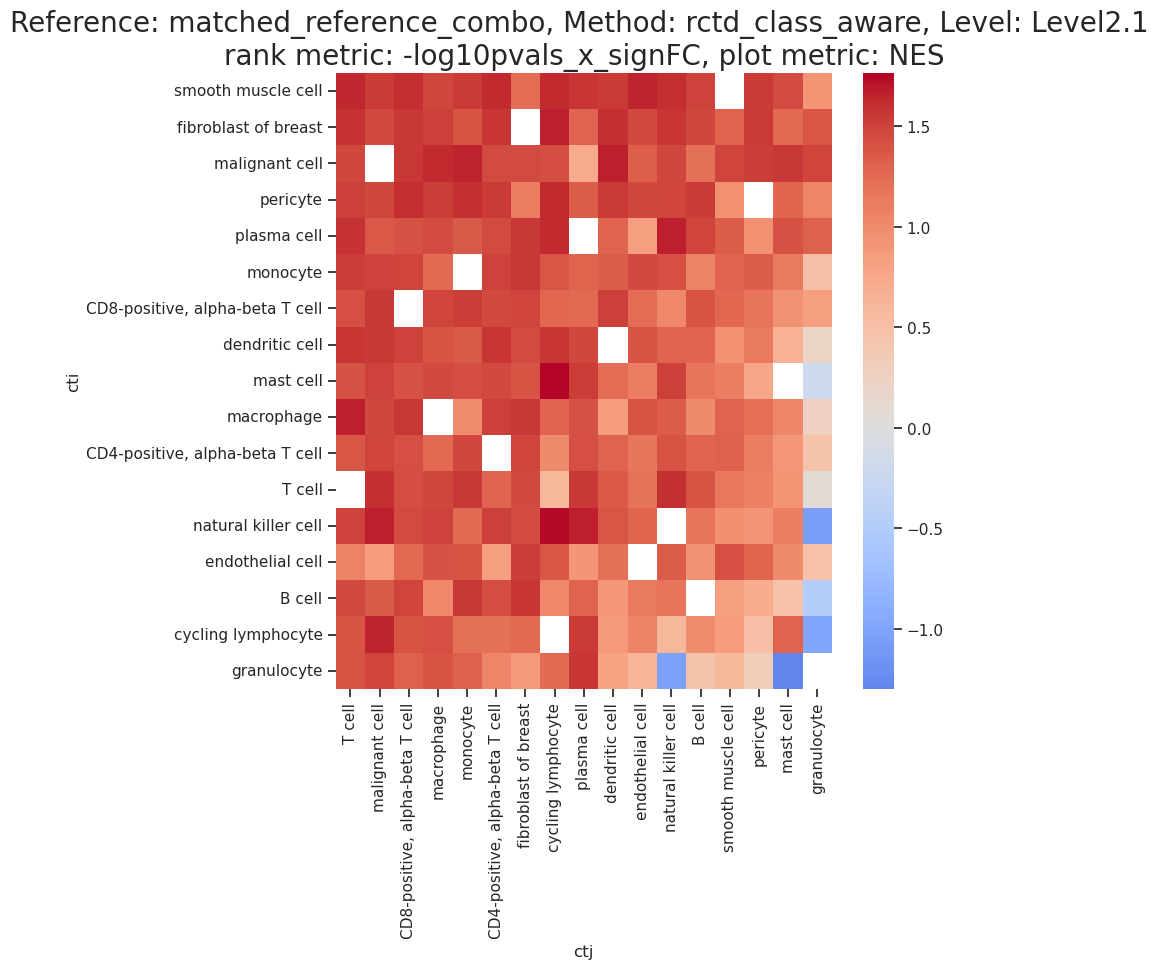

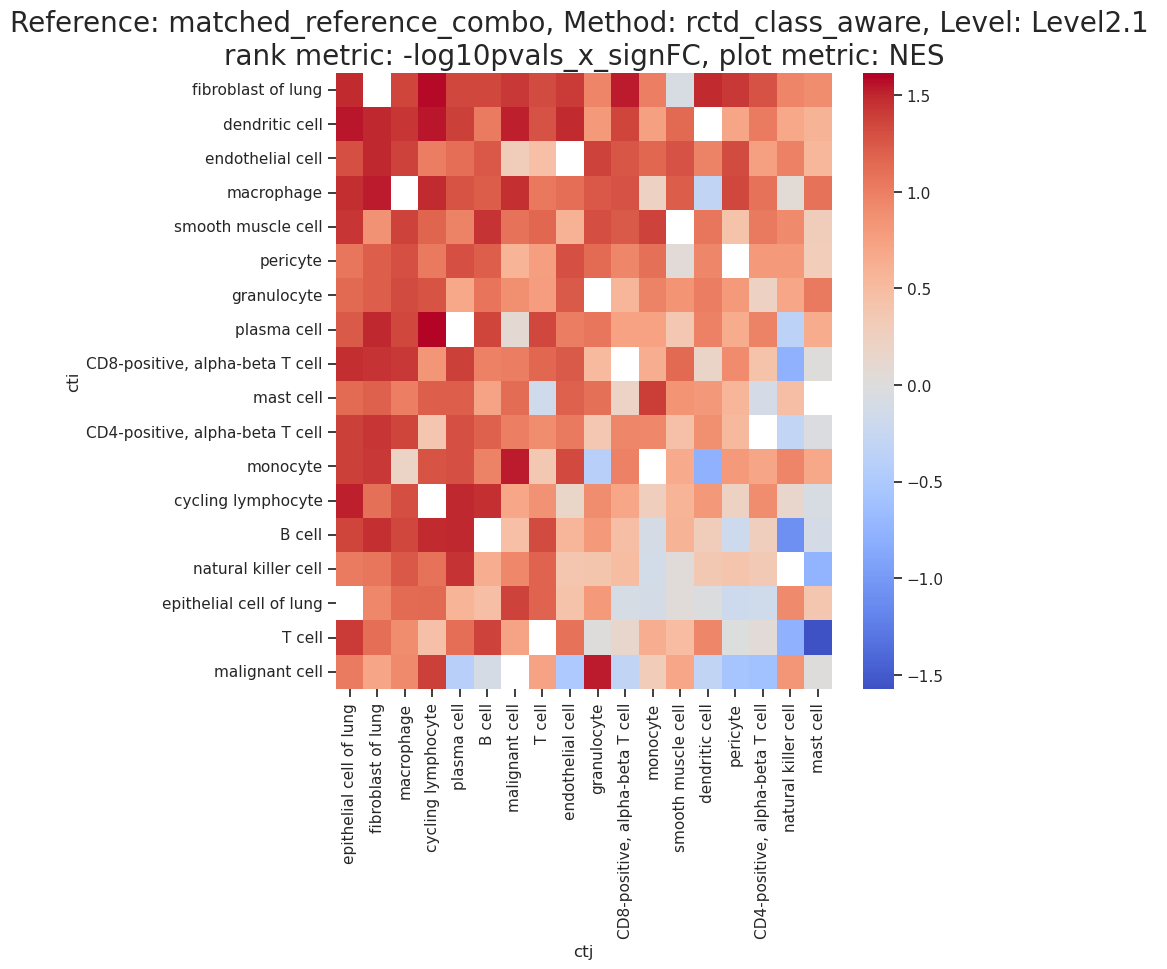

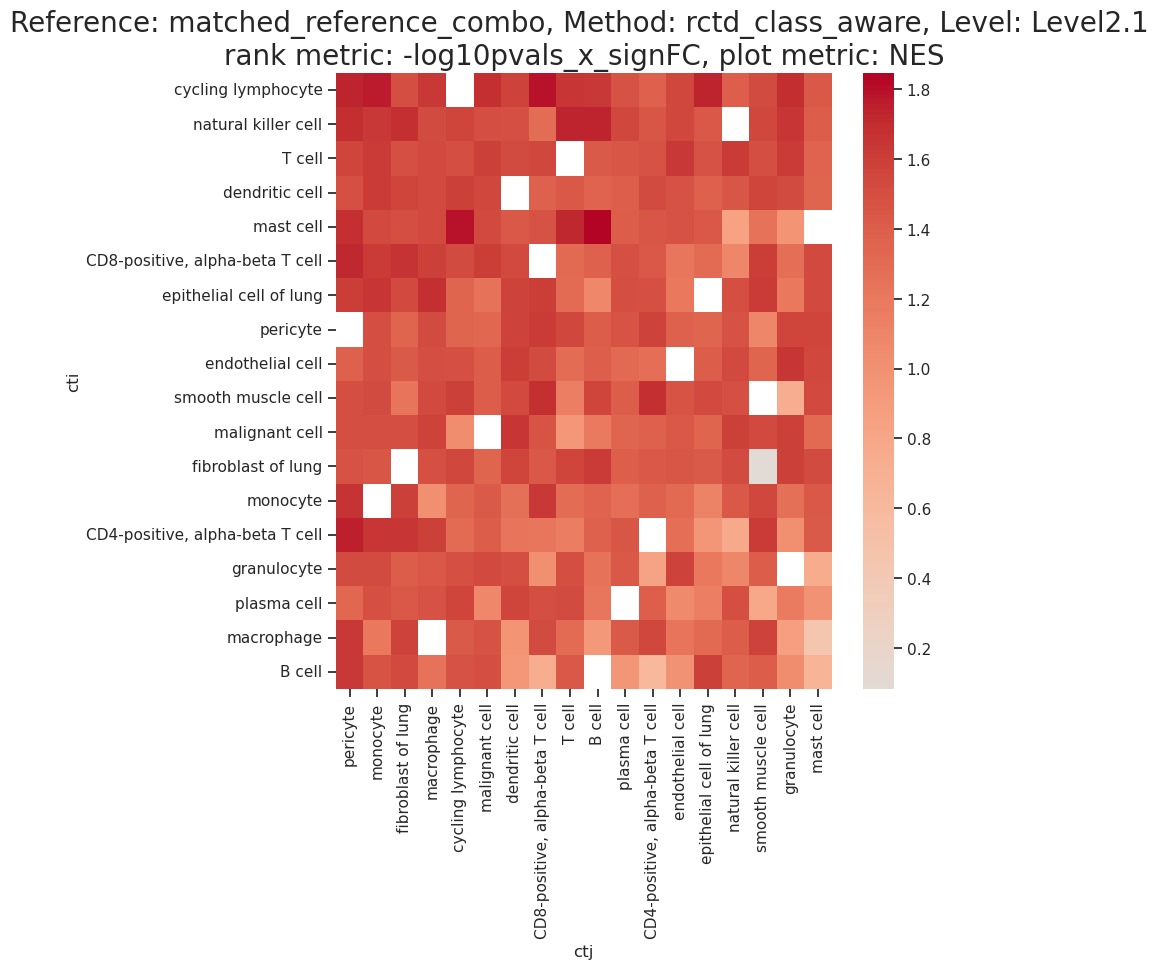

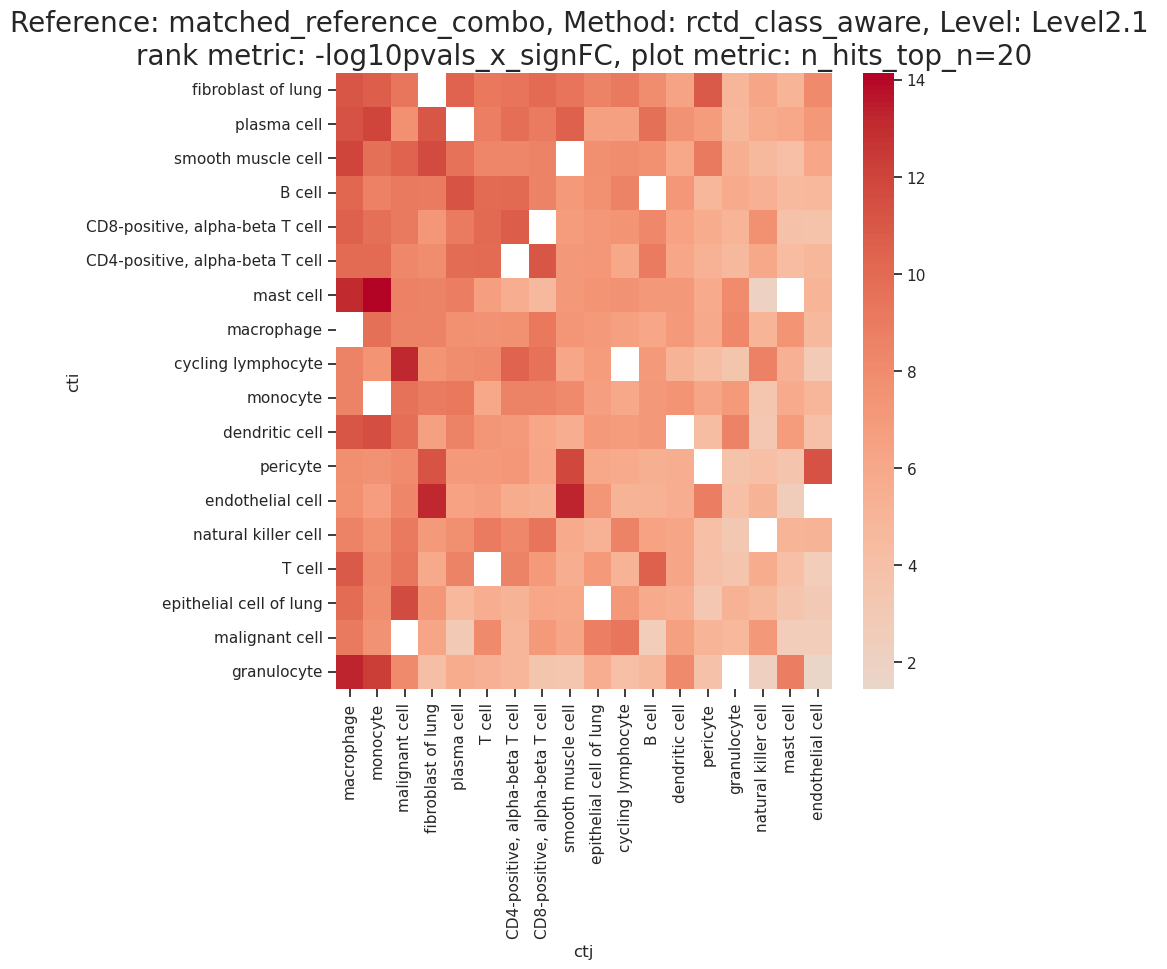

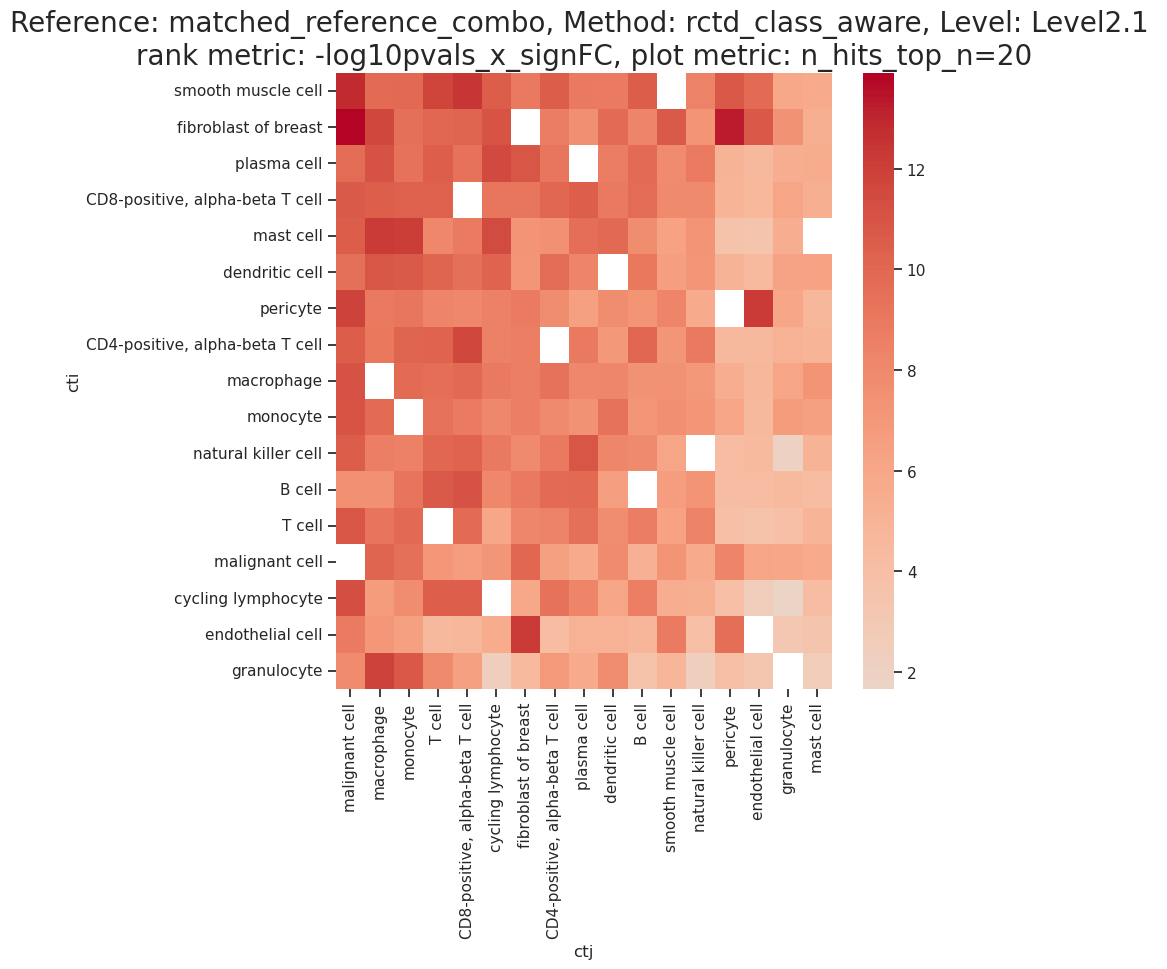

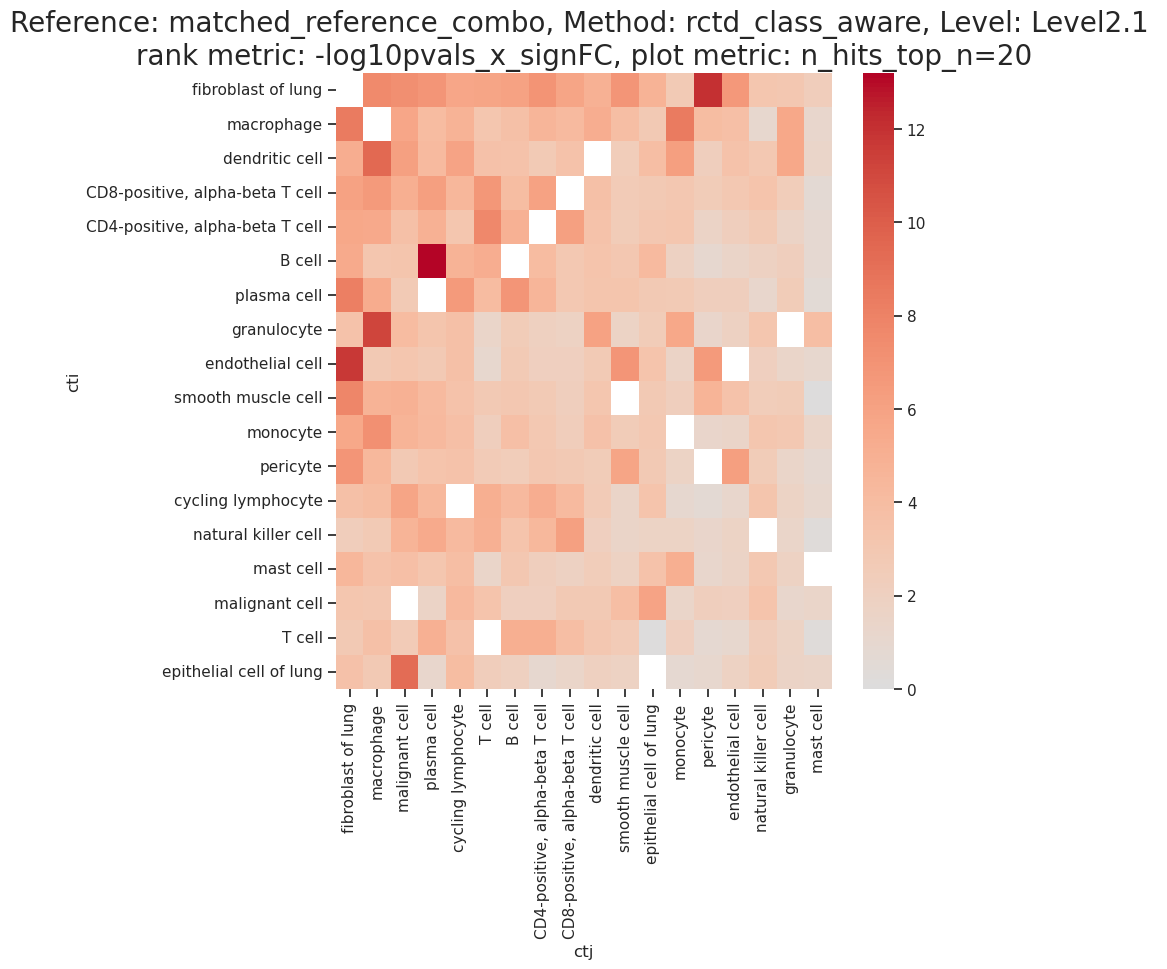

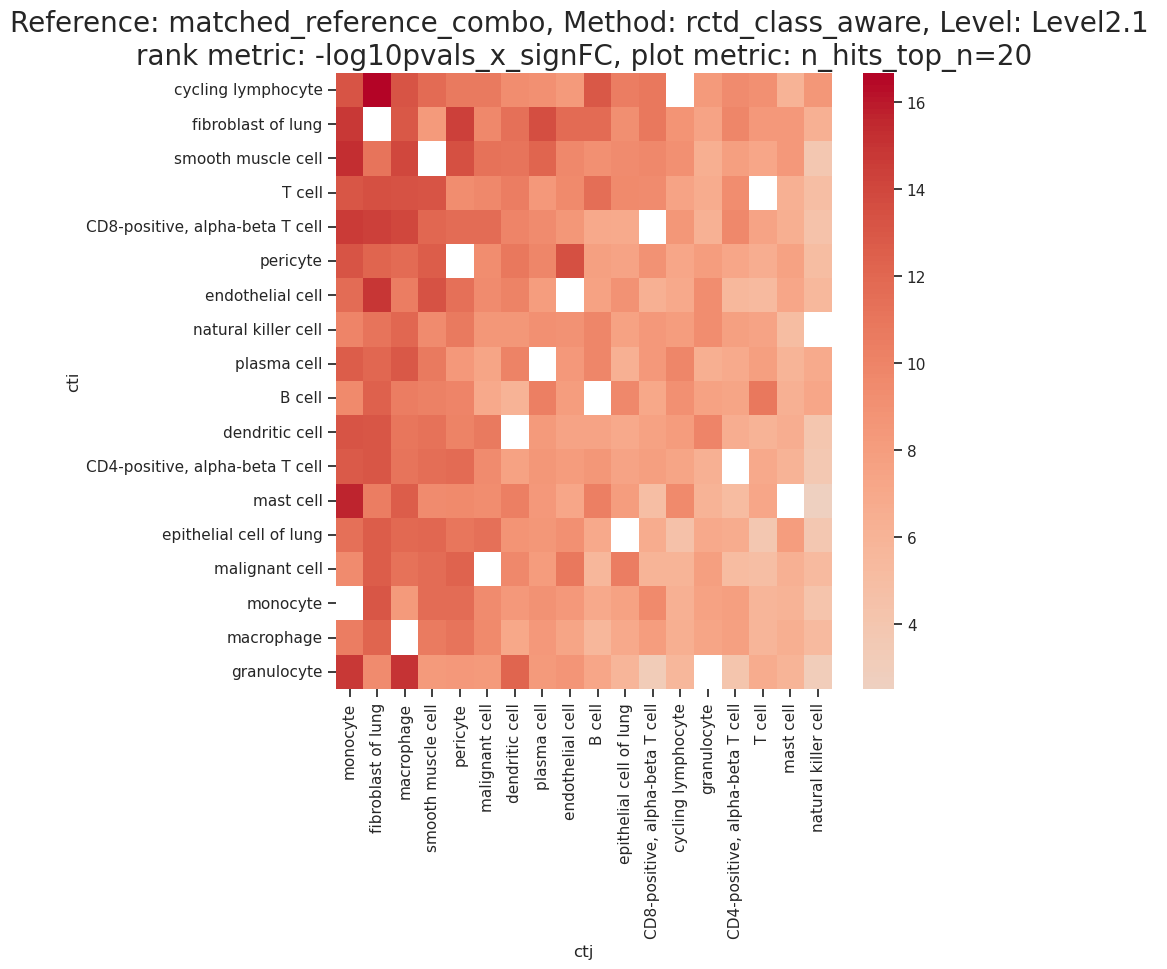

In [19]:
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]
        df[plot_metric] = df[plot_metric].astype(float)
        
        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        u_condition_panel = df[['condition','panel']].drop_duplicates().values

        for condition,panel in u_condition_panel:

            df_plot = df.query(f"segmentation == '{ref_segmentation}' and condition == '{condition}' and panel == '{panel}'")
            df_plot = df_plot.groupby(['cti', 'ctj'])[plot_metric].mean().unstack()
            df_plot = df_plot.loc[df_plot.sum(1).sort_values(ascending=False).index]
            df_plot = df_plot[df_plot.sum(0).sort_values(ascending=False).index]

            title = f"Reference: {reference}, Method: {method}, Level: {level} \nrank metric: {rank_metric}, plot metric: {plot_metric}"

            f = plt.figure(figsize=(8,8))
            ax = plt.subplot()
            ax.set_title(title,fontsize=20)
            g = sns.heatmap(df_plot,cmap='coolwarm',center=-np.log10(0.05) if plot_metric == '-log10pvalue' else 0.)
            plt.show()

# Plot number of genes

In [9]:
cti = 'T cell'

df = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','mean_n_genes'])

df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})
    
# plotting params, palette
title = f"Mean number of genes for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(6, 6))
ax = plt.subplot()
g = sns.boxplot(df,x='panel',y='mean_n_genes', 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=order
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_1823958/3306604247.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.

KeyError: 'Level2.1'

# Plot cell type identity score from markers

In [10]:
cti = 'T cell'
ref_panel = 'lung'            

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df = get_mean_cell_identity_score_markers(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

df = df.query(f"panel == '{ref_panel}' and cti == '{cti}'")
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})
    
# plotting params, palette
title = f"Cell type identity score for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(10, 4))
ax = plt.subplot()
g = sns.boxplot(df,x='segmentation',y='mean_n_marker_genes', 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

KeyError: 'Level2.1'

# Plot cell type identity score from scRNA correlation

In [27]:
columns = xenium_levels + ['correction_method','cti','cosine_distance']

pbs_scrna = {}
for k, ad in ads_scrna.items():
    pbs_scrna[k] = {}

    unique_ctis_scrna = ad.obs[labels_key].unique()
    for cti in unique_ctis_scrna:
        pb_cti_scrna = ad[ad.obs[labels_key] == cti].X.mean(0).A1
        pbs_scrna[k][cti] = pd.Series(pb_cti_scrna,index=ad.var_names)
    pbs_scrna[k] = pd.DataFrame(pbs_scrna[k])
    
data = []
for correction_method in correction_methods:
    for k, ad in ads[correction_method].items():
        print(correction_method,k)
        if ad is not None:
            tissue = k[1]
            pb_scrna = pbs_scrna[tissue]

            # genes_tissue = genes[tissue]
            genes_tissue = np.intersect1d(ad.var_names,pb_scrna.index)
            unique_ctis = ad.obs[labels_key].unique()
            for cti in unique_ctis:
                if cti in pb_scrna:
                    pb_cti = ad[ad.obs[labels_key] == cti,genes_tissue].X.mean(0).A1
                
                    dist = scipy.spatial.distance.cosine(pb_scrna[cti][genes_tissue], pb_cti)
                    data.append((*k, correction_method, cti, dist))  # Append cell type to the data

    #             break
    #         break
    #     break
    # break

# Create the DataFrame from the collected data
df = pd.DataFrame(data, columns=columns)

if columns is not None:
    df.columns = columns

raw ('segger', 'breast', 'breast', '0PD6', '0PD6')
raw ('proseg_expected', 'NSCLC', 'lung', '1GQ9', '1GQ9')
raw ('segger', 'breast', 'breast', '1BCA', '1BCA')
raw ('segger', 'breast', 'breast', '1FYB', '1FYB')
raw ('proseg_expected', 'breast', 'breast', '0PD6', '0PD6')
raw ('segger', 'breast', 'breast', '0U9A', '0U9A')
raw ('segger', 'breast', 'breast', '1FHZ', '1FHZ')
raw ('proseg_expected', 'breast', 'breast', '0U9A', '0U9A')
raw ('segger', 'breast', 'breast', '1256', '1256')
raw ('segger', 'breast', 'breast', 'OPHI', 'OPHI_3')
raw ('segger', 'breast', 'breast', '1GV1', '1GV1')
raw ('segger', 'breast', 'breast', 'OPHI', 'OPHI_1')
raw ('segger', 'breast', 'breast', '1ESQ', '1ESQ')
raw ('segger', 'breast', 'breast', '14LZ', '14LZ')
raw ('segger', 'breast', 'breast', '0VRA', '0VRA')
raw ('segger', 'breast', 'breast', '1GVR', '1GVR')
raw ('segger', 'breast', 'breast', 'OPHI', 'OPHI_2')
raw ('segger', 'breast', 'breast', '1GUC', '1GUC')
raw ('proseg_expected', 'NSCLC', 'lung', '0WMU', '0W

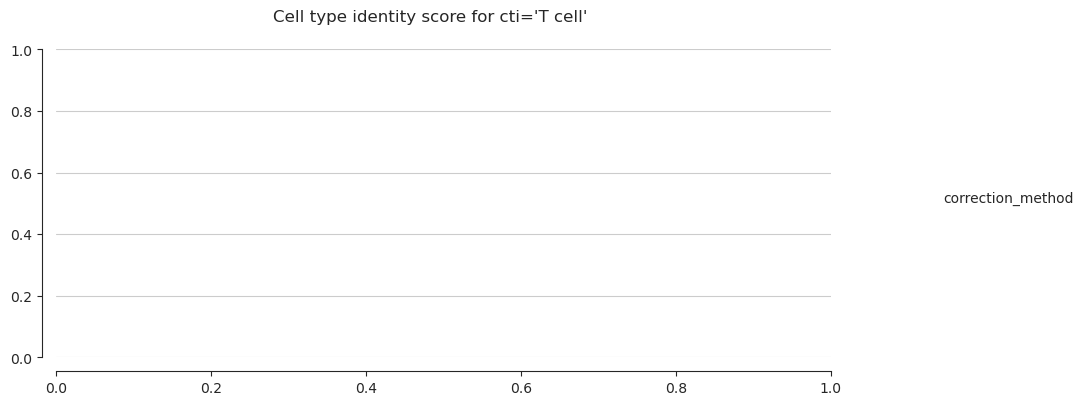

In [ ]:
cti = 'T cell'
ref_panel = 'lung'        
plot_metric = 'cosine_distance'    

# get cell identity score df
# df = get_mean_cell_identity_score_scrna(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

df = df.query(f"panel == '{ref_panel}' and cti == '{cti}'")
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})
    
# plotting params, palette
title = f"Cell type identity score for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(10, 4))
ax = plt.subplot()
g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

# Plot decontamination strength vs number of genes

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

# get n_genes df
df_n_genes = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_genes'])

# get contamination df
df_contamination = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                    for count_correction_method in correction_methods
                    for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                    }).reset_index()
df_contamination.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df_contamination.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

# merge and filter for segmentation and cell type pair of interest (df_n_genes is only cti specific)
df = pd.merge(df_n_genes,df_contamination,on=xenium_levels+['cti','correction_method'])
df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")

# shorten ovrlpy names
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})




# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float)) 
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n Rank metric: {rank_metric}, Plot metric: {plot_metric}")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()


# Plot cell type identity score vs number of genes

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'
plot_metric = 'mean_n_marker_genes'

# get n_genes df
df_n_genes = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_genes'])

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df_cell_identity_score = get_mean_cell_identity_score_markers(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

# merge and filter for segmentation and cell type pair of interest (df_cell_identity_score is only cti specific)
df = pd.merge(df_n_genes,df_cell_identity_score,on=xenium_levels+['cti','correction_method'])
df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti")

# shorten ovrlpy names
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})



# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()


# Plot cell type identity score vs contamination score

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'
plot_metric = plot_metrics[-1]

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df_cell_identity_score = get_mean_cell_identity_score(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

# get contamination df
df_contamination = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                    for count_correction_method in correction_methods
                    for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                    }).reset_index()
df_contamination.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df_contamination.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

# merge and filter for segmentation and cell type pair of interest (df_n_genes is only cti specific)
df = pd.merge(df_cell_identity_score,df_contamination,on=xenium_levels+['cti','correction_method'])
df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")


# shorten ovrlpy names
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})



# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_marker_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()
